## Вводные по кейсу

Быстрорастущий маркетплейс, который уже нашёл свою нишу, начал приносить прибыль.  
До недавнего времени здесь обходились отчётами в Excel, ориентировались на бухгалтерские сводки и интуицию. Но бизнес растёт, и стало понятно, что нужны настоящие продуктовые данные, системный взгляд и аналитика, которая не просто описывает проект, а развивает его.
Команда хочет понять, как чувствует себя продукт: кто приходит, кто остаётся, кто платит, кто уходит. А ещё: на каких каналах держится рост, какие категории товаров приносят деньги, а какие висят мёртвым грузом.

# Описание данных

## Таблица `Users`

| Поле              | Описание                                       |
|-------------------|------------------------------------------------|
| `user_id`         | Уникальный идентификатор пользователя.         |
| `registration_date` | Дата регистрации пользователя.                |
| `age`             | Возраст пользователя.                          |
| `gender`          | Пол.                                |
| `region`          | Регион.                                        |
| `acq_channel`     | Канал привлечения.                             |
| `buyer_segment`   | Сегмент покупателя.                            |
| `cohort_week`     | Неделя привлечения.|
| `cohort_month`    | Месяц привлечения. |

---

## Таблица `Events`

| Поле          | Описание                                                                 |
|---------------|--------------------------------------------------------------------------|
| `event_id`    | Уникальный идентификатор события.                                        |
| `user_id`     | Идентификатор пользователя.                                              |
| `event_date`  | Дата события.                                                            |
| `event_type`  | Тип события.   |
| `os`          | Операционная система.               |
| `device`      | Тип устройства.                                |
| `product_name`| Наименование товара, к которому относится событие (если применимо).      |
| `event_week`  | Неделя события.                                          |
| `event_month` | Месяц события .                                           |

---

## Таблица `Orders`

| Поле          | Описание                                                                 |
|---------------|--------------------------------------------------------------------------|
| `order_id`    | Уникальный идентификатор заказа.                                         |
| `user_id`     | Идентификатор пользователя, который сделал заказ |
| `order_date`  | Дата и время оформления заказа.                                          |
| `product_name`| Наименование товара.                                                     |
| `quantity`    | Количество единиц товара в заказе.                                       |
| `unit_price`  | Цена за одну единицу товара.                                             |
| `total_price` | Итоговая сумма заказа.                                                   |
| `category_name` | Наименование категории товара.                                         |
| `order_week`  | Неделя заказа.                                           |
| `order_month` | Месяц заказа.                                            |


## Таблица `Campaign_costs`

| Поле         | Описание                                                                 |
|--------------|--------------------------------------------------------------------------|
| `acq_channel`| Канал привлечения.  |
| `spend_month`| Месяц, в который был потрачен бюджет (отражает период, в котором были привлечены пользователи)                      |
| `budget`     | Маркетинговый бюджет (в денежном выражении), потраченный на данный канал в указанном месяце.                           |



## Описание событий

| Событие             | Описание                                                                                  |
|---------------------|-------------------------------------------------------------------------------------------|
| `page_view`         | Открытие любой страницы сайта или приложения пользователем.                                |
| `product_view`      | Просмотр страницы конкретного товара.                                                     |
| `product_click`     | Клик по товару (например, из списка товаров или на баннере).                              |
| `add_to_cart`       | Добавление товара в корзину.                                                              |
| `remove_from_cart`  | Удаление товара из корзины.                                                               |
| `search`            | Выполнение поиска по сайту или приложению.                                                |
| `filter_apply`      | Применение фильтра (например, по цене, бренду, категории).                                |
| `checkout_start`    | Начало оформления заказа (переход к оформлению корзины).                                  |
| `checkout_complete` | Завершение оформления заказа (не гарантирует покупку, покупка зависит от факта оплаты).                                          |
| `user_login`        | Вход пользователя в личный кабинет или аккаунт.                                           |
| `user_logout`       | Выход пользователя из аккаунта.                                                           |
| `wishlist_add`      | Добавление товара в список желаемого (wishlist).                                          |
| `category_view`     | Просмотр страницы категории товаров.                                                      |
| `banner_click`      | Клик по рекламному баннеру на сайте или в приложении.                                     |
| `promo_view`        | Просмотр промо-акции или специального предложения.                                        |


## Выручка маркетплейса = 5% от total_price

### План проекта
1. Загрузка данных и их предобработка
2. Обзор ключевых метрик
3. Оценка метрик монетизации и юнит-экономики
4. Поиск инсайтов, точек роста и сегментация
5. Подготовка эксперимента и подведение его результатов

# Блок кода и расчета метрик

Загрузим данные из датасетов и получим основную информацию о них. Проведем предобработку. Зафиксируем основную информацию о данных и предобработке в кратком промежуточном выводе.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
pa_marketplace_orders = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_orders.csv', parse_dates=['order_date', 'order_week', 'order_month'])
pa_marketplace_campaign_costs = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_campaign_costs.csv', parse_dates=['spend_month'])
pa_marketplace_users = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_users.csv', parse_dates=['registration_date', 'cohort_week', 'cohort_month'])
pa_marketplace_events = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_events.csv', parse_dates=['event_date', 'event_week', 'event_month'])

In [3]:
marketplace_orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_orders.csv', parse_dates=['order_date', 'order_week', 'order_month'])

In [4]:
pa_marketplace_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31357 entries, 0 to 31356
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       31357 non-null  int64         
 1   user_id        31357 non-null  int64         
 2   order_date     31357 non-null  datetime64[ns]
 3   product_name   31357 non-null  object        
 4   quantity       31357 non-null  int64         
 5   unit_price     31357 non-null  float64       
 6   total_price    31357 non-null  float64       
 7   category_name  31357 non-null  object        
 8   order_week     31357 non-null  datetime64[ns]
 9   order_month    31357 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(3), object(2)
memory usage: 2.4+ MB


In [5]:
pa_marketplace_orders.head()

,order_id,user_id,order_date,product_name,quantity,unit_price,total_price,category_name,order_week,order_month
0,1,3,2024-01-19 01:52:52,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
1,2,3,2024-01-19 01:52:52,Молоток слесарный,1,11340.38,11340.38,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
2,3,3,2024-01-19 01:52:52,Секатор садовый,2,10892.09,21784.18,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
3,4,3,2024-01-25 13:59:38,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-22,2024-01-01
4,5,3,2024-01-25 13:59:38,Чай черный,1,2099.59,2099.59,Продукты питания,2024-01-22,2024-01-01


In [6]:
# Проверяем полные дубликаты
pa_marketplace_orders.duplicated().sum()

0

In [7]:
# Проверяем дубликаты по ключевым полям события
pa_marketplace_orders.duplicated(subset=['user_id', 'order_id']).sum()

0

In [8]:
# Проверим период данных
display(f"Период данных: с {pa_marketplace_orders['order_date'].min()} по {pa_marketplace_orders['order_date'].max()}")

'Период данных: с 2024-01-01 08:03:45 по 2024-12-31 23:00:53'

In [9]:
# Уникальные значения категориальных переменных
display("category_name:", pa_marketplace_orders['category_name'].unique())

'category_name:'

array(['Инструменты и садовый инвентарь', 'Продукты питания',
       'Женская одежда', 'Аксессуары для гаджетов', 'Одежда для спорта',
       'Декор и освещение', 'Детская одежда', 'Детские игрушки',
       'Книги и канцтовары', 'Медицинские товары',
       'Косметика и парфюмерия', 'Товары для туризма',
       'Сумки и аксессуары', 'Автотовары', 'Обувь мужская',
       'Обувь женская', 'Мужская одежда', 'Бытовая техника', 'Зоотовары',
       'Товары для кухни', 'Средства для ухода', 'Мебель для дома',
       'Спортивный инвентарь', 'Товары для новорожденных',
       'Украшения и часы'], dtype=object)

In [10]:
display(f"Суммы заказов: с {pa_marketplace_orders['total_price'].min()} по {pa_marketplace_orders['total_price'].max()}")

'Суммы заказов: с 339.0 по 191797.14'

In [11]:
pa_marketplace_campaign_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   88 non-null     int64         
 1   acq_channel  88 non-null     object        
 2   spend_month  88 non-null     datetime64[ns]
 3   budget       88 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.9+ KB


In [12]:
pa_marketplace_campaign_costs.head()

,Unnamed: 0,acq_channel,spend_month,budget
0,0,Affiliate,2024-01-01,179343.3875
1,1,Affiliate,2024-02-01,175488.4875
2,2,Affiliate,2024-03-01,164543.4750
3,3,Affiliate,2024-04-01,186869.9750
4,4,Affiliate,2024-05-01,166443.7750


In [13]:
# Проверяем полные дубликаты
pa_marketplace_campaign_costs.duplicated().sum()

0

In [14]:
# Уникальные значения категориальных переменных
display("acq_channel:", pa_marketplace_campaign_costs['acq_channel'].unique())

'acq_channel:'

array(['Affiliate', 'Direct', 'Email Marketing', 'Social Media',
       'Google Ads', 'SEO', 'TikTok'], dtype=object)

In [15]:
pa_marketplace_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44151 entries, 0 to 44150
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            44151 non-null  int64         
 1   registration_date  44151 non-null  datetime64[ns]
 2   age                44151 non-null  int64         
 3   gender             44151 non-null  object        
 4   region             44151 non-null  object        
 5   acq_channel        44151 non-null  object        
 6   buyer_segment      44151 non-null  object        
 7   cohort_week        44151 non-null  datetime64[ns]
 8   cohort_month       44151 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 3.0+ MB


In [16]:
pa_marketplace_users.head()

,user_id,registration_date,age,gender,region,acq_channel,buyer_segment,cohort_week,cohort_month
0,1,2024-01-01 00:47:00,35,M,Москва,Google Ads,regular,2024-01-01,2024-01-01
1,2,2024-01-01 19:01:00,53,M,Москва,Email Marketing,rare,2024-01-01,2024-01-01
2,3,2024-01-01 04:13:00,66,F,Санкт-Петербург,Google Ads,regular,2024-01-01,2024-01-01
3,4,2024-01-01 17:18:00,58,M,Краснодар,Affiliate,one_time,2024-01-01,2024-01-01
4,5,2024-01-01 08:29:00,58,F,Другие регионы,Google Ads,regular,2024-01-01,2024-01-01


In [17]:
# Проверяем полные дубликаты
pa_marketplace_users.duplicated().sum()

0

In [18]:
# Уникальные значения категориальных переменных
display("age:", pa_marketplace_users['age'].unique())
display("gender:", pa_marketplace_users['gender'].unique())
display("region:", pa_marketplace_users['region'].unique())
display("acq_channel:", pa_marketplace_users['acq_channel'].unique())
display("buyer_segment:", pa_marketplace_users['buyer_segment'].unique())

'age:'

array([35, 53, 66, 58, 54, 32, 64, 67, 31, 19, 60, 49, 63, 50, 26, 21, 22,
       65, 70, 25, 39, 61, 34, 52, 44, 51, 41, 36, 57, 46, 59, 37, 45, 56,
       40, 69, 27, 38, 24, 55, 43, 48, 42, 28, 68, 23, 29, 62, 47, 20, 33,
       18, 30])

'gender:'

array(['M', 'F'], dtype=object)

'region:'

array(['Москва', 'Санкт-Петербург', 'Краснодар', 'Другие регионы',
       'Нижний Новгород', 'Екатеринбург', 'Московская область',
       'Новосибирск', 'Ростов-на-Дону'], dtype=object)

'acq_channel:'

array(['Google Ads', 'Email Marketing', 'Affiliate', 'SEO',
       'Social Media', 'TikTok'], dtype=object)

'buyer_segment:'

array(['regular', 'rare', 'one_time', 'medium'], dtype=object)

In [19]:
pa_marketplace_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785859 entries, 0 to 785858
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_id      785859 non-null  int64         
 1   user_id       785859 non-null  int64         
 2   event_date    785859 non-null  datetime64[ns]
 3   event_type    785859 non-null  object        
 4   os            785859 non-null  object        
 5   device        785859 non-null  object        
 6   product_name  385740 non-null  object        
 7   event_week    785859 non-null  datetime64[ns]
 8   event_month   785859 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 54.0+ MB


In [20]:
pa_marketplace_events.head()

,event_id,user_id,event_date,event_type,os,device,product_name,event_week,event_month
0,3132,100,2024-01-01,page_view,iOS,mobile,NaN,2024-01-01,2024-01-01
1,3133,100,2024-01-01,product_view,iOS,mobile,Шорты для тренировок,2024-01-01,2024-01-01
2,3134,100,2024-01-01,product_click,iOS,mobile,Куртка детская,2024-01-01,2024-01-01
3,3135,100,2024-01-01,add_to_cart,iOS,mobile,Балетки классические,2024-01-01,2024-01-01
4,3136,100,2024-01-01,checkout_start,iOS,mobile,NaN,2024-01-01,2024-01-01


In [21]:
# Проверка пропущенных значений
missing_data = pa_marketplace_events.isnull().sum()
missing_percent = (missing_data / len(pa_marketplace_events)) * 100
missing_info = pd.DataFrame({
    'Количество пропусков': missing_data,
    'Процент пропусков': missing_percent
})
display(missing_info)

,Количество пропусков,Процент пропусков
event_id,0,0.000000
user_id,0,0.000000
event_date,0,0.000000
event_type,0,0.000000
os,0,0.000000
device,0,0.000000
product_name,400119,50.914859
event_week,0,0.000000
event_month,0,0.000000


In [22]:
# Уникальные значения категориальных переменных
display("event_type:", pa_marketplace_events['event_type'].unique())
display("os:", pa_marketplace_events['os'].unique())
display("device:", pa_marketplace_events['device'].unique())

'event_type:'

array(['page_view', 'product_view', 'product_click', 'add_to_cart',
       'checkout_start', 'checkout_complete', 'user_logout', 'search',
       'category_view', 'filter_apply', 'promo_view', 'wishlist_add',
       'user_login', 'banner_click', 'remove_from_cart'], dtype=object)

'os:'

array(['iOS', 'Windows', 'macOS', 'Android'], dtype=object)

'device:'

array(['mobile', 'desktop', 'tablet'], dtype=object)

Данные: 4 таблицы - orders 31357 записей, 10 столбцов; campaign_costs 88 записей, 4 столбца; users 44151 запись, 9 столбцов; events 785859 записей, 9 столбцов.  
Типы данных в основном соответствуют ожидаемым, проведена предобработка, загрузка данных с парсингом дат.
Качество данных: полностью заполнены практически все поля - базовые данные о событиях.
Поле с высоким % пропусков: product_name - 50.1% пропусков. Слишком много для удаления. Отсутствуют явные дубликаты всех строк. Нет пропусков в ключевых полях.
Данные находятся в хорошем состоянии для дальнейшего анализа.

### 2. Построить обзор ключевых метрик

На этом этапе вам нужно выполнить верхнеуровневую оценку состояния продукта с помощью собранных витрин. Бизнес просит просто оценить текущее состояние — без глубокой сегментации и оценки сложных метрик.

Выручка бизнеса — 5% комиссии от стоимости любой продажи.

Посмотрите на общую динамику ключевых метрик: например, Revenue, ARPU или ARPPU, MAU, WAU, DAU, AOV, Retention, CTR, CR в заказ. Следовать этому списку необязательно, исходите из данных.

Ваша цель — быстро получить целостную картину, не применяя сегментацию и не рассматривая глубокие срезы. Определите, соответствует ли продукт базовым ожиданиям, виден ли рост, есть ли тревожные сигналы.

Результатом задания будет ваш вывод о динамике основных продуктовых метрик.

In [23]:
# DAU (Daily Active Users)
dau = pa_marketplace_events.groupby(pa_marketplace_events['event_date'].dt.date)['user_id'].nunique()
dau = dau.reset_index()
dau.columns = ['date', 'DAU']
dau['date'] = pd.to_datetime(dau['date'])

In [24]:
# WAU (Weekly Active Users)
wau = pa_marketplace_events.groupby(pa_marketplace_events['event_week'].dt.date)['user_id'].nunique()
wau = wau.reset_index()
wau.columns = ['week', 'WAU']
wau['week'] = pd.to_datetime(wau['week'])


In [25]:
# MAU (Monthly Active Users)
mau = pa_marketplace_events.groupby(pa_marketplace_events['event_month'].dt.date)['user_id'].nunique()
mau = mau.reset_index()
mau.columns = ['month', 'MAU']
mau['month'] = pd.to_datetime(mau['month'])

In [26]:
# Расчет средних значений
avg_dau = dau['DAU'].mean()
avg_wau = wau['WAU'].mean()
avg_mau = mau['MAU'].mean()

display("Средняя активность:")
display(f"Средний DAU: {avg_dau:.0f} пользователей")
display(f"Средний WAU: {avg_wau:.0f} пользователей")
display(f"Средний MAU: {avg_mau:.0f} пользователей")
display(f"Stickiness (DAU/WAU): {(avg_dau/avg_wau*100):.1f}%")
display(f"Stickiness (DAU/MAU): {(avg_dau/avg_mau*100):.1f}%")

'Средняя активность:'

'Средний DAU: 306 пользователей'

'Средний WAU: 1173 пользователей'

'Средний MAU: 3097 пользователей'

'Stickiness (DAU/WAU): 26.1%'

'Stickiness (DAU/MAU): 9.9%'

Получили 306 посещений в день, 1173 посещения в неделю, 3097 посещений в месяц. При этом вовлеченность недельной аудитории 26,1%, а вовлеченность месячной аудитории 9,9%.

In [27]:
# Расчет выручки (5% от total_price)
pa_marketplace_orders['revenue'] = pa_marketplace_orders['total_price'] * 0.05

# Выручка по месяцам
monthly_revenue = pa_marketplace_orders.groupby(pa_marketplace_orders['order_month'].dt.date)['revenue'].sum()
monthly_revenue = monthly_revenue.reset_index()
monthly_revenue.columns = ['month', 'revenue']
monthly_revenue['month'] = pd.to_datetime(monthly_revenue['month'])

# Выручка по неделям
weekly_revenue = pa_marketplace_orders.groupby(pa_marketplace_orders['order_week'].dt.date)['revenue'].sum()
weekly_revenue = weekly_revenue.reset_index()
weekly_revenue.columns = ['week', 'revenue']
weekly_revenue['week'] = pd.to_datetime(weekly_revenue['week'])

# Общая выручка
total_revenue = pa_marketplace_orders['revenue'].sum()
avg_monthly_revenue = monthly_revenue['revenue'].mean()

display(f"Общая выручка за весь период: {total_revenue:,.2f}")
display(f"Среднемесячная выручка: {avg_monthly_revenue:,.2f}")

'Общая выручка за весь период: 21,997,210.75'

'Среднемесячная выручка: 1,833,100.90'

In [28]:
# Рост выручки (первый и последний месяц)
first_month_rev = monthly_revenue.iloc[0]['revenue']
last_month_rev = monthly_revenue.iloc[-1]['revenue']
revenue_growth = (last_month_rev - first_month_rev) / first_month_rev * 100

display(f"Выручка в первом месяце ({monthly_revenue.iloc[0]['month'].strftime('%Y-%m')}): {first_month_rev:,.2f}")
display(f"Выручка в последнем месяце ({monthly_revenue.iloc[-1]['month'].strftime('%Y-%m')}): {last_month_rev:,.2f}")
display(f"Рост выручки: {revenue_growth:.1f}%")

'Выручка в первом месяце (2024-01): 648,890.03'

'Выручка в последнем месяце (2024-12): 1,342,492.41'

'Рост выручки: 106.9%'

In [29]:
# AOV (Average Order Value) - средний чек
aov_by_order = pa_marketplace_orders.groupby('order_id')['total_price'].sum().mean()
aov_by_date = pa_marketplace_orders.groupby('order_date')['total_price'].sum().mean()

# ARPPU (Average Revenue Per Paying User) - средняя выручка с платящего пользователя
paying_users = pa_marketplace_orders['user_id'].nunique()
total_revenue = pa_marketplace_orders['revenue'].sum()
arppu = total_revenue / paying_users

# ARPU (Average Revenue Per User) - средняя выручка со всех пользователей
total_users = pa_marketplace_users['user_id'].nunique()
arpu = total_revenue / total_users

display("Метрики монетизации:")
display(f"AOV (средний чек на заказ): {aov_by_order:.2f}")
display(f"Средний дневной чек: {aov_by_date:.2f}")
display(f"ARPPU (на платящего пользователя): {arppu:.2f}")
display(f"ARPU (на всех пользователей): {arpu:.2f}")
display(f"Платящих пользователей: {paying_users:,} ({paying_users/total_users*100:.1f}% от всех)")

'Метрики монетизации:'

'AOV (средний чек на заказ): 14030.18'

'Средний дневной чек: 24429.13'

'ARPPU (на платящего пользователя): 2465.50'

'ARPU (на всех пользователей): 498.23'

'Платящих пользователей: 8,922 (20.2% от всех)'

In [30]:
# Расчет воронки конверсии
monthly_active_users = mau.copy()
monthly_paying_users = pa_marketplace_orders.groupby(pa_marketplace_orders['order_month'].dt.date)['user_id'].nunique()
monthly_paying_users = monthly_paying_users.reset_index()
monthly_paying_users.columns = ['month', 'paying_users']
monthly_paying_users['month'] = pd.to_datetime(monthly_paying_users['month'])

# Объединим данные
conversion_data = pd.merge(monthly_active_users, monthly_paying_users, on='month', how='left')
conversion_data['paying_users'] = conversion_data['paying_users'].fillna(0)
conversion_data['conversion_rate'] = conversion_data['paying_users'] / conversion_data['MAU'] * 100

# Средняя конверсия
avg_conversion = conversion_data['conversion_rate'].mean()

# CTR (Click-Through Rate) - на основе событий
product_views = pa_marketplace_events[pa_marketplace_events['event_type'] == 'product_view'].groupby(pa_marketplace_events['event_date'].dt.date).size()
product_clicks = pa_marketplace_events[pa_marketplace_events['event_type'] == 'product_click'].groupby(pa_marketplace_events['event_date'].dt.date).size()

ctr_daily = pd.DataFrame({
    'date': pd.to_datetime(product_views.index),
    'product_views': product_views.values,
    'product_clicks': product_clicks.reindex(product_views.index, fill_value=0).values
})
ctr_daily['CTR'] = ctr_daily['product_clicks'] / ctr_daily['product_views'] * 100
avg_ctr = ctr_daily['CTR'].mean()

display("Конверсионные метрики:")
display(f"Средняя конверсия из MAU в покупку: {avg_conversion:.2f}%")
display(f"Средний CTR (клики/просмотры товаров): {avg_ctr:.2f}%")
display(f"Среднее количество просмотров товаров в день: {ctr_daily['product_views'].mean():.0f}")
display(f"Среднее количество кликов по товарам в день: {ctr_daily['product_clicks'].mean():.0f}")

'Конверсионные метрики:'

'Средняя конверсия из MAU в покупку: 35.57%'

'Средний CTR (клики/просмотры товаров): 97.29%'

'Среднее количество просмотров товаров в день: 342'

'Среднее количество кликов по товарам в день: 333'

In [31]:
# Воронка от просмотра до покупки
funnel_steps = {
    'product_view': pa_marketplace_events[pa_marketplace_events['event_type'] == 'product_view']['user_id'].nunique(),
    'product_click': pa_marketplace_events[pa_marketplace_events['event_type'] == 'product_click']['user_id'].nunique(),
    'add_to_cart': pa_marketplace_events[pa_marketplace_events['event_type'] == 'add_to_cart']['user_id'].nunique(),
    'checkout_start': pa_marketplace_events[pa_marketplace_events['event_type'] == 'checkout_start']['user_id'].nunique(),
    'checkout_complete': pa_marketplace_events[pa_marketplace_events['event_type'] == 'checkout_complete']['user_id'].nunique(),
    'purchase': pa_marketplace_orders['user_id'].nunique()
}

funnel_df = pd.DataFrame.from_dict(funnel_steps, orient='index', columns=['users'])
funnel_df['percentage'] = funnel_df['users'] / funnel_df.loc['product_view', 'users'] * 100
display(funnel_df)

,users,percentage
product_view,22069,100.000000
product_click,21745,98.531877
add_to_cart,20411,92.487199
checkout_start,16769,75.984413
checkout_complete,13897,62.970683
purchase,8922,40.427749


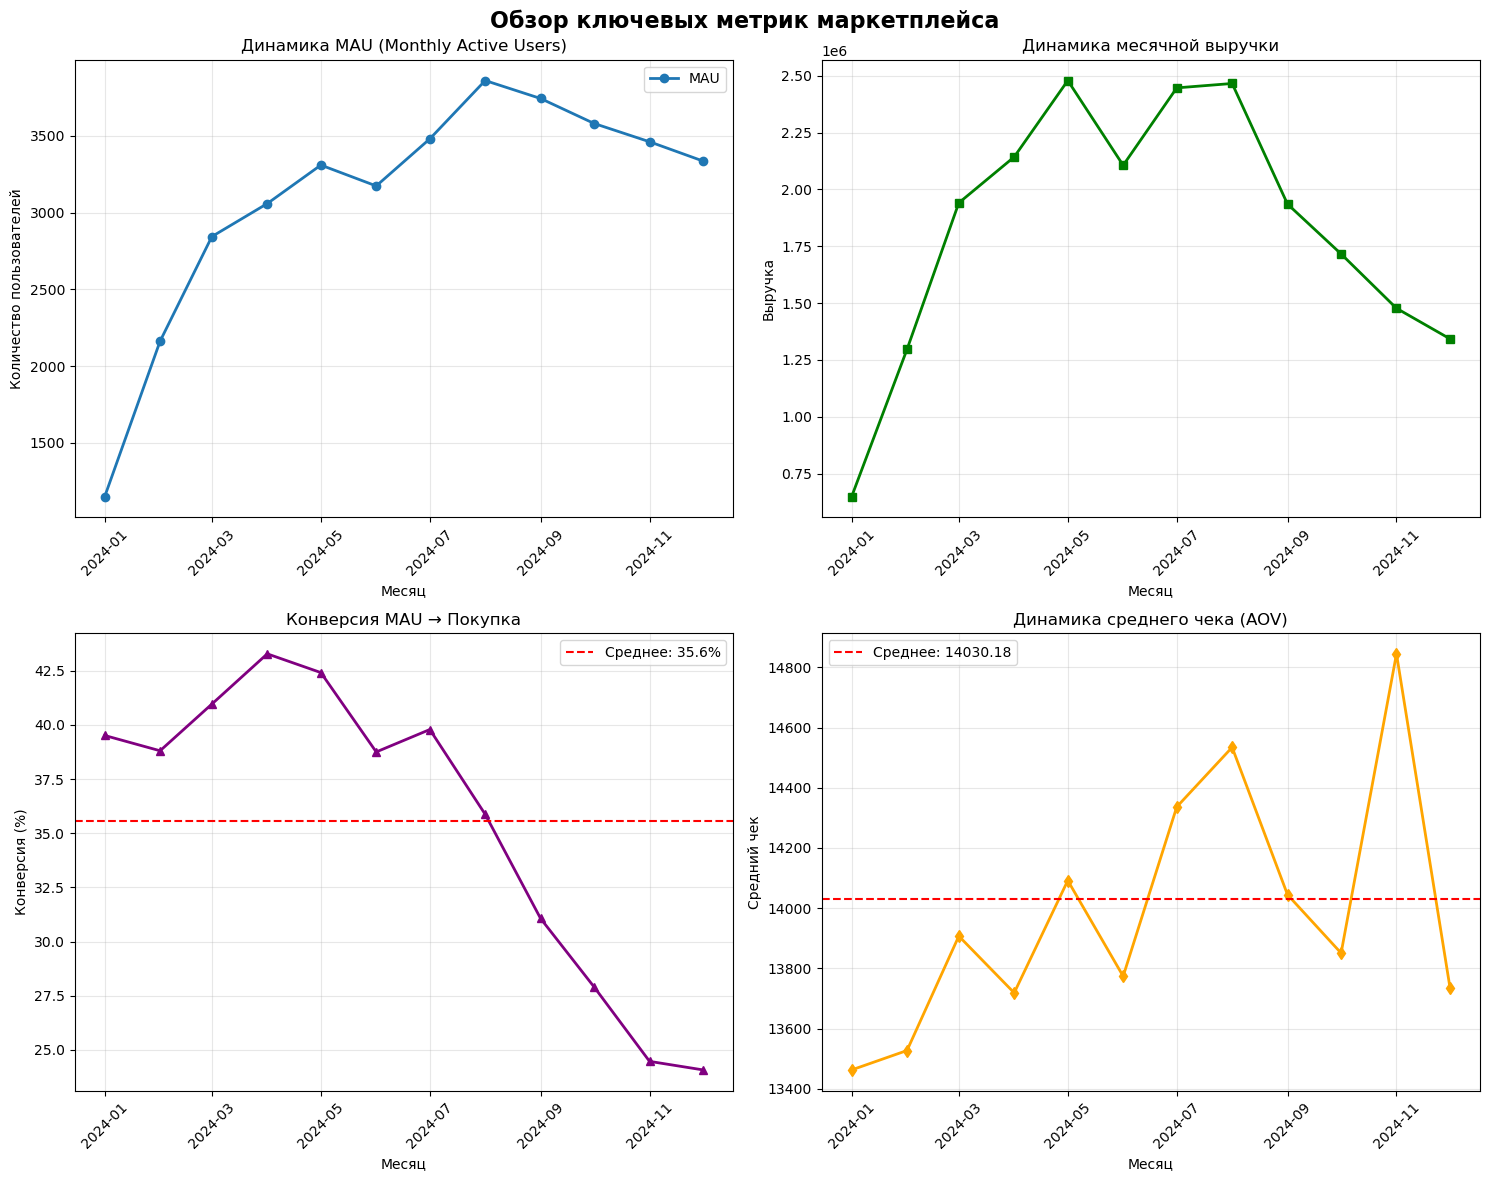

In [32]:
# Графики
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Обзор ключевых метрик маркетплейса', fontsize=16, fontweight='bold')

# Динамика MAU
ax1 = axes[0, 0]
ax1.plot(mau['month'], mau['MAU'], marker='o', linewidth=2, label='MAU')
ax1.set_title('Динамика MAU (Monthly Active Users)', fontsize=12)
ax1.set_xlabel('Месяц')
ax1.set_ylabel('Количество пользователей')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Динамика выручки
ax2 = axes[0, 1]
ax2.plot(monthly_revenue['month'], monthly_revenue['revenue'], 
        marker='s', linewidth=2, color='green')
ax2.set_title('Динамика месячной выручки', fontsize=12)
ax2.set_xlabel('Месяц')
ax2.set_ylabel('Выручка')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Конверсия MAU → Покупка
ax3 = axes[1, 0]
ax3.plot(conversion_data['month'], conversion_data['conversion_rate'], 
        marker='^', linewidth=2, color='purple')
ax3.axhline(y=avg_conversion, color='r', linestyle='--', 
           label=f'Среднее: {avg_conversion:.1f}%')
ax3.set_title('Конверсия MAU → Покупка', fontsize=12)
ax3.set_xlabel('Месяц')
ax3.set_ylabel('Конверсия (%)')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# AOV динамика
monthly_aov = pa_marketplace_orders.groupby(pa_marketplace_orders['order_month'].dt.date)['total_price'].mean()
monthly_aov = monthly_aov.reset_index()
monthly_aov.columns = ['month', 'AOV']
monthly_aov['month'] = pd.to_datetime(monthly_aov['month'])

ax4 = axes[1, 1]
ax4.plot(monthly_aov['month'], monthly_aov['AOV'], 
        marker='d', linewidth=2, color='orange')
ax4.axhline(y=aov_by_order, color='r', linestyle='--', 
           label=f'Среднее: {aov_by_order:.2f}')
ax4.set_title('Динамика среднего чека (AOV)', fontsize=12)
ax4.set_xlabel('Месяц')
ax4.set_ylabel('Средний чек')
ax4.tick_params(axis='x', rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

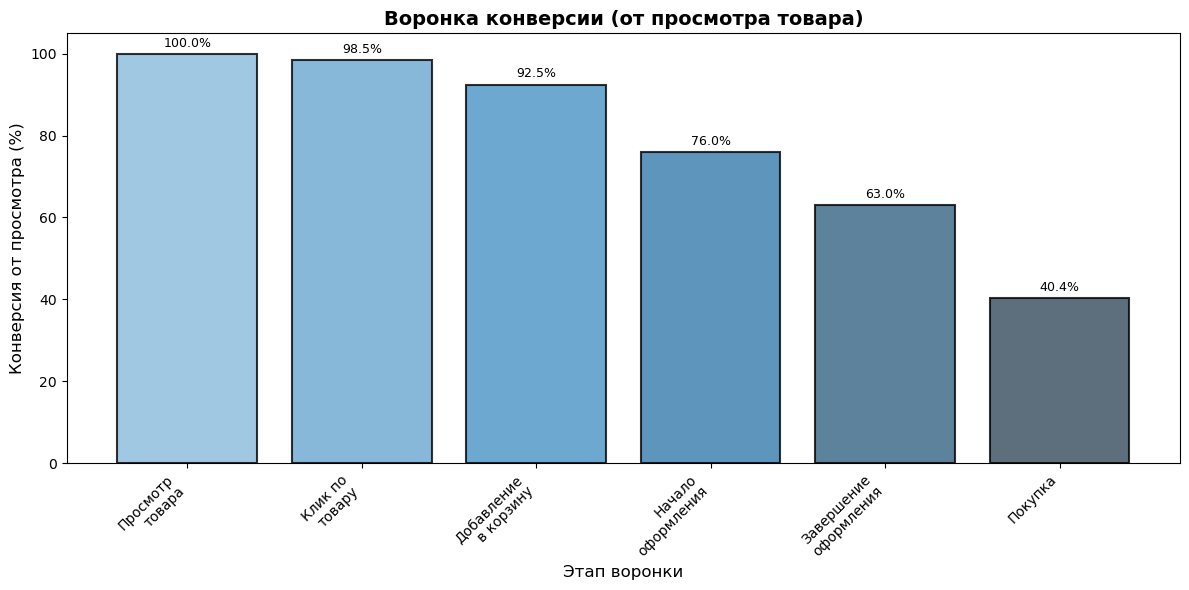

In [33]:
# Воронка конверсии
plt.figure(figsize=(12, 6))
funnel_labels = ['Просмотр\nтовара', 'Клик по\nтовару', 'Добавление\nв корзину', 
                'Начало\nоформления', 'Завершение\nоформления', 'Покупка']
funnel_values = funnel_df['percentage'].values

# Создаем столбчатую диаграмму
bars = plt.bar(range(len(funnel_labels)), funnel_values, 
               color=sns.color_palette("Blues_d", len(funnel_labels)),
               edgecolor='black', linewidth=1.5, alpha=0.8)

plt.title('Воронка конверсии (от просмотра товара)', fontsize=14, fontweight='bold')
plt.xlabel('Этап воронки', fontsize=12)
plt.ylabel('Конверсия от просмотра (%)', fontsize=12)
plt.xticks(range(len(funnel_labels)), funnel_labels, rotation=45, ha='right')

# Добавим значения на столбцы
for i, (bar, val) in enumerate(zip(bars, funnel_values)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Высокая монетизация: средний чек (AOV) 14030 — высокий показатель, общая выручка за год: 22 млн.  
Рост выручки за год: +106.9% (отличная динамика).  
Конверсия в воронке: 98.5% кликов после просмотра товара.  
MAU 3097 пользователей, платящая база: 8922 пользователей (20.2% конверсия).  
Области для улучшения:  
Низкая ежедневная активность, Stickiness 9.9% — низкий показатель, DAU 306 при MAU 3097 означает, что только 10% пользователей возвращаются ежедневно, 90% пользователей заходят реже 1 раза в день.  
Вывод: продукт не удерживает ежедневное внимание.  
Воронка конверсии:  
Максимальные потери на финальном этапе "Завершение оформления - Покупка", низкий ARPU при высоком AOV, очень низкая частота покупок.   
На графиках можно наблюдать падение показателей с сентября. Нужно уточнить, что поменялось в августе-сентябре.  
Рекомендации: Исправить потери на этапе покупки: упростить процесс оплаты, добавить больше способов оплаты, увеличить ежедневную активность, внедрить push-уведомления. Создать программу лояльности, добавить бонусы, персонализированные рекомендации.  
Заключение: Маркетплейс имеет прочный фундамент (высокий AOV, рост выручки), но страдает от проблем удержания и конверсии. Фокус на исправлении воронки и увеличении частоты взаимодействия даст максимальный ROI в краткосрочной перспективе.

### 3. Оценка метрик монетизации и юнит-экономики

Выполните анализ монетизации. Определите, сколько зарабатывает продукт и сколько тратит на привлечение.

Важны как агрегированные метрики (ARPU, AOV), так и показатели эффективности (CAC, ROI, Payback Period).

Сформулируйте первые выводы по результатам анализа метрик. Сделайте это в формате записки для заказчика. Изложите все основные результаты так, чтобы прослеживалась связь между мыслями. Не пишите много — заказчик не будет читать записку полностью, а просто просмотрит.

Напишите выводы в конце блока, чтобы заказчик мог быстро ознакомиться с основными результатами.

In [34]:
total_gmv = pa_marketplace_orders['total_price'].sum()  # Общая сумма заказов (GMV)
marketplace_revenue = total_gmv * 0.05
display(f"Общий GMV (оборот товаров): {total_gmv:,.0f}")
display(f"Выручка маркетплейса (5% от GMV): {marketplace_revenue:,.0f}")

'Общий GMV (оборот товаров): 439,944,215'

'Выручка маркетплейса (5% от GMV): 21,997,211'

In [35]:
total_acquisition_cost = pa_marketplace_campaign_costs['budget'].sum()
display(f"Общие затраты на привлечение: {total_acquisition_cost:,.0f}")

'Общие затраты на привлечение: 19,327,168'

In [36]:
total_users = pa_marketplace_users['user_id'].nunique()
total_buyers = pa_marketplace_orders['user_id'].nunique()
conversion_to_buyer = (total_buyers / total_users) * 100
display(f"Всего зарегистрированных пользователей: {total_users:,.0f}")
display(f"Из них совершили хотя бы одну покупку: {total_buyers:,.0f} ({conversion_to_buyer:.1f}%)")

'Всего зарегистрированных пользователей: 44,151'

'Из них совершили хотя бы одну покупку: 8,922 (20.2%)'

In [37]:
total_orders = pa_marketplace_orders['order_id'].nunique()
aov_gmv = total_gmv / total_orders  # Средний чек с точки зрения пользователя
aov_revenue = marketplace_revenue / total_orders # Средний чек с точки зрения маркетплейса
display(f"Средний чек (GMV): {aov_gmv:,.0f}")
display(f"Средний чек (Выручка маркетплейса): {aov_revenue:,.0f}")

'Средний чек (GMV): 14,030'

'Средний чек (Выручка маркетплейса): 702'

In [38]:
# ARPU (Average Revenue Per User)
arpu = marketplace_revenue / total_users
display(f"ARPU (выручка на пользователя): {arpu:.2f}")

# ARPPU (Average Revenue Per Paying User)
arppu = marketplace_revenue / total_buyers
display(f"ARPPU (выручка на покупателя): {arppu:.2f}")

'ARPU (выручка на пользователя): 498.23'

'ARPPU (выручка на покупателя): 2465.50'

In [39]:
# Среднее количество заказов на покупателя
orders_per_buyer = total_orders / total_buyers
display(f"Среднее количество заказов на покупателя: {orders_per_buyer:.2f}")

'Среднее количество заказов на покупателя: 3.51'

In [40]:
# CAC (Customer Acquisition Cost)
cac = total_acquisition_cost / total_buyers
display(f"CAC (средняя стоимость привлечения покупателя): {cac:.2f}")

# ROI (Return on Investment)
roi = ((marketplace_revenue - total_acquisition_cost) / total_acquisition_cost) * 100
display(f"ROI (рентабельность инвестиций в маркетинг): {roi:.1f}%")

# ROMI (Return on Marketing Investment)
romi = (marketplace_revenue / total_acquisition_cost) * 100
display(f"ROMI (возврат на маркетинговые инвестиции): {romi:.1f}%")

# LTV/CAC Ratio
ltv_cac_ratio = arppu / cac
display(f"Соотношение LTV/CAC (на основе ARPPU): {ltv_cac_ratio:.2f}")

'CAC (средняя стоимость привлечения покупателя): 2166.24'

'ROI (рентабельность инвестиций в маркетинг): 13.8%'

'ROMI (возврат на маркетинговые инвестиции): 113.8%'

'Соотношение LTV/CAC (на основе ARPPU): 1.14'

In [41]:
pa_marketplace_users['registration_date'] = pd.to_datetime(pa_marketplace_users['registration_date'])
pa_marketplace_campaign_costs['spend_month'] = pd.to_datetime(pa_marketplace_campaign_costs['spend_month'])

# Находим user_id всех пользователей, которые делали заказы
paying_users = pa_marketplace_orders['user_id'].unique()
    
# Фильтруем пользователей, оставляя только тех, кто совершал покупки
users_filtered = pa_marketplace_users[pa_marketplace_users['user_id'].isin(paying_users)].copy()

# Считаем количество платящих клиентов по каналам привлечения
users_grouped = users_filtered.groupby('acq_channel').agg({
    'user_id': 'count'
}).reset_index()
users_grouped.columns = ['acq_channel', 'paying_users_count']

# Объединяем с таблицей Campaigns по acq_channel
# Сначала агрегируем бюджеты по месяцам и каналам
campaigns_grouped = pa_marketplace_campaign_costs.groupby(['acq_channel', 'spend_month']).agg({
    'budget': 'sum'
}).reset_index()

# Приводим spend_month к формату Period (месяц)
campaigns_grouped['month'] = pd.to_datetime(campaigns_grouped['spend_month']).dt.to_period('M')

# Суммируем количество платящих клиентов по месяцам
# Для этого нужно сопоставить месяц привлечения пользователя
users_filtered['registration_month'] = pd.to_datetime(users_filtered['registration_date']).dt.to_period('M')

paying_users_by_month_channel = users_filtered.groupby(['acq_channel', 'registration_month']).agg({
    'user_id': 'count'
}).reset_index()
paying_users_by_month_channel.columns = ['acq_channel', 'month', 'paying_users_count']

# Объединяем данные о бюджетах и платящих пользователях
final_data = campaigns_grouped.merge(
    paying_users_by_month_channel,
    on=['acq_channel', 'month'],
    how='inner'
)

# Суммируем общие затраты и количество пользователей по месяцам
final_summary = final_data.groupby('month').agg({
    'budget': 'sum',
    'paying_users_count': 'sum'
}).reset_index()

# Считаем CAC (Customer Acquisition Cost)
final_summary['CAC'] = final_summary['budget'] / final_summary['paying_users_count']

# Выводим результат
display(final_summary[['month', 'CAC']])

,month,CAC
0,2024-01,1392.552165
1,2024-02,1308.106407
2,2024-03,1321.254513
3,2024-04,1249.168259
4,2024-05,1425.777412
5,2024-06,1569.219181
6,2024-07,1770.589559
7,2024-08,2226.765273
8,2024-09,2712.413419
9,2024-10,3644.703977


In [42]:
# CAC по каналам привлечения
cac_by_channel = final_data.copy()
cac_by_channel['CAC'] = cac_by_channel['budget'] / cac_by_channel['paying_users_count']
display("\nCAC по каналам привлечения:")
display(cac_by_channel[['acq_channel', 'month', 'CAC']])

'\nCAC по каналам привлечения:'

,acq_channel,month,CAC
0,Affiliate,2024-01,879.134252
1,Affiliate,2024-02,759.690422
2,Affiliate,2024-03,737.863117
3,Affiliate,2024-04,759.634045
4,Affiliate,2024-05,699.343592
...,...,...,...
65,TikTok,2024-08,11241.668605
66,TikTok,2024-09,9286.971457
67,TikTok,2024-10,14032.128788
68,TikTok,2024-11,12990.276786


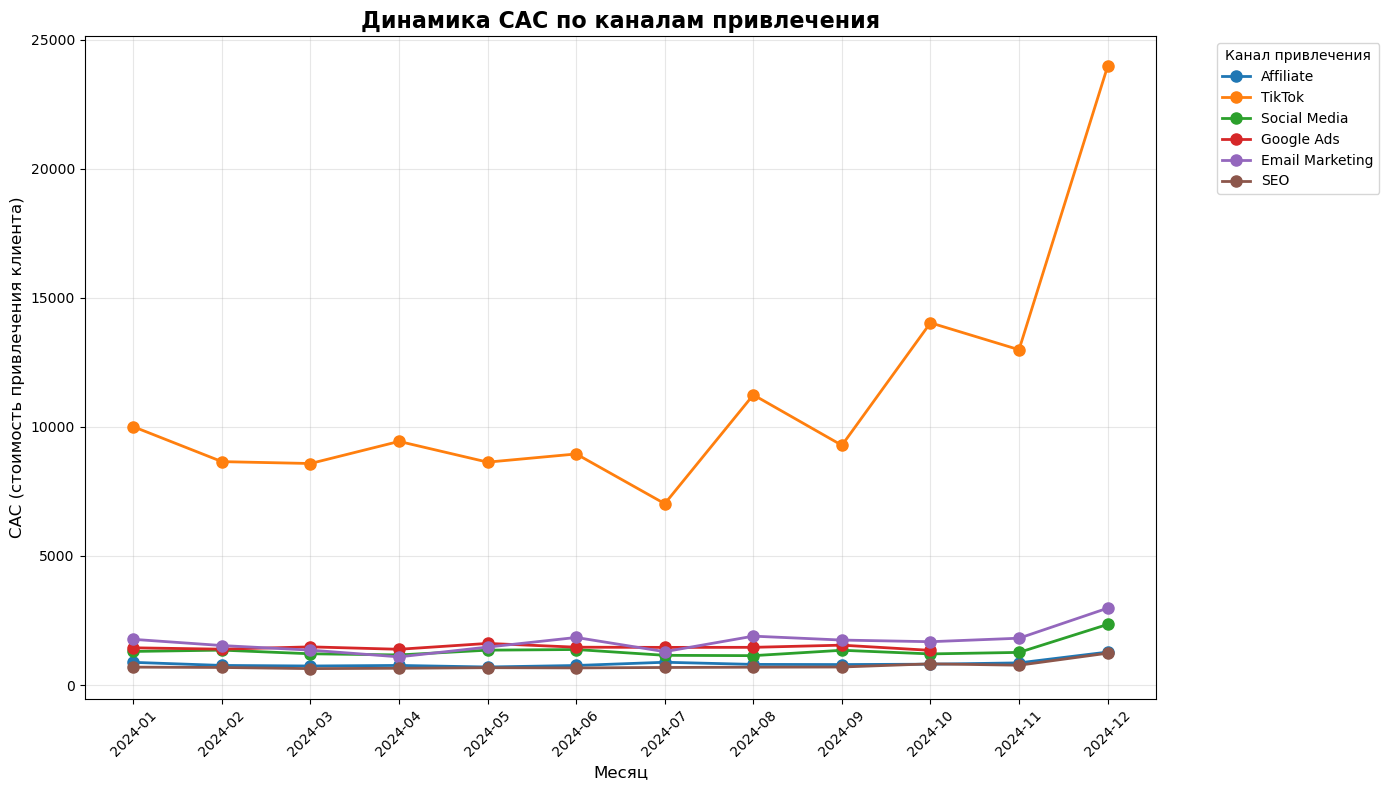

In [43]:
# Линейный график CAC по месяцам для каждого канала
plt.figure(figsize=(14, 8))

# Преобразуем month в строку для правильного отображения
cac_by_channel['month_str'] = cac_by_channel['month'].astype(str)

# Сортируем по месяцам для правильного порядка на графике
cac_by_channel_sorted = cac_by_channel.sort_values('month')

for channel in cac_by_channel_sorted['acq_channel'].unique():
    channel_data = cac_by_channel_sorted[cac_by_channel_sorted['acq_channel'] == channel]
    plt.plot(channel_data['month_str'], channel_data['CAC'], 
             marker='o', linewidth=2, markersize=8, label=channel)

plt.title('Динамика CAC по каналам привлечения', fontsize=16, fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('CAC (стоимость привлечения клиента)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Канал привлечения', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Стоимость привлечения начинает расти с августа и достигает максимума в декабре. По графику мы видим, что увеличение САС происходит за счет увеличения затрат по каналу привлечения Tik-Tok.

In [44]:
# Получаем CAC по каналам за каждый месяц из предыдущих расчетов
cac_by_channel_month = cac_by_channel[['acq_channel', 'month', 'CAC']].copy()
cac_by_channel_month['month'] = cac_by_channel_month['month'].dt.to_timestamp()

# Приводим registration_date к периоду и потом к timestamp для совместимости
pa_marketplace_users['registration_month'] = pd.to_datetime(
    pa_marketplace_users['registration_date']
).dt.to_period('M').dt.to_timestamp()

# Присоединяем CAC к пользователям
users_with_cac = pd.merge(
    pa_marketplace_users[['user_id', 'acq_channel', 'registration_month']],
    cac_by_channel_month,
    left_on=['acq_channel', 'registration_month'],
    right_on=['acq_channel', 'month'],
    how='left'
)

# Заполняем пропуски в CAC медианным значением
users_with_cac['CAC'] = users_with_cac['CAC'].fillna(users_with_cac['CAC'].median())

# Приводим CAC к float для совместимости
users_with_cac['CAC'] = users_with_cac['CAC'].astype(float)

# Объединяем пользователей с заказами
df = pd.merge(pa_marketplace_users, pa_marketplace_orders, on='user_id', how='left')

# Добавляем CAC из подготовленной таблицы
df = pd.merge(df, users_with_cac[['user_id', 'CAC']], on='user_id', how='left')

# Преобразуем даты
df['registration_date'] = pd.to_datetime(df['registration_date'])
df['order_date'] = pd.to_datetime(df['order_date'])

# Выручка маркетплейса от заказа (заполняем NaN нулями)
df['marketplace_revenue'] = df['total_price'].fillna(0) * 0.05

df['CAC'] = df['CAC'].astype(float)

# Находим первую покупку каждого пользователя
# Для пользователей без заказов min_order_date будет NaN
df['min_order_date'] = df.groupby('user_id')['order_date'].transform('min')

# Создаем флаг первой покупки (True для первой покупки, False для остальных и для пользователей без покупок)
df['is_first_order'] = (df['order_date'] == df['min_order_date']) & df['order_date'].notna()

# Инициализируем cost_allocation как float
df['cost_allocation'] = 0.0

# Распределяем затраты: CAC учитываем только при первой покупке
# Используем .loc с явным указанием индексов
first_order_mask = df['is_first_order']
if first_order_mask.any():
    df.loc[first_order_mask, 'cost_allocation'] = df.loc[first_order_mask, 'CAC'].values

# PNL = Выручка - Затраты
df['PNL'] = df['marketplace_revenue'] - df['cost_allocation'].astype(float)

# Найдём минимальную дату для каждого пользователя и округлим до начала месяца
df['first_month'] = df['min_order_date'].dt.to_period('M').dt.to_timestamp()

# Округлим каждую order_date до начала месяца (для заказов)
df['order_date_month'] = df['order_date'].dt.to_period('M').dt.to_timestamp()

# Рассчитаем разницу в месяцах между минимальной датой и текущей датой
# расчет N_month (месяц жизни)
df['N_month'] = (
    (df['order_date_month'].dt.year - df['first_month'].dt.year) * 12 +
    (df['order_date_month'].dt.month - df['first_month'].dt.month)
)

# Для пользователей без заказов N_month будет NaN
df['N_month'] = df['N_month'].fillna(0)

# берем только пользователей с заказами для LTV анализа
df_with_orders = df[df['order_date'].notna()].copy()

# Суммируем PNL для каждого месяца и сохраняем CAC
df_LTV = df_with_orders.groupby(['user_id', 'acq_channel', 'first_month', 'N_month']).agg({
    'PNL': 'sum',
    'CAC': 'first'  # берем первое значение CAC для каждого пользователя в месяце
}).reset_index()

# Отсортируем данные по N_month, для корректного расчёта LTV при помощи cumsum()
df_LTV = df_LTV.sort_values(by=['user_id', 'acq_channel', 'N_month'])

# Посчитаем LTV для каждого месяца (кумулятивная сумма PNL)
df_LTV['LTV'] = df_LTV.groupby(['user_id'])['PNL'].cumsum()

# Убедимся, что типы данных правильные
df_LTV['PNL'] = df_LTV['PNL'].astype(float)
df_LTV['LTV'] = df_LTV['LTV'].astype(float)
df_LTV['CAC'] = df_LTV['CAC'].astype(float)

display(df_LTV.head(10))

,user_id,acq_channel,first_month,N_month,PNL,CAC,LTV
0,3,Google Ads,2024-01-01,0.0,30.624805,1442.978898,30.624805
1,5,Google Ads,2024-01-01,0.0,2648.027602,1442.978898,2648.027602
2,5,Google Ads,2024-01-01,1.0,2031.900500,1442.978898,4679.928102
3,5,Google Ads,2024-01-01,2.0,946.083000,1442.978898,5626.011102
4,6,SEO,2024-01-01,0.0,-578.027802,693.996802,-578.027802
5,6,SEO,2024-01-01,3.0,253.607000,693.996802,-324.420802
6,8,Social Media,2024-01-01,0.0,-312.837064,1301.440064,-312.837064
7,8,Social Media,2024-01-01,1.0,1281.465500,1301.440064,968.628436
8,12,Social Media,2024-01-01,0.0,-999.434064,1301.440064,-999.434064
9,15,Affiliate,2024-01-01,0.0,-497.501252,879.134252,-497.501252


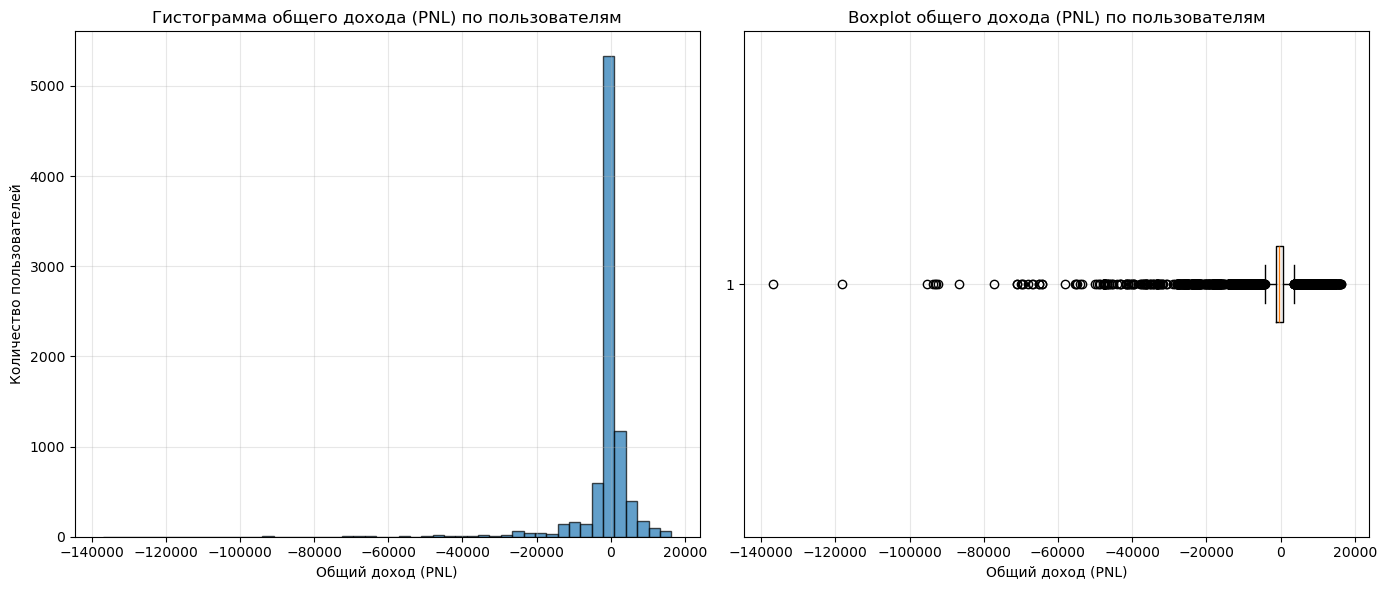

In [45]:
plt.figure(figsize=(14, 6))

# Сгруппируем по user_id и суммируем PNL
df_grouped = df_LTV.groupby('user_id')['PNL'].sum().reset_index()

# Фильтруем выбросы для лучшей визуализации
q99 = df_grouped['PNL'].quantile(0.99)
df_filtered = df_grouped[df_grouped['PNL'] <= q99]

# Построим гистограмму по столбцу 'PNL'
plt.subplot(1, 2, 1)
plt.hist(df_filtered['PNL'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Гистограмма общего дохода (PNL) по пользователям')
plt.xlabel('Общий доход (PNL)')
plt.ylabel('Количество пользователей')
plt.grid(True, alpha=0.3)

# Boxplot для анализа распределения
plt.subplot(1, 2, 2)
plt.boxplot(df_filtered['PNL'], vert=False)
plt.title('Boxplot общего дохода (PNL) по пользователям')
plt.xlabel('Общий доход (PNL)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
# Статистика по PNL
display(f"\nСТАТИСТИКА ПО ДОХОДУ ОТ ПОЛЬЗОВАТЕЛЕЙ:")
display(f"Средний доход на пользователя: {df_grouped['PNL'].mean():.2f}")
display(f"Медианный доход: {df_grouped['PNL'].median():.2f}")
display(f"Стандартное отклонение: {df_grouped['PNL'].std():.2f}")

'\nСТАТИСТИКА ПО ДОХОДУ ОТ ПОЛЬЗОВАТЕЛЕЙ:'

'Средний доход на пользователя: -913.24'

'Медианный доход: -520.68'

'Стандартное отклонение: 8054.80'

Средний доход: -913.24 - в среднем каждый пользователь приносит убыток.  
Медианный доход: -520.68 - у более половины пользователей доход отрицательный.  
Это означает, что затраты на привлечение (CAC) в среднем превышают доход от пользователей.  
Включены ВСЕ пользователи (включая неплатящих) и CAC распределен на всех, даже на тех, кто не купил. Высокий CAC в некоторых каналах (особенно TikTok до 24,000). Низкая конверсия (20.2% пользователей покупают).  
Бизнес теряет деньги на привлечении пользователей в среднем по всем каналам.

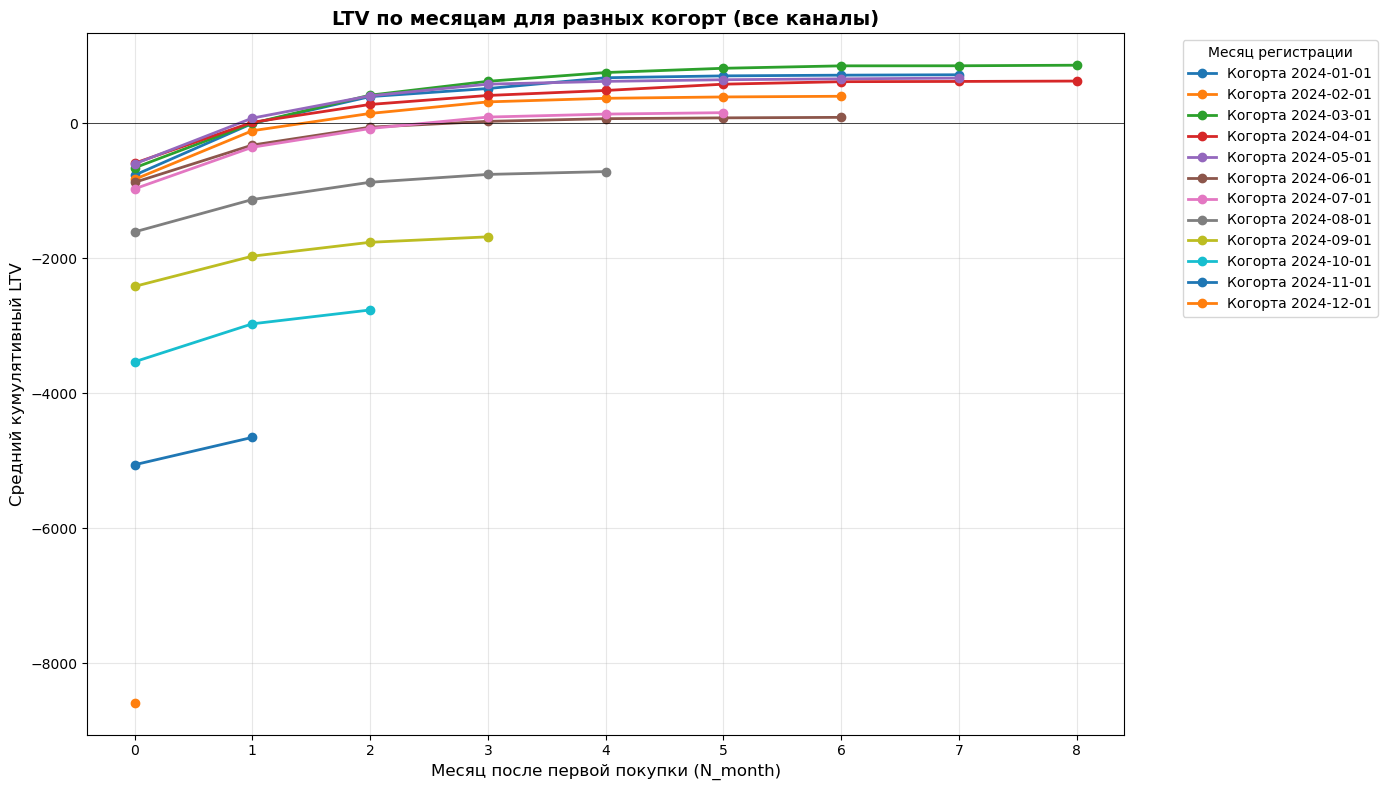

In [47]:
# Считаем изначальный размер каждой когорты (по всем пользователям)
cohort_size = df_LTV.groupby(['first_month', 'acq_channel'])['user_id'].nunique().reset_index()
cohort_size.columns = ['first_month', 'acq_channel', 'initial_cohort_size']

# Суммируем общий доход (PNL) по когортам
cohort_revenue = df_LTV.groupby(['first_month', 'acq_channel', 'N_month'])['PNL'].sum().reset_index()
cohort_revenue.columns = ['first_month', 'acq_channel', 'N_month', 'total_PNL']  # переименуем для ясности

# Объединяем и считаем средний LTV
cohort_analysis = pd.merge(cohort_revenue, cohort_size, on=['first_month', 'acq_channel'])
cohort_analysis['avg_LTV'] = cohort_analysis['total_PNL'] / cohort_analysis['initial_cohort_size']

# Кумулятивная сумма по месяцам
cohort_analysis = cohort_analysis.sort_values(['first_month', 'acq_channel', 'N_month'])
cohort_analysis['cumulative_avg_LTV'] = cohort_analysis.groupby(['first_month', 'acq_channel'])['avg_LTV'].cumsum()

# Для общего графика по всем когортам (без разделения по каналам)
# Суммируем PNL по всем каналам
cohort_PNL_total = df_LTV.groupby(['first_month', 'N_month'])['PNL'].sum().reset_index()
cohort_PNL_total.columns = ['first_month', 'N_month', 'total_PNL']

# Размер когорт (уникальные пользователи по месяцам)
cohort_size_total = df_LTV.groupby('first_month')['user_id'].nunique().reset_index()
cohort_size_total.columns = ['first_month', 'initial_cohort_size']

# Объединяем
cohort_analysis_total = pd.merge(cohort_PNL_total, cohort_size_total, on='first_month')
cohort_analysis_total['avg_LTV'] = cohort_analysis_total['total_PNL'] / cohort_analysis_total['initial_cohort_size']

# Сортируем и считаем кумулятивную сумму
cohort_analysis_total = cohort_analysis_total.sort_values(['first_month', 'N_month'])
cohort_analysis_total['cumulative_avg_LTV'] = cohort_analysis_total.groupby('first_month')['avg_LTV'].cumsum()

# Создадим график (используем cohort_analysis_total для общего графика)
plt.figure(figsize=(14, 8))

# Выберем когорты для расчёта (например, первые 12 месяцев регистрации)
first_months = sorted(cohort_analysis_total['first_month'].unique())[:12]

# Построим линии для каждого first_month (когорты)
for month in first_months:
    df_plot = cohort_analysis_total[cohort_analysis_total['first_month'] == month] 
    month_label = pd.Timestamp(month).date()
    plt.plot(df_plot['N_month'], df_plot['cumulative_avg_LTV'], 
             marker='o', label=f'Когорта {month_label}', linewidth=2, markersize=6)

# Добавим заголовок и подписи осей
plt.title('LTV по месяцам для разных когорт (все каналы)', fontsize=14, fontweight='bold')
plt.xlabel('Месяц после первой покупки (N_month)', fontsize=12)
plt.ylabel('Средний кумулятивный LTV', fontsize=12)
plt.legend(title='Месяц регистрации', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)  # Линия нуля
plt.tight_layout()
plt.show()

acq_channel
Google Ads         3187
Affiliate          2338
Social Media       1211
SEO                 874
TikTok              719
Email Marketing     325
Name: user_id, dtype: int64

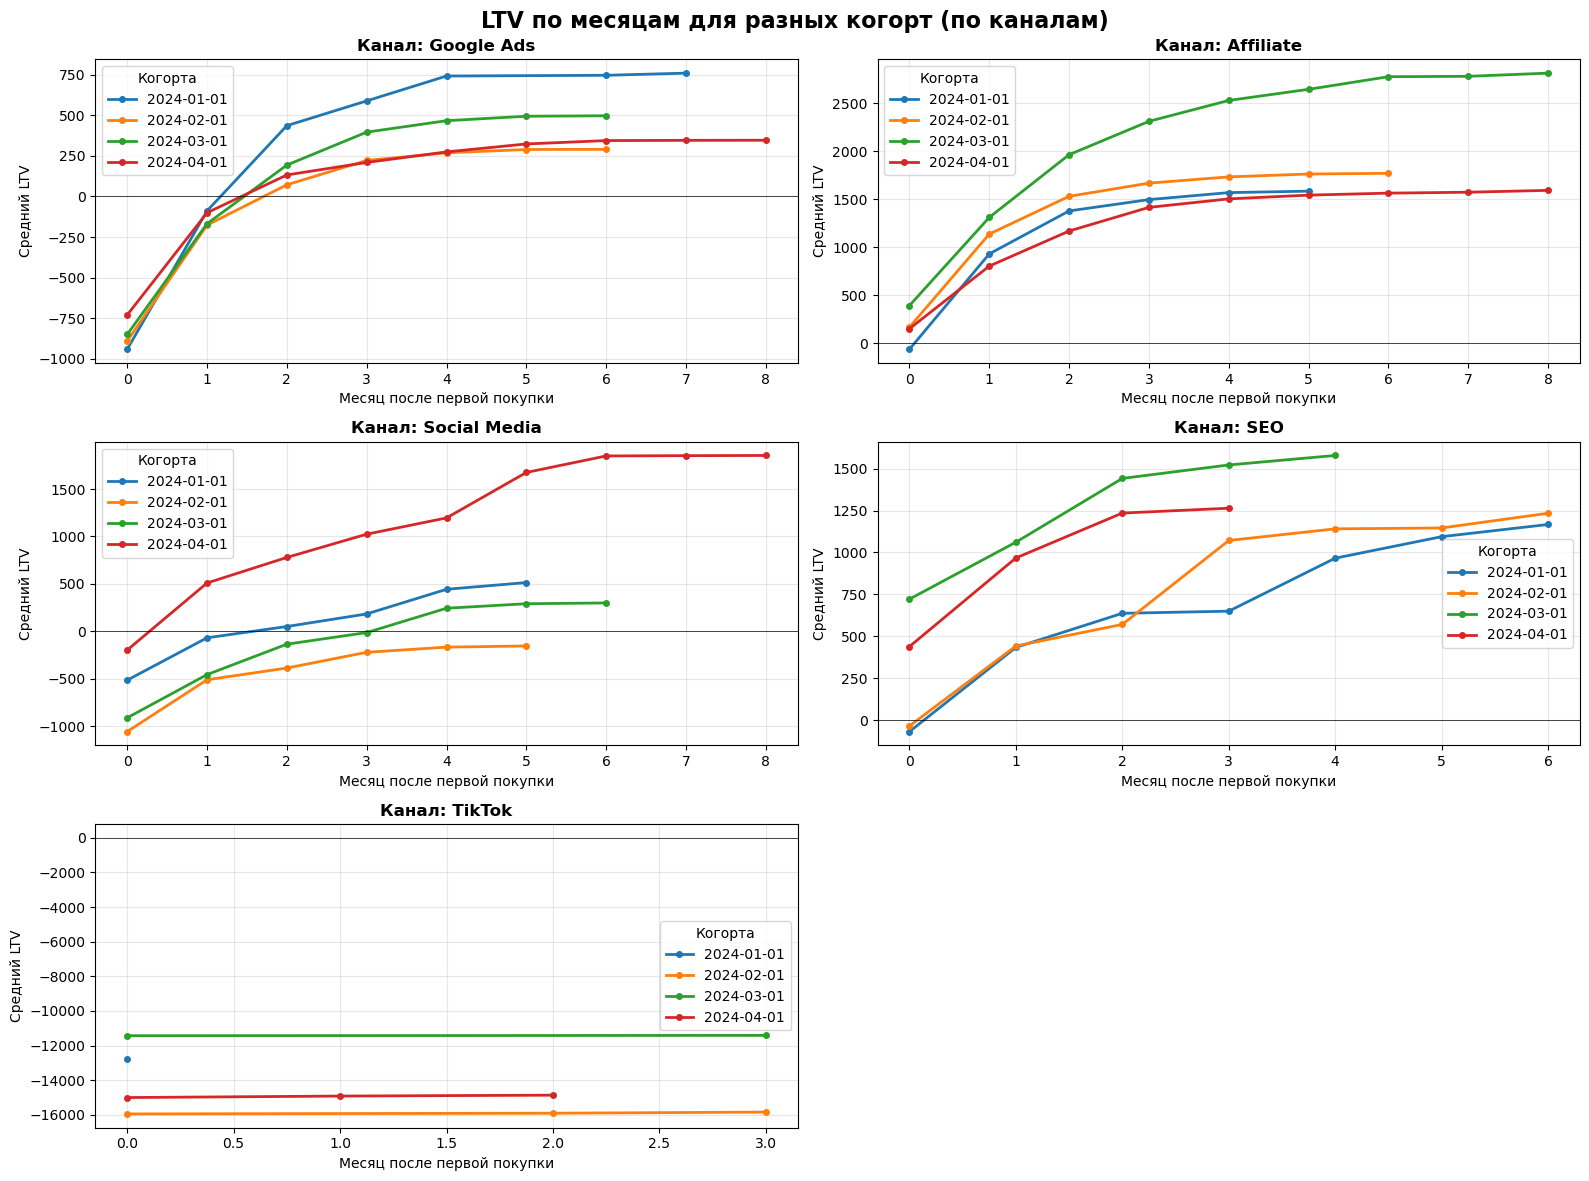

In [48]:
channel_sizes = df_LTV.groupby('acq_channel')['user_id'].nunique().sort_values(ascending=False)
display(channel_sizes)

# Выберем топ-5 каналов по количеству пользователей
top_channels = channel_sizes.head(5).index.tolist()

# Создадим отдельный график для топ каналов
if top_channels:  # проверяем, что есть каналы
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, channel in enumerate(top_channels[:5]):  # максимум 5 каналов на графике
        if idx < len(axes):
            channel_data = cohort_analysis[cohort_analysis['acq_channel'] == channel]
            
            if len(channel_data) > 0:  # проверяем, что есть данные по каналу
                # Берем несколько когорт для этого канала
                channel_cohorts = sorted(channel_data['first_month'].unique())[:4]  # первые 4 когорты
                
                for month in channel_cohorts:
                    df_plot = channel_data[channel_data['first_month'] == month]
                    month_label = pd.Timestamp(month).date()
                    if len(df_plot) > 0:
                        axes[idx].plot(df_plot['N_month'], df_plot['cumulative_avg_LTV'], 
                                      marker='o', label=f'{month_label}', linewidth=2, markersize=4)
                
                axes[idx].set_title(f'Канал: {channel}', fontsize=12, fontweight='bold')
                axes[idx].set_xlabel('Месяц после первой покупки')
                axes[idx].set_ylabel('Средний LTV')
                axes[idx].legend(title='Когорта')
                axes[idx].grid(True, alpha=0.3)
                axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Убираем лишние оси
    for idx in range(len(top_channels[:6]), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('LTV по месяцам для разных когорт (по каналам)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

Средний конечный LTV: -1,238.23 - в среднем когорта приносит убыток.  
Медианный конечный LTV: 124.78 - половина когорт все же прибыльна.  
Разброс: от -8,582.97 до 862.71 - огромная вариативность между когортами.  
7 из 12 когорт прибыльны (58%)  
5 из 12 когорт убыточны (42%)   
Одна когорта с огромным убытком (-8,583) тянет среднее вниз.  
Четко виден переломный момент в августе 2024.  
Январь-июль 2024: все когорты прибыльны, август-декабрь 2024: все когорты убыточны.  
Убытки растут: от -714 в августе до -8,583 в декабре.  
В августе 2024 началась агрессивная кампания в TikTok с CAC 23,964, что уничтожило рентабельность.

In [49]:
# Рассчитаем final_ltv_by_cohort - финальный LTV для каждой когорты
final_ltv_by_cohort = cohort_analysis_total.groupby('first_month')['cumulative_avg_LTV'].last()
final_ltv_by_cohort = final_ltv_by_cohort.sort_index()

# Найдем проблемные когорты
problem_cohorts = final_ltv_by_cohort[final_ltv_by_cohort < 0]
display("отрицательный LTV:")
for cohort, ltv in problem_cohorts.sort_values().items():
    display(f"  {cohort.date()}: LTV = {ltv:,.2f}")

# Найдем успешные когорты
success_cohorts = final_ltv_by_cohort[final_ltv_by_cohort > 0]
display("положительный LTV:")
for cohort, ltv in success_cohorts.sort_values(ascending=False).items():
    display(f"  {cohort.date()}: LTV = {ltv:,.2f}")

# Анализ по месяцам регистрации
display("по месяцу регистрации:")
monthly_stats = cohort_analysis_total.groupby('first_month').agg({
    'initial_cohort_size': 'first',
    'cumulative_avg_LTV': 'last'
}).sort_index()

for month, row in monthly_stats.iterrows():
    status = "Прибыль" if row['cumulative_avg_LTV'] > 0 else "Убыток"
    display(f"  {month.date()}: {status:15} LTV = {row['cumulative_avg_LTV']:8.2f}, Размер = {row['initial_cohort_size']:4} чел.")

'отрицательный LTV:'

'  2024-12-01: LTV = -8,582.97'

'  2024-11-01: LTV = -4,652.34'

'  2024-10-01: LTV = -2,764.49'

'  2024-09-01: LTV = -1,680.54'

'  2024-08-01: LTV = -713.59'

'положительный LTV:'

'  2024-03-01: LTV = 862.71'

'  2024-01-01: LTV = 721.22'

'  2024-05-01: LTV = 671.49'

'  2024-04-01: LTV = 627.76'

'  2024-02-01: LTV = 402.42'

'  2024-07-01: LTV = 159.51'

'  2024-06-01: LTV = 90.05'

'по месяцу регистрации:'

'  2024-01-01: Прибыль         LTV =   721.22, Размер = 439.0 чел.'

'  2024-02-01: Прибыль         LTV =   402.42, Размер = 649.0 чел.'

'  2024-03-01: Прибыль         LTV =   862.71, Размер = 852.0 чел.'

'  2024-04-01: Прибыль         LTV =   627.76, Размер = 901.0 чел.'

'  2024-05-01: Прибыль         LTV =   671.49, Размер = 906.0 чел.'

'  2024-06-01: Прибыль         LTV =    90.05, Размер = 709.0 чел.'

'  2024-07-01: Прибыль         LTV =   159.51, Размер = 914.0 чел.'

'  2024-08-01: Убыток          LTV =  -713.59, Размер = 881.0 чел.'

'  2024-09-01: Убыток          LTV = -1680.54, Размер = 732.0 чел.'

'  2024-10-01: Убыток          LTV = -2764.49, Размер = 606.0 чел.'

'  2024-11-01: Убыток          LTV = -4652.34, Размер = 528.0 чел.'

'  2024-12-01: Убыток          LTV = -8582.97, Размер = 537.0 чел.'

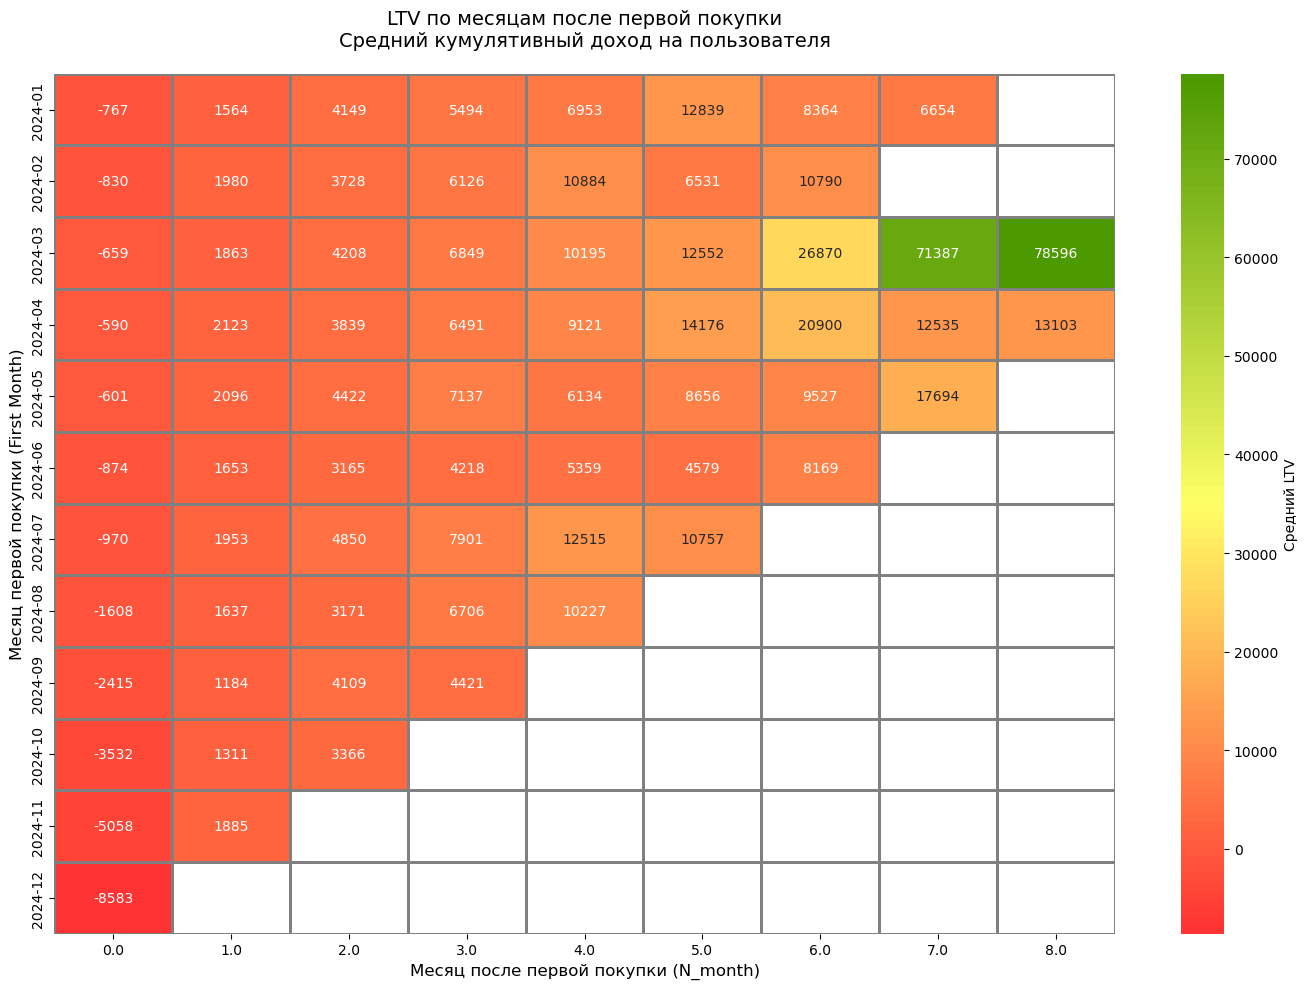

In [50]:
# Сгруппируем по first_month и N_month и рассчитаем средний LTV
df_grouped = df_LTV.groupby(['first_month', 'N_month'])['LTV'].mean().reset_index()

# Ограничим количество месяцев для анализа
max_months = 12
df_grouped = df_grouped[df_grouped['N_month'] <= max_months]

# Пивотируем данные, чтобы first_month были индексами, а N_month — столбцами
df_pivot = df_grouped.pivot(index='first_month', columns='N_month', values='LTV')

# Сортируем когорты по дате
df_pivot = df_pivot.sort_index()

# Конвертируем даты в строки для отображения
df_pivot.index = df_pivot.index.strftime('%Y-%m')

# Заменим нули на NaN для корректной отрисовки
df_pivot[df_pivot == 0] = float('nan')

# Создаем кастомную цветовую карту
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

plt.figure(figsize=(14, 10))
# Построим heatmap
sns.heatmap(df_pivot,
           cmap=cmap,
           annot=True,
           fmt='.0f',
           linewidths=1,
           linecolor='gray',
           cbar_kws={'label': 'Средний LTV'},
           annot_kws={"size": 10})

# Добавим заголовок и подписи осей
plt.title('LTV по месяцам после первой покупки\nСредний кумулятивный доход на пользователя', fontsize=14, pad=20)
plt.xlabel('Месяц после первой покупки (N_month)', fontsize=12)
plt.ylabel('Месяц первой покупки (First Month)', fontsize=12)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

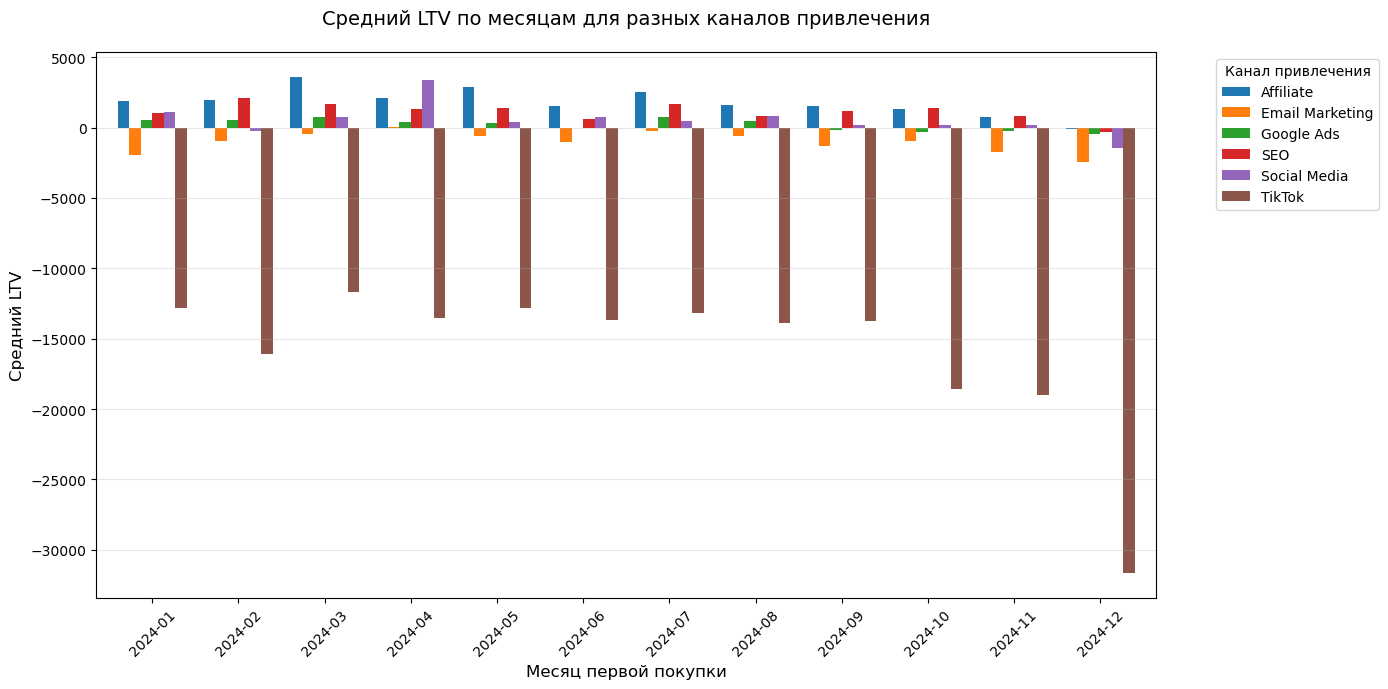

In [51]:
# Для каждого канала и месяца посчитаем средний LTV
df_grouped_channel = df_LTV.groupby(['first_month', 'acq_channel'])['LTV'].mean().reset_index()

# Используем pivot для отображения LTV каждого канала в виде отдельного столбца
df_pivot_channel = df_grouped_channel.pivot(index='first_month', columns='acq_channel', values='LTV')

# Сортируем по дате
df_pivot_channel = df_pivot_channel.sort_index()

# Конвертируем даты в строки
df_pivot_channel.index = df_pivot_channel.index.strftime('%Y-%m')

# Построим barplot
plt.figure(figsize=(14, 7))
df_pivot_channel.plot(kind='bar', figsize=(14, 7), width=0.8)

plt.title('Средний LTV по месяцам для разных каналов привлечения', fontsize=14, pad=20)
plt.xlabel('Месяц первой покупки', fontsize=12)
plt.ylabel('Средний LTV', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Канал привлечения', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [52]:
display(df_grouped_channel)

,first_month,acq_channel,LTV
0,2024-01-01,Affiliate,1902.000499
1,2024-01-01,Email Marketing,-1935.068813
2,2024-01-01,Google Ads,553.769178
3,2024-01-01,SEO,1042.627705
4,2024-01-01,Social Media,1131.642406
...,...,...,...
67,2024-12-01,Email Marketing,-2460.441236
68,2024-12-01,Google Ads,-489.712999
69,2024-12-01,SEO,-285.395425
70,2024-12-01,Social Media,-1465.071944


In [53]:
# получим средний LTV по когортам и каналам
ltv_by_cohort_channel = df_LTV.groupby(['first_month', 'acq_channel', 'N_month']).agg({
    'LTV': 'mean',
    'user_id': 'count'
}).reset_index()

ltv_by_cohort_channel.columns = ['first_month', 'acq_channel', 'N_month', 'avg_LTV', 'user_count']

# Используем данные о CAC из ранее созданной таблицы cac_by_channel
# Преобразуем month в cac_by_channel к timestamp
cac_data = cac_by_channel[['acq_channel', 'month', 'CAC']].copy()
cac_data['first_month'] = cac_data['month'].dt.to_timestamp()
cac_data = cac_data.drop('month', axis=1)

# Объединяем с LTV данными
df_roi = pd.merge(ltv_by_cohort_channel, cac_data,
                  on=['first_month', 'acq_channel'], how='left')

# Заполняем пропущенные значения CAC (например, для когорт без маркетинговых расходов)
# Используем средний CAC по каналу
avg_cac_by_channel = cac_data.groupby('acq_channel')['CAC'].mean()
for channel in df_roi['acq_channel'].unique():
    mask = (df_roi['acq_channel'] == channel) & (df_roi['CAC'].isna())
    if channel in avg_cac_by_channel.index:
        df_roi.loc[mask, 'CAC'] = avg_cac_by_channel[channel]
    else:
        df_roi.loc[mask, 'CAC'] = df_roi['CAC'].mean()

display(f"Размер датафрейма для ROI анализа: {df_roi.shape}")
display(f"Уникальных когорт: {df_roi['first_month'].nunique()}")
display(f"Уникальных каналов: {df_roi['acq_channel'].nunique()}")

'Размер датафрейма для ROI анализа: (312, 6)'

'Уникальных когорт: 12'

'Уникальных каналов: 6'

In [54]:
# Вычисление ROI
df_roi["ROI"] = np.where(
    df_roi["CAC"] > 0,
    (df_roi["avg_LTV"] - df_roi["CAC"]) / df_roi["CAC"] * 100,
    0  # Если CAC = 0, ROI не определен, ставим 0
)

display(df_roi[['first_month', 'acq_channel', 'N_month', 'avg_LTV', 'CAC', 'ROI']].head(10))

,first_month,acq_channel,N_month,avg_LTV,CAC,ROI
0,2024-01-01,Affiliate,0.0,-61.327252,879.134252,-106.975869
1,2024-01-01,Affiliate,1.0,3210.092916,879.134252,265.142515
2,2024-01-01,Affiliate,2.0,7229.635926,879.134252,722.358577
3,2024-01-01,Affiliate,3.0,10651.373120,879.134252,1111.575262
4,2024-01-01,Affiliate,4.0,6680.987328,879.134252,659.950748
5,2024-01-01,Affiliate,5.0,7395.613248,879.134252,741.238210
6,2024-01-01,Email Marketing,0.0,-1935.068813,1770.544500,-209.292300
7,2024-01-01,Google Ads,0.0,-941.162202,1442.978898,-165.223560
8,2024-01-01,Google Ads,1.0,1149.848928,1442.978898,-20.314224
9,2024-01-01,Google Ads,2.0,3185.334754,1442.978898,120.747147



Канал: Affiliate
----------------------------------------


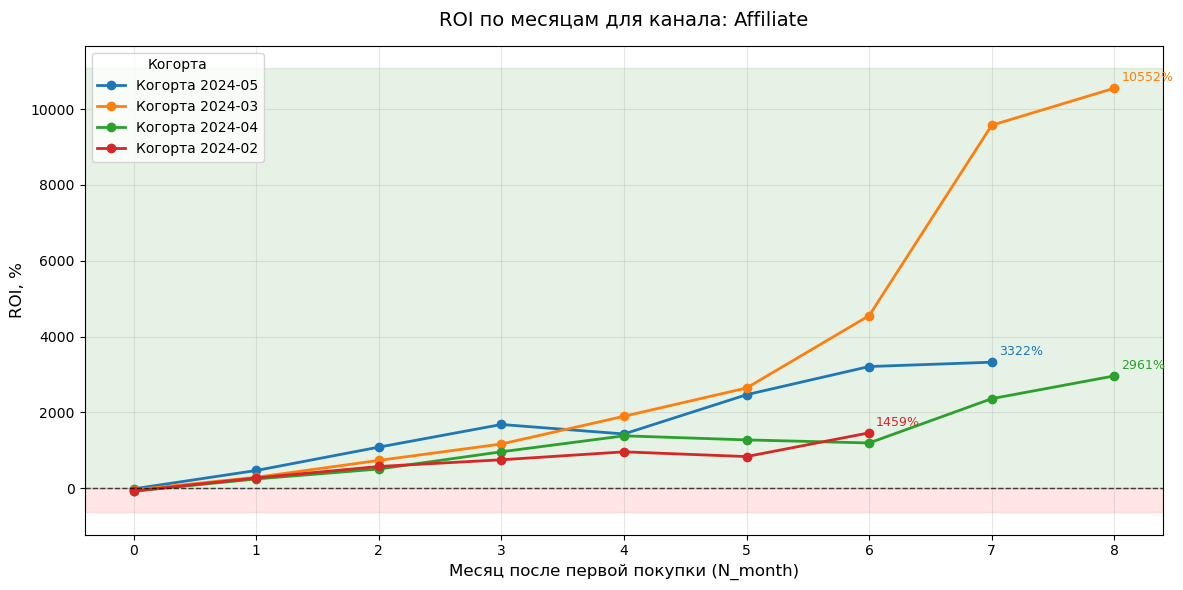


Канал: Google Ads
----------------------------------------


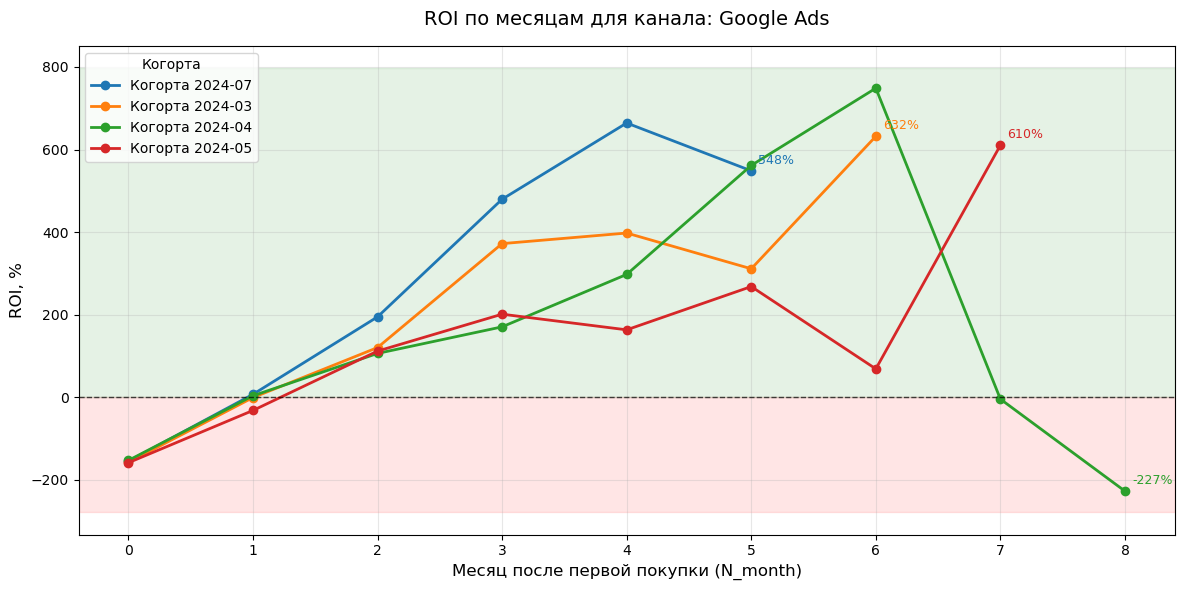


Канал: Social Media
----------------------------------------


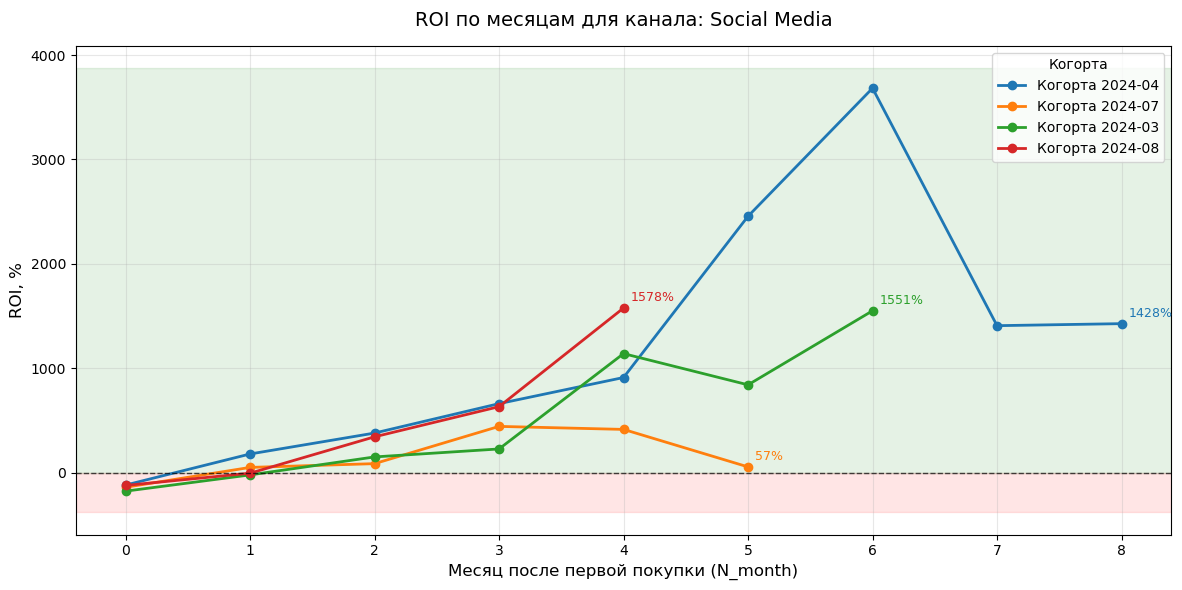

In [55]:
# ВИЗУАЛИЗАЦИЯ ROI ПО КОГОРТАМ

# Выберем топ-3 канала для анализа
top_channels = df_roi['acq_channel'].value_counts().head(3).index.tolist()

# Для каждого канала создадим отдельный график
for channel in top_channels:
    print(f"\nКанал: {channel}")
    print("-" * 40)
    
    df_channel = df_roi[df_roi['acq_channel'] == channel]
    
    # Найдем когорты с наибольшим количеством пользователей
    top_cohorts = df_channel.groupby('first_month')['user_count'].sum().nlargest(4).index
    
    if len(top_cohorts) > 0:
        # Создаем график
        plt.figure(figsize=(12, 6))
        
        # Определяем цвета для разных когорт
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        
        for i, cohort in enumerate(top_cohorts):
            if i >= len(colors):
                break
                
            df_plot = df_channel[df_channel['first_month'] == cohort].sort_values('N_month')
            
            if not df_plot.empty:
                # Форматируем дату для легенды
                cohort_label = cohort.strftime('%Y-%m')
                
                plt.plot(df_plot['N_month'], df_plot['ROI'], 
                        marker='o', linewidth=2, color=colors[i],
                        label=f'Когорта {cohort_label}')
                
                # Добавляем аннотацию для последней точки
                last_point = df_plot.iloc[-1]
                plt.annotate(f'{last_point["ROI"]:.0f}%', 
                            xy=(last_point['N_month'], last_point['ROI']),
                            xytext=(5, 5), textcoords='offset points',
                            fontsize=9, color=colors[i])
        
        # Добавляем линию окупаемости (ROI = 0%)
        plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
        
        # Оформляем график
        plt.title(f'ROI по месяцам для канала: {channel}', fontsize=14, pad=15)
        plt.xlabel('Месяц после первой покупки (N_month)', fontsize=12)
        plt.ylabel('ROI, %', fontsize=12)
        plt.legend(title='Когорта', fontsize=10)
        plt.grid(True, alpha=0.3)
        
        # Добавляем заливку для положительного ROI
        plt.axhspan(0, plt.ylim()[1], alpha=0.1, color='green', label='Окупаемость')
        plt.axhspan(plt.ylim()[0], 0, alpha=0.1, color='red', label='Убыточность')
        
        plt.tight_layout()
        plt.show()


Канал: Affiliate


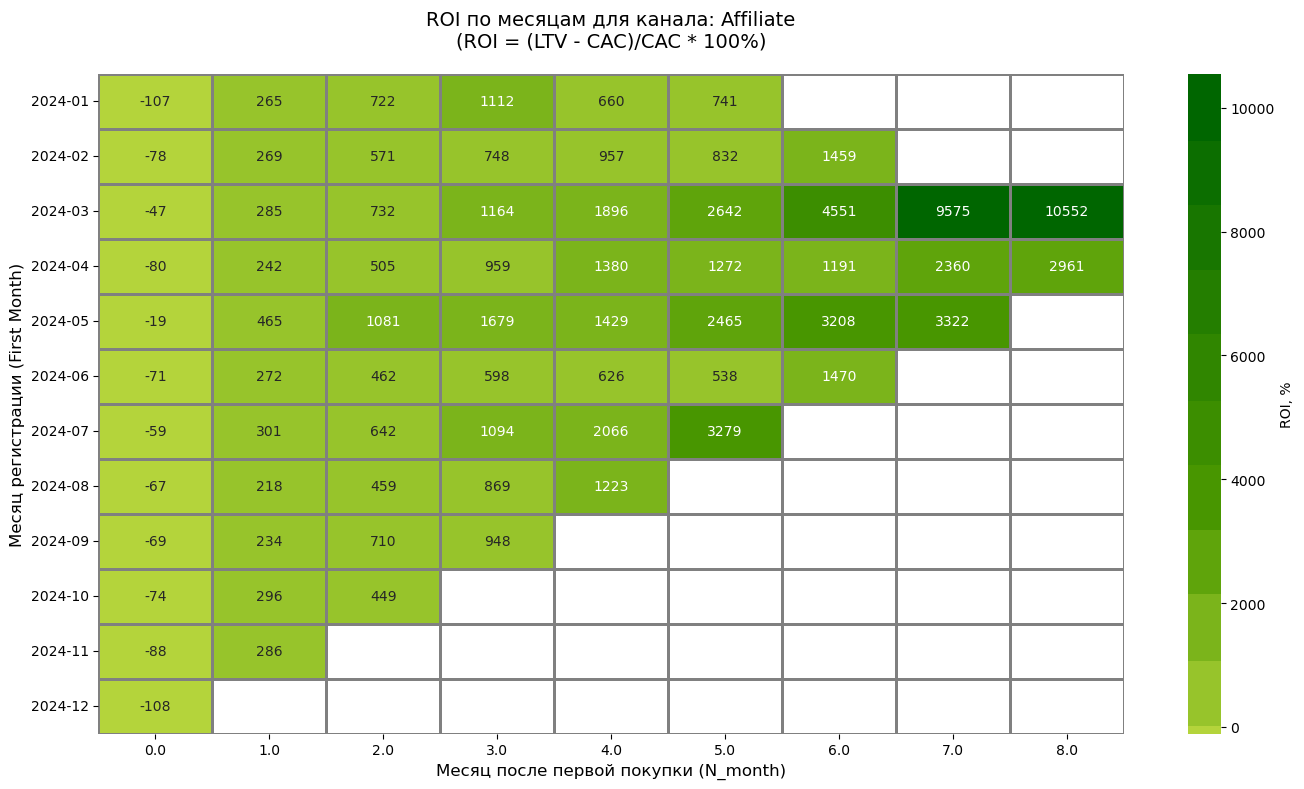


Канал: Google Ads


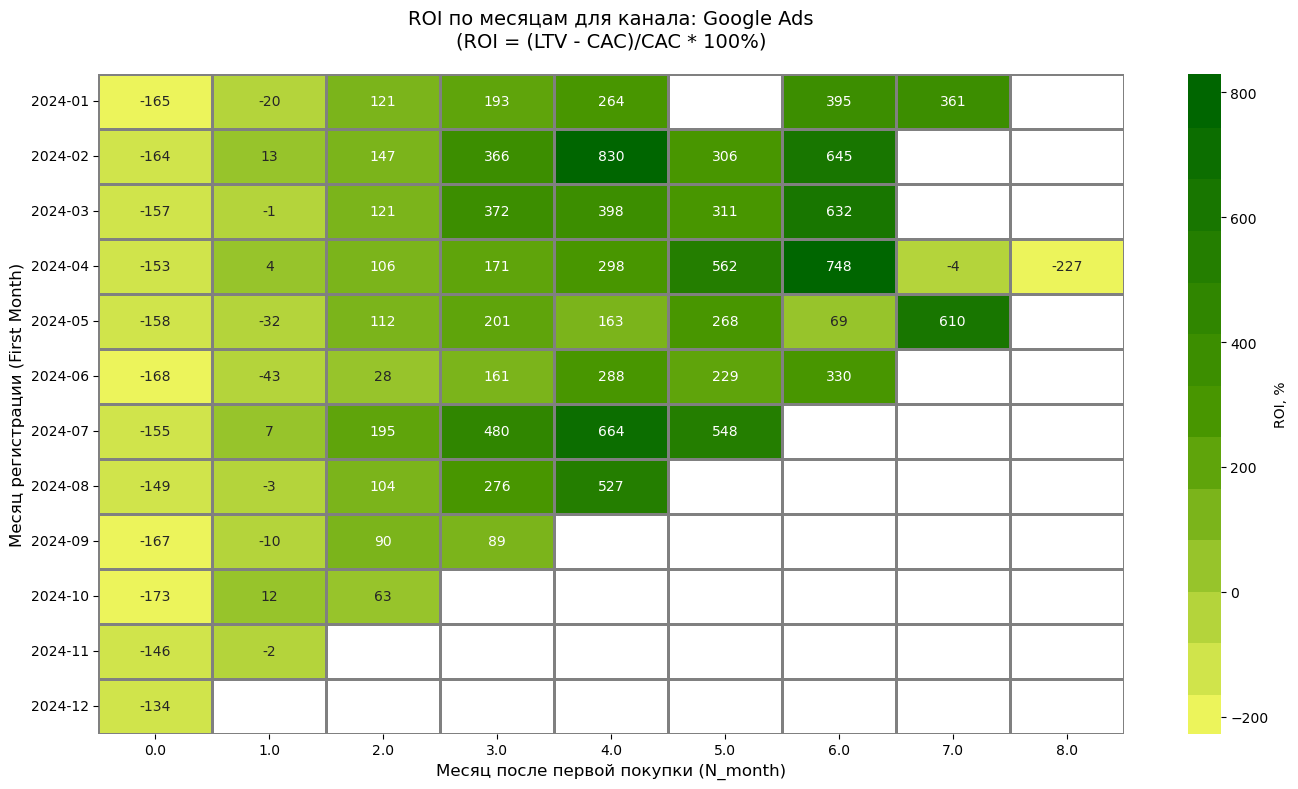


Канал: Social Media


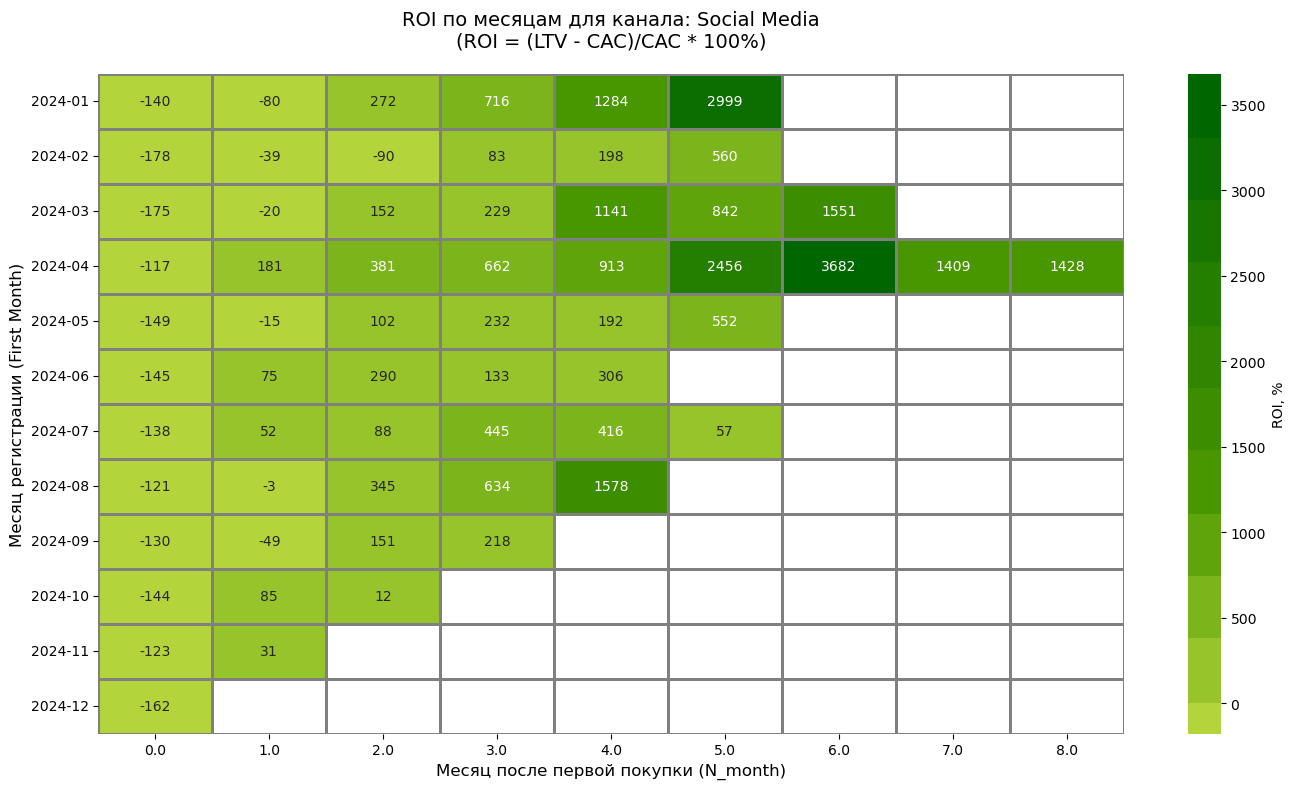

In [56]:
# Создаем heatmap для каждого из топ-каналов
for channel in top_channels:
    print(f"\nКанал: {channel}")
    
    df_channel = df_roi[df_roi['acq_channel'] == channel]
    
    # Группируем по когортам и месяцам
    df_grouped = df_channel.groupby(['first_month', 'N_month'])['ROI'].mean().reset_index()
    
    # Ограничиваем анализ первыми 12 месяцами
    df_grouped = df_grouped[df_grouped['N_month'] <= 12]
    
    # Пивотируем данные для heatmap
    df_pivot = df_grouped.pivot(index='first_month', columns='N_month', values='ROI')
    
    # Сортируем когорты по дате
    df_pivot = df_pivot.sort_index()
    
    # Конвертируем даты в строки для отображения
    df_pivot.index = df_pivot.index.strftime('%Y-%m')
    
    # Создаем кастомную цветовую карту
    cmap = mcolors.LinearSegmentedColormap.from_list('red_green', 
                                                     ['#FF3333', '#FFFF66', '#4C9900', '#006600'], N=20)
    
    # Создаем heatmap
    plt.figure(figsize=(14, 8))
    
    sns.heatmap(df_pivot,
                cmap=cmap,
                annot=True,
                fmt='.0f',
                linewidths=1,
                linecolor='gray',
                cbar_kws={'label': 'ROI, %'},
                annot_kws={"size": 10},
                center=0)  # Центрируем на 0
    
    plt.title(f'ROI по месяцам для канала: {channel}\n(ROI = (LTV - CAC)/CAC * 100%)', 
              fontsize=14, pad=20)
    plt.xlabel('Месяц после первой покупки (N_month)', fontsize=12)
    plt.ylabel('Месяц регистрации (First Month)', fontsize=12)
    
    plt.tight_layout()
    plt.show()


Канал: Affiliate
----------------------------------------


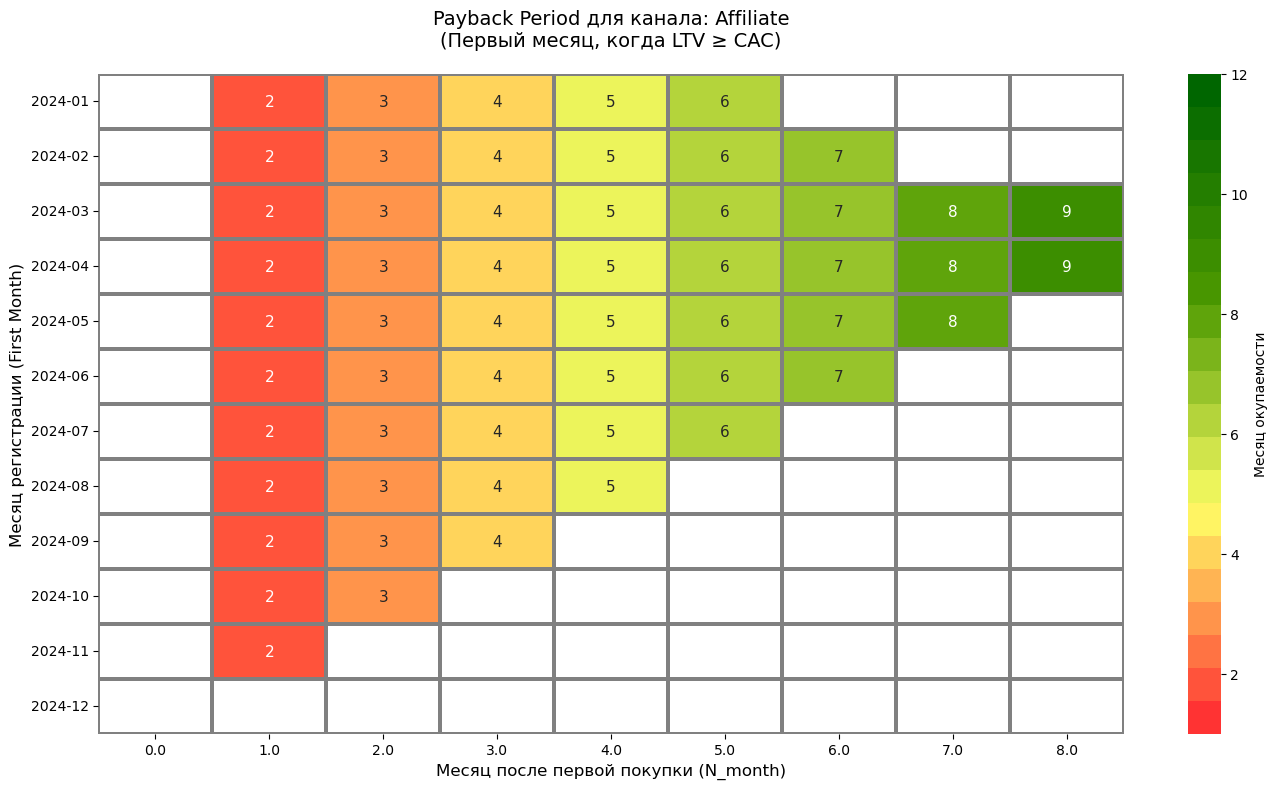


Канал: Google Ads
----------------------------------------


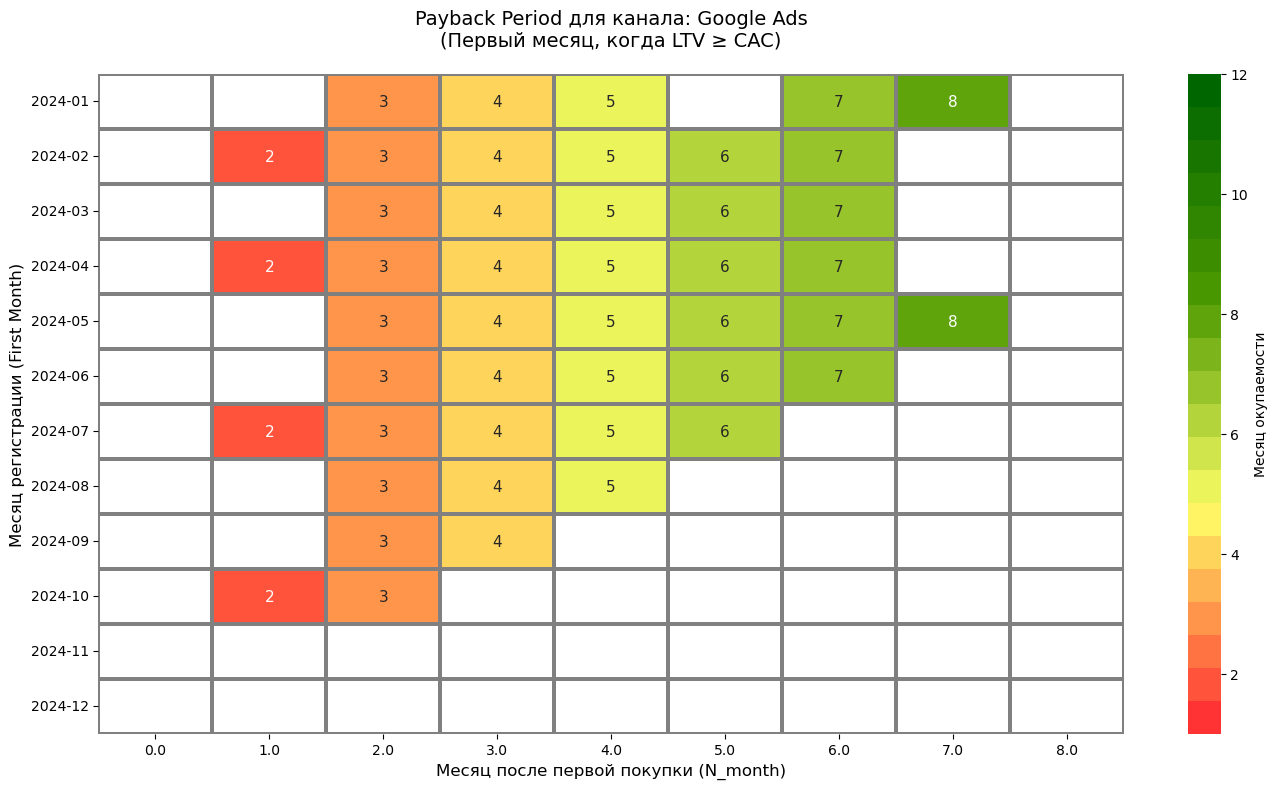


Канал: Social Media
----------------------------------------


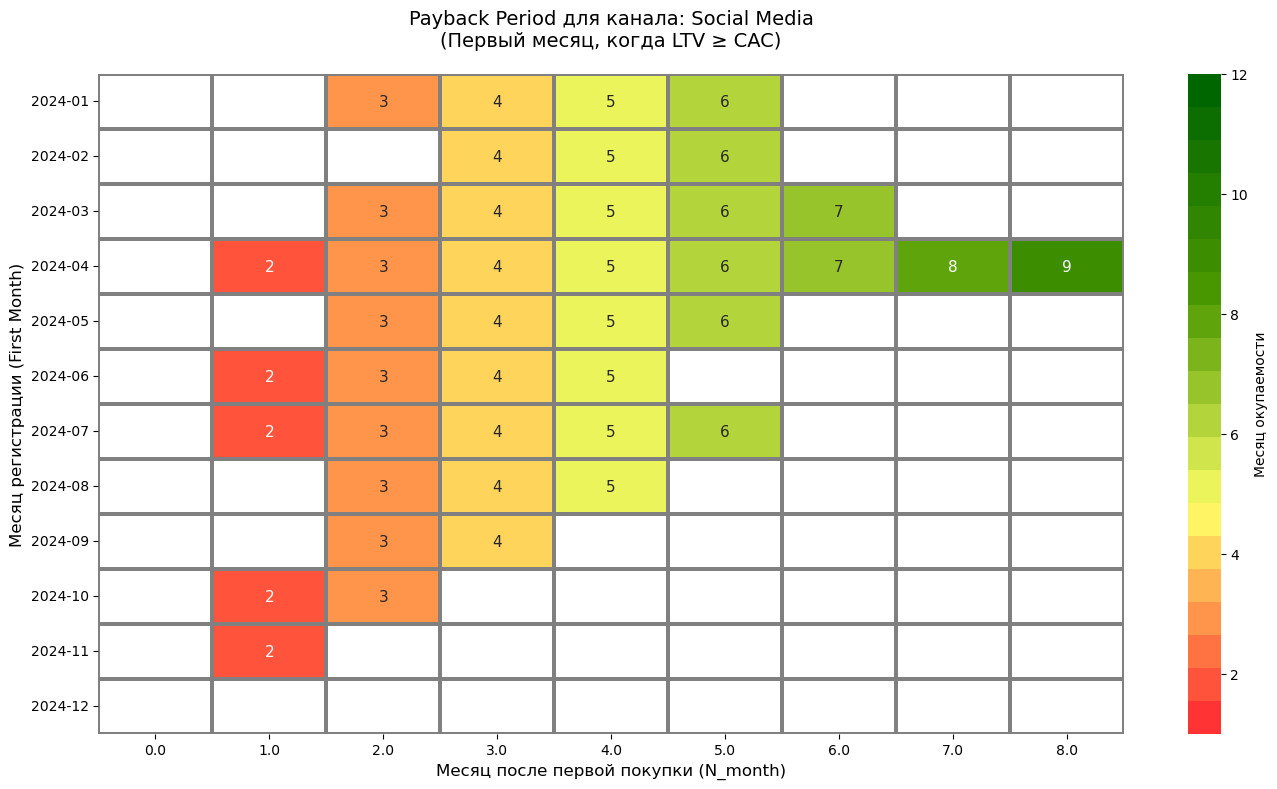

In [57]:
# Для каждой когорты рассчитаем среднее значение LTV и CAC
df_grouped = df_roi.groupby(['first_month', 'acq_channel', 'N_month'])[['avg_LTV', 'CAC']].mean().reset_index()
df_grouped = df_grouped.rename(columns={'avg_LTV': 'LTV'})

# Выберем топ каналы для анализа Payback Period
payback_channels = df_grouped['acq_channel'].value_counts().head(3).index.tolist()

for channel in payback_channels:
    print(f"\nКанал: {channel}")
    print("-" * 40)
    
    # Отфильтруем канал
    df_grouped_channel = df_grouped[df_grouped['acq_channel'] == channel].copy()
    
    # Рассчитаем Payback Period
    df_grouped_channel['Payback_Period'] = df_grouped_channel.apply(
        lambda row: row['N_month'] + 1 if row['LTV'] >= row['CAC'] else 0,
        axis=1
    )
    
    # Пивотируем данные для heatmap
    df_pivot = df_grouped_channel.pivot(index='first_month', columns='N_month', values='Payback_Period')
    
    # Сортируем когорты по дате
    df_pivot = df_pivot.sort_index()
    
    # Конвертируем даты в строки
    try:
        df_pivot.index = df_pivot.index.strftime('%Y-%m')
    except:
        pass
    
    # Заменяем 0 на NaN для лучшей визуализации
    df_pivot_display = df_pivot.replace(0, np.nan)
    
    # Создаем кастомную цветовую карту
    cmap = mcolors.LinearSegmentedColormap.from_list('green_red', 
                                                     ['#FF3333', '#FFFF66', '#4C9900', '#006600'], N=20)
    
    # Построим heatmap
    plt.figure(figsize=(14, 8))
    
    # Маска для значений NaN
    mask = df_pivot_display.isna()
    
    sns.heatmap(df_pivot_display,
                cmap=cmap,
                annot=True,
                fmt='.0f',
                linewidths=1.5,
                linecolor='gray',
                cbar_kws={'label': 'Месяц окупаемости'},
                annot_kws={"size": 11},
                mask=mask,
                vmin=1,
                vmax=12)
    
    plt.title(f'Payback Period для канала: {channel}\n(Первый месяц, когда LTV ≥ CAC)', 
              fontsize=14, pad=20)
    plt.xlabel('Месяц после первой покупки (N_month)', fontsize=12)
    plt.ylabel('Месяц регистрации (First Month)', fontsize=12)
    
    plt.tight_layout()
    plt.show()

Проблема: рост CAC  
CAC вырос с 1,392.55 в январе до 7,092.60 в декабре (в 5.1 раза). Основной драйвер роста - канал TikTok (CAC до 23,963.80).  
С августа 2024 все новые когорты стали убыточными.  
Экономика бизнеса на грани рентабельности. LTV/CAC = 1.14 - минимально приемлемое значение, ROI = 13.8% - низкая рентабельность.  
ROI канала Google Ads резко упал на 7 месяц.  
Средний доход на пользователя отрицательный (-913.24).  
Проблема конверсии - только 20.2% пользователей совершают покупки. 35,229 из 44,151 пользователей (79.8%) не приносят дохода, но на их привлечение были затрачены средства.  
Прибыльные каналы (на примере января): Affiliate (LTV = 1,902.00), SEO (LTV = 1,042.63), Social Media (LTV = 1,131.64).  
Проблемные каналы: TikTok (LTV = -31,636.42 (декабрь)). Email Marketing: убыточность с начала года.  
Payback Period анализ:  
Для большинства прибыльных каналов окупаемость наступает на 1-3 месяц. Каналы с быстрой окупаемостью: Affiliate, SEO. 
Каналы с медленной/отсутствующей окупаемостью: TikTok, Email Marketing.  
Рекомендации:  
Остановить инвестиции в TikTok или пересмотреть стратегию. Снизить CAC в остальных каналах. Увеличить конверсию с 20.2% до 25-30%. Бизнес находится в зоне риска из-за экспоненциального роста CAC. Необходимы срочные меры по оптимизации маркетинговых расходов и увеличению конверсии.

## Выводы по этапам 2 и 3


Представьте ключевые выводы в текстовом виде здесь или приложите ссылку на документ с презентацией.

Не забудьте предоставить доступ на просмотр и комментирование документа.

Парадоксальная ситуация: успешный продукт, но убыточная экономика.  

Высокий средний чек (AOV) 14,030, мощный рост выручки (+106.9% за год) — 22 млн выручки, отличная конверсия в воронке (98.5% кликов после просмотра), лояльная аудитория (3,097 MAU, 8,922 платящих пользователей). 

Критические проблемы (экономика): экспоненциальный рост CAC (×5.1 с января по декабрь), все когорты с августа 2024 убыточны, 
LTV/CAC = 1.14 — минимальный порог рентабельности, средний доход на пользователя: -913.  
Корень проблемы: маркетинговая стратегия TikTok (CAC TikTok: до 23,964 (декабрь), LTV TikTok: -31,636 ₽ (декабрь)).  
Каждый пользователь из TikTok приносит убыток 31,636, временная точка перелома: август 2024.  
До августа все когорты прибыльны, после августа все когорты убыточны. Совпадает с масштабированием неэффективных каналов.  
ROI канала Google Ads резко упал на 7 месяц.
Структурная проблема: низкая частота взаимодействия - Stickiness 9.9% — только 10% пользователей возвращаются ежедневно, 
DAU 306 при MAU 3,097 — 90% пользователей заходят реже 1 раза в день. Продукт не удерживает ежедневное внимание.  

Высокая конверсия до покупки (98.5%), критическое падение на финальном этапе: -35.8% (оформление - покупка). Низкая частота покупок при высоком среднем чеке.  

Затраты > Доходов для новых пользователей: CAC 2,166 на покупателя, ARPPU: 2,466 (прибыль всего 300).  
Но 79.8% привлеченных вообще не покупают. Фактический CAC на всех пользователей: 438.  
ARPU: 498 (прибыль всего 60 на пользователя).  

Рекомендации:  
Остановить инвестиции в TikTok, аудит всех каналов — оставить только с ROI > 100%, фиксировать CAC на уровне ≤ 1,500.  
Исправить потерю 35.8% на этапе покупки (упростить оформление заказа, внедрить больше способов оплаты, проверить способы оплаты). 
Push-уведомления о статусе заказов, персональные рекомендации, программа лояльности.  

Срочно остановить потери в TikTok, исправить воронку покупки, и бизнес быстро вернется к прибыльности.

## 4. Поиск инсайтов, точек роста и сегментация


После того как вы провели верхнеуровневую оценку данных, самое время переходить от общей картины к точечным наблюдениям. Посмотрите вглубь данных: по каналам,
сегментам пользователей, категориям товаров, регионам, типам устройств. Ищите
закономерности, различия, аномалии.

Цель — сформировать обоснованные гипотезы:

* какие сегменты работают лучше остальных
* какие сегменты работают хуже остальных
* на каких этапах воронки теряются пользователи
* какие группы можно или нужно масштабировать
* куда стоит инвестировать больше внимания или ресурсов

По итогам анализа также:

* сформулируйте в виде аналитической записки выводы
* сформулируйте несколько гипотез, которые помогут развить продукт. Например: «Если предлагать клиентам на iOS персонализированные скидки, то они станут чаще конвертировать в продукт». При формулировании гипотез опишите, на что вы опираетесь при её формировании. Например, на динамику метрики или на взаимосвязь метрик.

Напишите выводы в конце блока, чтобы заказчик мог быстро ознакомиться с основными результатами.
Отправьте работу на проверку ревьюеру. Ревьюер будет проверять корректность выводов и гипотез, а не сам код расчета, поэтому проверьте, что у вас есть выводы по каждому из блоков в предназначенном для этого месте.
После завершения ревью вы получите от ревьюера новые вводные и задачу от бизнеса.


In [58]:
# Определяем последовательность событий воронки
funnel_steps = [
    'product_view',        # Просмотр товара
    'product_click',       # Клик по товару
    'add_to_cart',         # Добавление в корзину
    'checkout_start',      # Начало оформления
    'checkout_complete',   # Завершение оформления
    'order'                # Фактическая покупка (из таблицы Orders)
]

# Создаем копию данных для безопасности
events_df = pa_marketplace_events.copy()
orders_df = pa_marketplace_orders.copy()

# Для первых 5 шагов используем таблицу Events
funnel_events_data = []

for i, event_type in enumerate(funnel_steps[:-1]):  # Все кроме последнего шага 'order'
    if event_type == 'order':
        continue
    
    # Считаем уникальных пользователей для каждого типа события
    unique_users = events_df[events_df['event_type'] == event_type]['user_id'].nunique()
    funnel_events_data.append({
        'step': event_type,
        'step_number': i + 1,
        'users_n': unique_users
    })

# Для последнего шага 'order' используем таблицу Orders
unique_buyers = orders_df['user_id'].nunique()
funnel_events_data.append({
    'step': 'order',
    'step_number': len(funnel_steps),
    'users_n': unique_buyers
})

# Создаем DataFrame
funnel_df = pd.DataFrame(funnel_events_data)

# Сортируем по порядку шагов
funnel_df = funnel_df.sort_values('step_number').reset_index(drop=True)

display(funnel_df)

,step,step_number,users_n
0,product_view,1,22069
1,product_click,2,21745
2,add_to_cart,3,20411
3,checkout_start,4,16769
4,checkout_complete,5,13897
5,order,6,8922


In [59]:
# Рассчитываем конверсии
# 1. Классическая воронка: доля от первого шага
funnel_df['conversion_from_first_step_%'] = (funnel_df['users_n'] / funnel_df['users_n'].iloc[0]) * 100

# 2. Step-by-step воронка: конверсия от предыдущего этапа
funnel_df['conversion_from_previous_step_%'] = 100.0  # Инициализируем 100%

for i in range(1, len(funnel_df)):
    if funnel_df['users_n'].iloc[i-1] > 0:
        conversion = (funnel_df['users_n'].iloc[i] / funnel_df['users_n'].iloc[i-1]) * 100
        funnel_df.at[i, 'conversion_from_previous_step_%'] = conversion

# Рассчитываем потери
funnel_df['loss_from_previous_step_%'] = 100 - funnel_df['conversion_from_previous_step_%']
funnel_df['loss_from_first_step_%'] = 100 - funnel_df['conversion_from_first_step_%']

display(funnel_df)

,step,step_number,users_n,conversion_from_first_step_%,conversion_from_previous_step_%,loss_from_previous_step_%,loss_from_first_step_%
0,product_view,1,22069,100.000000,100.000000,0.000000,0.000000
1,product_click,2,21745,98.531877,98.531877,1.468123,1.468123
2,add_to_cart,3,20411,92.487199,93.865256,6.134744,7.512801
3,checkout_start,4,16769,75.984413,82.156680,17.843320,24.015587
4,checkout_complete,5,13897,62.970683,82.873159,17.126841,37.029317
5,order,6,8922,40.427749,64.200907,35.799093,59.572251


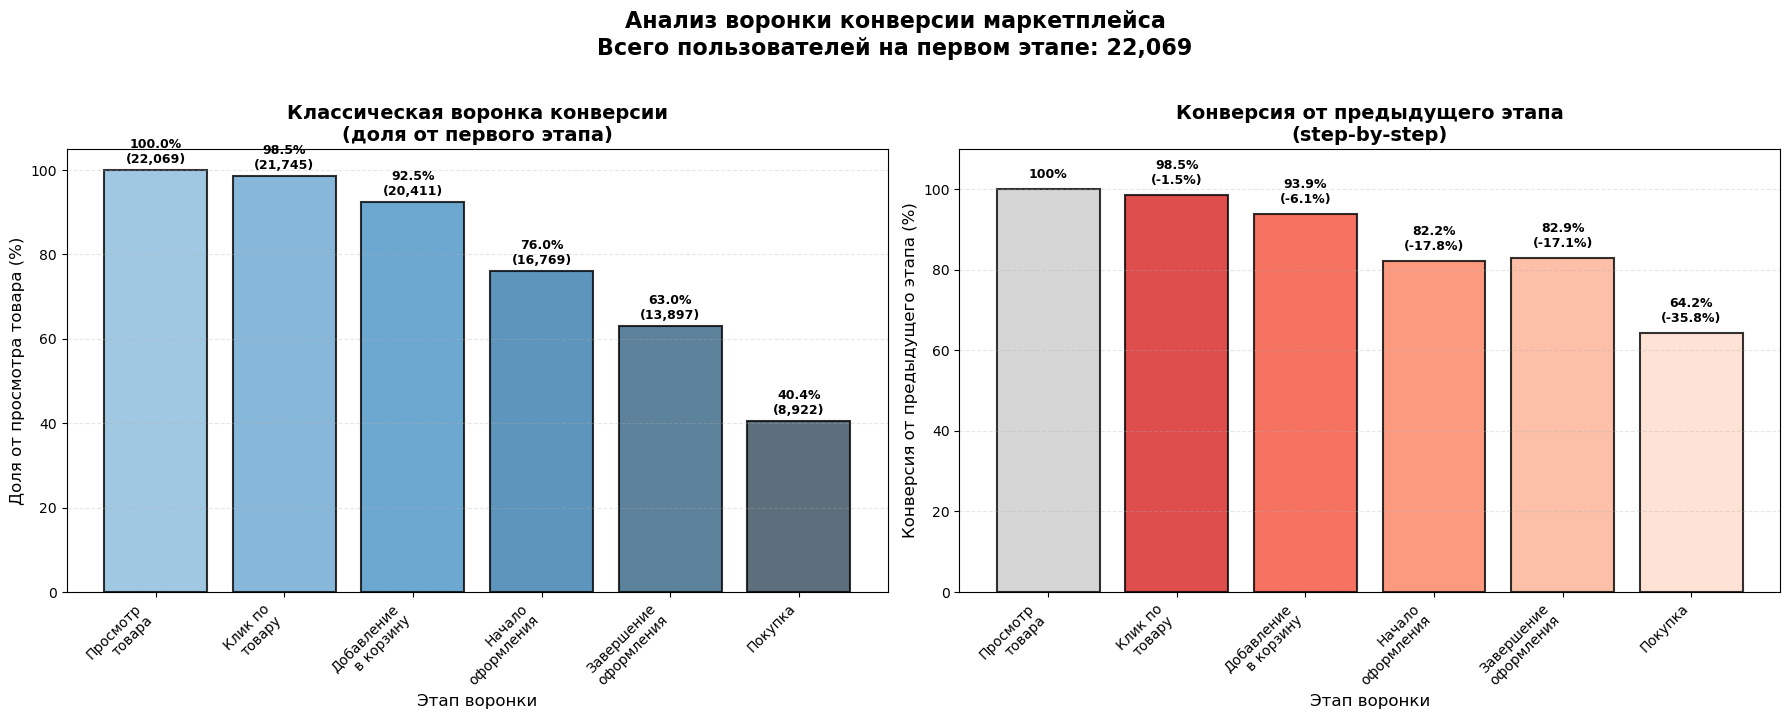

In [60]:
# Создаем фигуру с двумя графиками
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Русские названия для этапов (для красивого отображения)
step_names_ru = {
    'product_view': 'Просмотр\nтовара',
    'product_click': 'Клик по\nтовару', 
    'add_to_cart': 'Добавление\nв корзину',
    'checkout_start': 'Начало\nоформления',
    'checkout_complete': 'Завершение\nоформления',
    'order': 'Покупка'
}

funnel_df['step_ru'] = funnel_df['step'].map(step_names_ru)

# График 1: Классическая воронка (доля от первого шага)
colors1 = sns.color_palette("Blues_d", len(funnel_df))
bars1 = axes[0].bar(range(len(funnel_df)), funnel_df['conversion_from_first_step_%'], 
                   color=colors1, edgecolor='black', linewidth=1.5, alpha=0.8)

axes[0].set_title('Классическая воронка конверсии\n(доля от первого этапа)', 
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('Этап воронки', fontsize=12)
axes[0].set_ylabel('Доля от просмотра товара (%)', fontsize=12)
axes[0].set_xticks(range(len(funnel_df)))
axes[0].set_xticklabels(funnel_df['step_ru'], rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы для классической воронки
for i, (bar, val, users) in enumerate(zip(bars1, funnel_df['conversion_from_first_step_%'], funnel_df['users_n'])):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{val:.1f}%\n({users:,})', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')

# График 2: Step-by-step воронка (конверсия от предыдущего этапа)
colors2 = sns.color_palette("Reds_r", len(funnel_df))
# Первый этап делаем серым, так как там 100% по определению
colors2[0] = (0.8, 0.8, 0.8)

bars2 = axes[1].bar(range(len(funnel_df)), funnel_df['conversion_from_previous_step_%'], 
                   color=colors2, edgecolor='black', linewidth=1.5, alpha=0.8)

axes[1].set_title('Конверсия от предыдущего этапа\n(step-by-step)', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('Этап воронки', fontsize=12)
axes[1].set_ylabel('Конверсия от предыдущего этапа (%)', fontsize=12)
axes[1].set_xticks(range(len(funnel_df)))
axes[1].set_xticklabels(funnel_df['step_ru'], rotation=45, ha='right')
axes[1].set_ylim([0, 110])  # Оставляем место для подписей сверху
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения и процент потерь для step-by-step воронки
for i, (bar, val, loss) in enumerate(zip(bars2, funnel_df['conversion_from_previous_step_%'], 
                                         funnel_df['loss_from_previous_step_%'])):
    height = bar.get_height()
    
    if i == 0:
        text = '100%'
        color = 'black'
    else:
        # Форматируем текст: конверсия и потери
        text = f'{val:.1f}%\n(-{loss:.1f}%)'
        # Выделяем большие потери (>50%) красным цветом
        color = 'darkred' if loss > 50 else 'black'
    
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 2,
                text, ha='center', va='bottom', fontsize=9, 
                fontweight='bold', color=color)

# Добавляем общий заголовок
plt.suptitle(f'Анализ воронки конверсии маркетплейса\n'
             f'Всего пользователей на первом этапе: {funnel_df["users_n"].iloc[0]:,}',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

Всего пользователей, просмотревших товары: 22,069  
Всего совершивших покупку: 8,922  
Общая конверсия в покупку: 40.4%  
Самые проблемные этапы (наибольшие потери):
Покупка: теряем 35.8% пользователей (остается только 64.2%). Между завершением оформления и покупкой (отказ от оплаты).   
Начало оформления: теряем 17.8% пользователей (остается только 82.2%). Между добавлением в корзину и началом оформления (корзина брошена).    
Рекомендации по улучшению конверсии: улучшить карточки товаров, внедрить напоминания о брошенных корзинах, упростить процесс оформления заказа, добавить больше способов оплаты.  

'АНАЛИЗ ЭФФЕКТИВНОСТИ КАНАЛОВ ПРИВЛЕЧЕНИЯ:'

,channel,total_users,first_registration,buyers,conversion_rate,total_revenue,arpu,arppu,total_budget,cac_per_buyer,roi
0,Affiliate,6069,2024-01-01 01:12:00,2338,38.523645,6.735815e+06,1109.872265,2881.015730,2.012341e+06,860.710603,234.725251
3,SEO,3312,2024-01-01 04:48:00,874,26.388889,1.909935e+06,576.671119,2185.280030,6.615116e+05,756.878238,188.722799
4,Social Media,4179,2024-01-01 04:30:00,1211,28.978224,3.000255e+06,717.936047,2477.501850,1.647396e+06,1360.360414,82.120990
2,Google Ads,9319,2024-01-01 00:07:00,3187,34.198948,8.236760e+06,883.867393,2584.487053,4.663490e+06,1463.285111,76.622248
1,Email Marketing,2044,2024-01-01 01:22:00,325,15.900196,5.556987e+05,271.868268,1709.842278,5.383424e+05,1656.438061,3.224040
5,TikTok,19228,2024-01-01 01:13:00,719,3.739338,9.104482e+05,47.350125,1266.270105,9.695376e+06,13484.528737,-90.609460


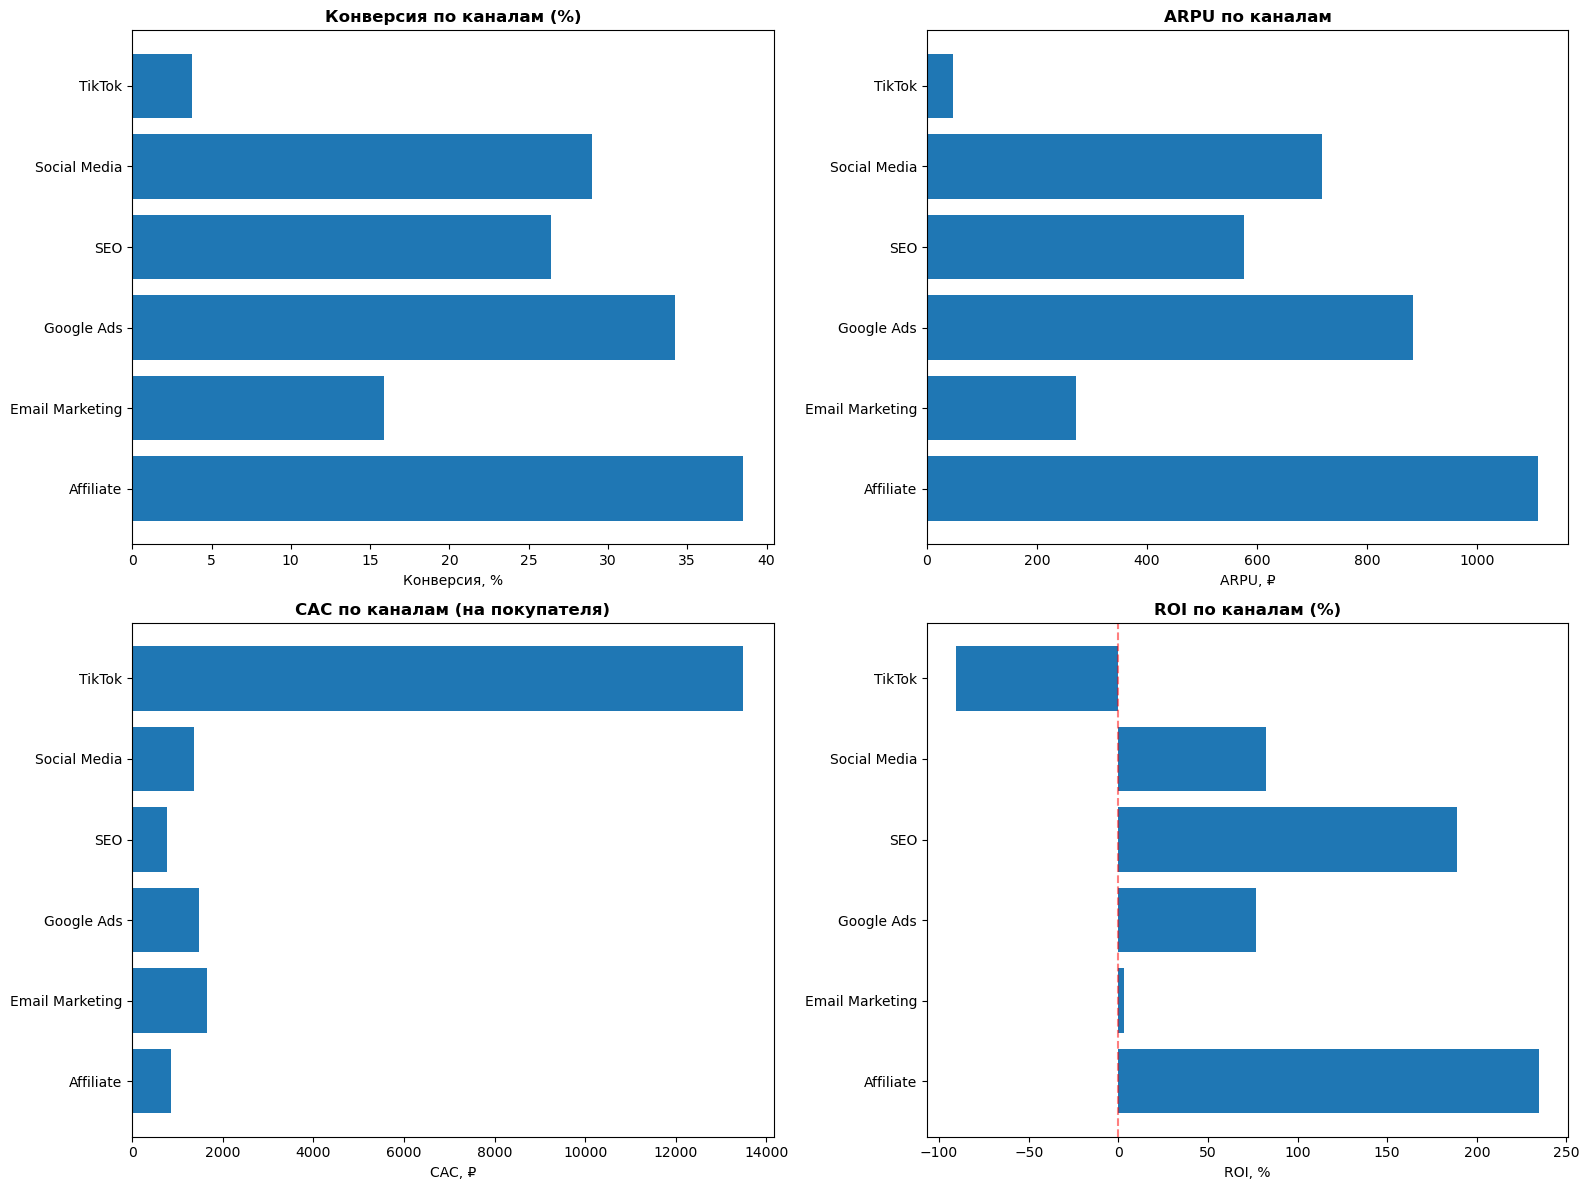

In [61]:
# Анализ эффективности каналов привлечения
channel_analysis = pa_marketplace_users.groupby('acq_channel').agg({
    'user_id': 'nunique',
    'registration_date': 'min'
}).reset_index()
channel_analysis.columns = ['channel', 'total_users', 'first_registration']

# Добавим покупателей по каналам
buyers_by_channel = pd.merge(
    pa_marketplace_users[['user_id', 'acq_channel']],
    pa_marketplace_orders[['user_id']].drop_duplicates(),
    on='user_id',
    how='inner'
).groupby('acq_channel')['user_id'].nunique().reset_index()
buyers_by_channel.columns = ['channel', 'buyers']

channel_analysis = pd.merge(channel_analysis, buyers_by_channel, on='channel', how='left')
channel_analysis['buyers'] = channel_analysis['buyers'].fillna(0)

# Конверсия по каналам
channel_analysis['conversion_rate'] = channel_analysis['buyers'] / channel_analysis['total_users'] * 100

# Выручка по каналам
revenue_by_channel = pd.merge(
    pa_marketplace_users[['user_id', 'acq_channel']],
    pa_marketplace_orders[['user_id', 'total_price']],
    on='user_id',
    how='inner'
)
revenue_by_channel['revenue'] = revenue_by_channel['total_price'] * 0.05
revenue_by_channel = revenue_by_channel.groupby('acq_channel')['revenue'].sum().reset_index()
revenue_by_channel.columns = ['channel', 'total_revenue']

channel_analysis = pd.merge(channel_analysis, revenue_by_channel, on='channel', how='left')
channel_analysis['total_revenue'] = channel_analysis['total_revenue'].fillna(0)

# ARPU по каналам
channel_analysis['arpu'] = channel_analysis['total_revenue'] / channel_analysis['total_users']
channel_analysis['arpu'] = channel_analysis['arpu'].replace([np.inf, -np.inf], 0)

# ARPPU по каналам
channel_analysis['arppu'] = channel_analysis['total_revenue'] / channel_analysis['buyers']
channel_analysis['arppu'] = channel_analysis['arppu'].replace([np.inf, -np.inf], 0)

# Добавляем CAC из кампаний
cac_by_channel = pa_marketplace_campaign_costs.groupby('acq_channel')['budget'].sum().reset_index()
cac_by_channel.columns = ['channel', 'total_budget']

channel_analysis = pd.merge(channel_analysis, cac_by_channel, on='channel', how='left')
channel_analysis['total_budget'] = channel_analysis['total_budget'].fillna(0)

# CAC на покупателя
channel_analysis['cac_per_buyer'] = channel_analysis['total_budget'] / channel_analysis['buyers']
channel_analysis['cac_per_buyer'] = channel_analysis['cac_per_buyer'].replace([np.inf, -np.inf], 0)

# ROI по каналам
channel_analysis['roi'] = (channel_analysis['total_revenue'] - channel_analysis['total_budget']) / channel_analysis['total_budget'] * 100
channel_analysis['roi'] = channel_analysis['roi'].replace([np.inf, -np.inf], -100)

display("АНАЛИЗ ЭФФЕКТИВНОСТИ КАНАЛОВ ПРИВЛЕЧЕНИЯ:")
display(channel_analysis.sort_values('roi', ascending=False))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Конверсия по каналам
axes[0, 0].barh(channel_analysis['channel'], channel_analysis['conversion_rate'])
axes[0, 0].set_title('Конверсия по каналам (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Конверсия, %')

# ARPU по каналам
axes[0, 1].barh(channel_analysis['channel'], channel_analysis['arpu'])
axes[0, 1].set_title('ARPU по каналам', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('ARPU, ₽')

# CAC по каналам
axes[1, 0].barh(channel_analysis['channel'], channel_analysis['cac_per_buyer'])
axes[1, 0].set_title('CAC по каналам (на покупателя)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('CAC, ₽')

# ROI по каналам
axes[1, 1].barh(channel_analysis['channel'], channel_analysis['roi'])
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('ROI по каналам (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('ROI, %')

plt.tight_layout()
plt.show()

Affiliate  
ROI: 234.7%, конверсия: 38.5%, CAC: 861 (один из самых низких, ARPU: 1,110(второй по высоте).  
Это лучший канал. Каждый вложенный рубль приносит 2.35 прибыли.  
SEO  
ROI: 188.7%, конверсия: 26.4%, CAC: 757 (самый низкий).  
Низкий CAC, хорошая конверсия.  
Social Media  
ROI: 82.1%, конверсия: 29.0%, CAC 1,360 (выше среднего).  
Google Ads  
ROI: 76.6%, конверсия: 34.2%, CAC 1,463 (высокий).  
Проблемные каналы:  
Email Marketing  
ROI: 3.2% (едва окупается), конверсия: 15.9% (самая низкая из всех, кроме TikTok), CAC: 1,656 (высокий).  
TikTok  
ROI: -90.6% (каждый рубль теряет 91 копейку), конверсия: 3.7% (очень низкая), CAC: 13,485 (слишком высокий), ARPU: 47.  
Этот канал уничтожает всю прибыль бизнеса.  

TikTok привлек 19,228 пользователей (44% от всех), но только 3.7% из них купили.  
На TikTok потрачено 9.7 млн (почти 50% всего бюджета), но он принес только 910 тыс выручки.  
Необходимо масштабировать прибыльные каналы.  

Мы нашли "черную дыру" в маркетинговом бюджете. Теперь нужно просто ее закрыть и перенаправить ресурсы в прибыльные направления.

'Анализ по регионам:'

,region,total_users,avg_age,buyers,conversion_rate,total_revenue,arpu,avg_aov
1,Екатеринбург,2145,43.622378,418,19.487179,1.143766e+06,533.224196,14368.918335
2,Краснодар,1398,44.403433,290,20.743920,7.288376e+05,521.343086,15360.118746
8,Санкт-Петербург,6690,43.940060,1317,19.686099,3.396293e+06,507.667052,14554.500000
3,Москва,10959,43.849621,2200,20.074824,5.410184e+06,493.674984,13612.238395
5,Нижний Новгород,1748,44.361556,354,20.251716,8.414220e+05,481.362701,13748.725523
0,Другие регионы,14516,43.970102,2816,19.399284,6.837361e+06,471.022411,13943.838727
4,Московская область,3549,44.083967,681,19.188504,1.658614e+06,467.346863,14549.245776
7,Ростов-на-Дону,1423,43.957836,268,18.833450,6.037048e+05,424.247922,13326.816623
6,Новосибирск,1723,44.910041,310,17.991875,7.287291e+05,422.941993,13595.691306


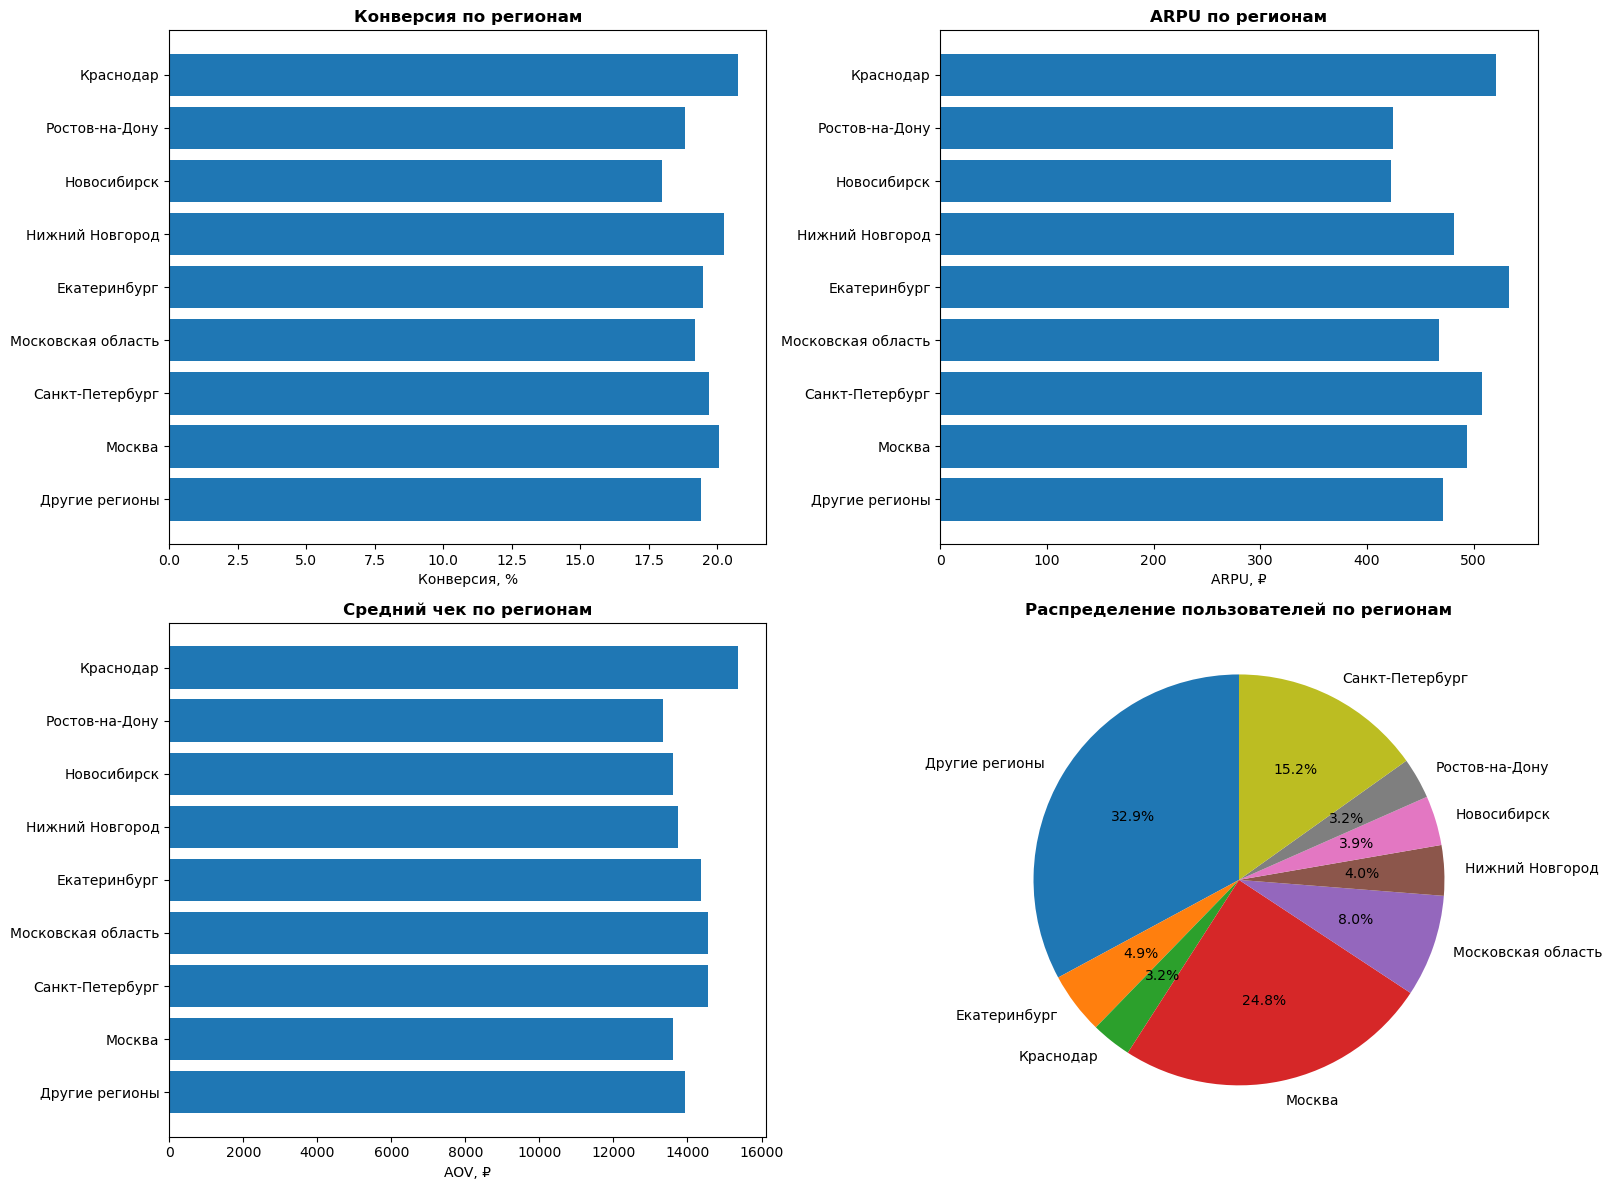

In [62]:
# Анализ по регионам
region_analysis = pa_marketplace_users.groupby('region').agg({
    'user_id': 'nunique',
    'age': 'mean'
}).reset_index()
region_analysis.columns = ['region', 'total_users', 'avg_age']

# Покупатели по регионам
buyers_by_region = pd.merge(
    pa_marketplace_users[['user_id', 'region']],
    pa_marketplace_orders[['user_id']].drop_duplicates(),
    on='user_id',
    how='inner'
).groupby('region')['user_id'].nunique().reset_index()
buyers_by_region.columns = ['region', 'buyers']

region_analysis = pd.merge(region_analysis, buyers_by_region, on='region', how='left')
region_analysis['buyers'] = region_analysis['buyers'].fillna(0)
region_analysis['conversion_rate'] = region_analysis['buyers'] / region_analysis['total_users'] * 100

# Выручка по регионам
revenue_by_region = pd.merge(
    pa_marketplace_users[['user_id', 'region']],
    pa_marketplace_orders[['user_id', 'total_price']],
    on='user_id',
    how='inner'
)
revenue_by_region['revenue'] = revenue_by_region['total_price'] * 0.05
revenue_by_region = revenue_by_region.groupby('region')['revenue'].sum().reset_index()
revenue_by_region.columns = ['region', 'total_revenue']

region_analysis = pd.merge(region_analysis, revenue_by_region, on='region', how='left')
region_analysis['total_revenue'] = region_analysis['total_revenue'].fillna(0)

# ARPU по регионам
region_analysis['arpu'] = region_analysis['total_revenue'] / region_analysis['total_users']
region_analysis['arpu'] = region_analysis['arpu'].replace([np.inf, -np.inf], 0)

# AOV по регионам
aov_by_region = pd.merge(
    pa_marketplace_users[['user_id', 'region']],
    pa_marketplace_orders[['user_id', 'total_price']],
    on='user_id',
    how='inner'
).groupby('region')['total_price'].mean().reset_index()
aov_by_region.columns = ['region', 'avg_aov']

region_analysis = pd.merge(region_analysis, aov_by_region, on='region', how='left')

display("Анализ по регионам:")
display(region_analysis.sort_values('arpu', ascending=False))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Конверсия по регионам
top_regions = region_analysis.nlargest(10, 'total_users')
axes[0, 0].barh(top_regions['region'], top_regions['conversion_rate'])
axes[0, 0].set_title('Конверсия по регионам', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Конверсия, %')

# ARPU по регионам
axes[0, 1].barh(top_regions['region'], top_regions['arpu'])
axes[0, 1].set_title('ARPU по регионам', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('ARPU, ₽')

# AOV по регионам
axes[1, 0].barh(top_regions['region'], top_regions['avg_aov'])
axes[1, 0].set_title('Средний чек по регионам', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('AOV, ₽')

# Распределение пользователей
axes[1, 1].pie(region_analysis['total_users'], 
              labels=region_analysis['region'], 
              autopct='%1.1f%%',
              startangle=90)
axes[1, 1].set_title('Распределение пользователей по регионам', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Екатеринбург  
ARPU: 533 (самый высокий), конверсия: 19.5%, AOV: 14,369.  
При относительно небольшой аудитории (2,145 пользователей) показывает максимальную доходность.  
Краснодар  
AOV: 15,360, конверсия: 20.7%, ARPU: 521.  
Покупатели с самыми высокими чеками.  
Санкт-Петербург   
Аудитория 6,690 пользователей, выручка: 3.4 млн, ARPU: 508.  
Баланс масштаба и эффективности.  
Москва и Московская область  
Москва: аудитория: 10,959 пользователей (самая большая), выручка: 5.4 млн (самая большая), но ARPU: 494, конверсия: 20.1%.  
Московская область: ARPU: 467, конверсия: 19.2% (одна из самых низких).  
Столичный регион показывает средние результаты, несмотря на масштаб. Москва и МО имеют крупнейшую аудиторию, но среднюю эффективность. Возможные причины - высокая конкуренция, насыщенность рынка.  
Проблемные регионы:  
Новосибирск  
Конверсия: 18.0% (самая низкая), ARPU: 423 (самый низкий).  
Низкая вовлеченность аудитории. Новосибирск показывает самые низкие метрики. Возможно недоработанная маркетинговая стратегия для региона.  
Ростов-на-Дону  
ARPU: 424, конверсия: 18.8%.  
"Другие регионы"  
Аудитория: 14,516 пользователей (37% от всех), выручка: 6.8 млн (31% от общей), ARPU: 471.  
Совокупность мелких регионов дает значимый вклад.  
Есть скрытый потенциал ("Другие регионы" дают 31% выручки).  

'Анализ по категориям товаров:'

,category,orders_count,total_quantity,total_gmv,unique_buyers,revenue,aov,avg_quantity_per_order,avg_orders_per_buyer,margin_rate
11,Мебель для дома,979,1964,71619964.45,514,3.580998e+06,73156.245608,2.006129,1.904669,5.0
2,Бытовая техника,1030,2059,44978661.11,546,2.248933e+06,43668.603019,1.999029,1.886447,5.0
24,Украшения и часы,1024,2058,34365942.06,495,1.718297e+06,33560.490293,2.009766,2.068687,5.0
18,Спортивный инвентарь,1000,2021,23307222.90,523,1.165361e+06,23307.222900,2.021000,1.912046,5.0
23,Товары для туризма,970,1949,22746355.71,498,1.137318e+06,23449.851247,2.009278,1.947791,5.0
0,Автотовары,1043,2123,20896434.84,561,1.044822e+06,20034.932733,2.035475,1.859180,5.0
21,Товары для кухни,1237,2462,20608036.11,637,1.030402e+06,16659.689660,1.990299,1.941915,5.0
15,Обувь мужская,1253,2482,18849633.69,730,9.424817e+05,15043.602306,1.980846,1.716438,5.0
20,Сумки и аксессуары,1180,2311,17469822.79,711,8.734911e+05,14804.934568,1.958475,1.659634,5.0
14,Обувь женская,1211,2424,17209783.72,757,8.604892e+05,14211.216945,2.001652,1.599736,5.0


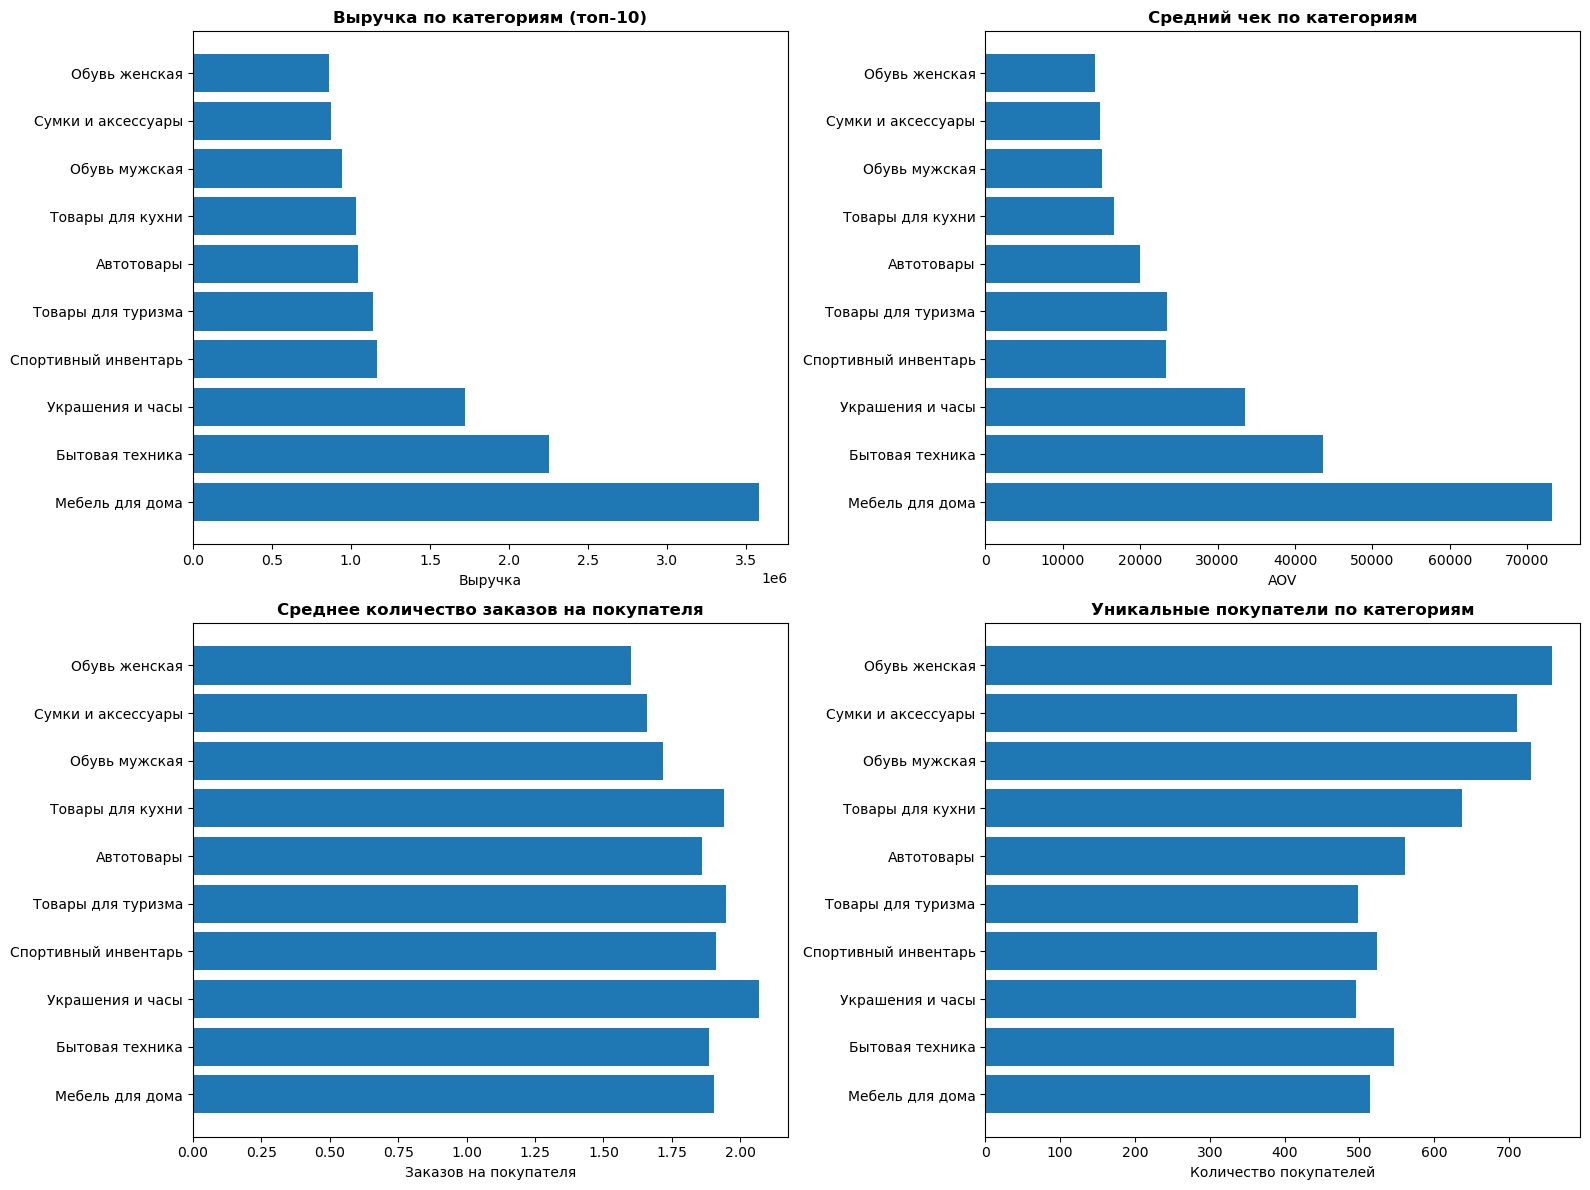

In [63]:
# Анализ по категориям товаров
category_analysis = pa_marketplace_orders.groupby('category_name').agg({
    'order_id': 'nunique',
    'quantity': 'sum',
    'total_price': 'sum',
    'user_id': 'nunique'
}).reset_index()

category_analysis.columns = ['category', 'orders_count', 'total_quantity', 'total_gmv', 'unique_buyers']

# Выручка по категориям
category_analysis['revenue'] = category_analysis['total_gmv'] * 0.05

# AOV по категориям
category_analysis['aov'] = category_analysis['total_gmv'] / category_analysis['orders_count']

# Среднее количество товаров в заказе
category_analysis['avg_quantity_per_order'] = category_analysis['total_quantity'] / category_analysis['orders_count']

# Частота покупок по категориям
category_analysis['avg_orders_per_buyer'] = category_analysis['orders_count'] / category_analysis['unique_buyers']

# Маржинальность (фиксированная 5%)
category_analysis['margin_rate'] = 5.0

display("Анализ по категориям товаров:")
display(category_analysis.sort_values('revenue', ascending=False))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Выручка по категориям (топ-10)
top_categories = category_analysis.nlargest(10, 'revenue')
axes[0, 0].barh(top_categories['category'], top_categories['revenue'])
axes[0, 0].set_title('Выручка по категориям (топ-10)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Выручка')

# AOV по категориям
axes[0, 1].barh(top_categories['category'], top_categories['aov'])
axes[0, 1].set_title('Средний чек по категориям', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('AOV')

# Частота покупок
axes[1, 0].barh(top_categories['category'], top_categories['avg_orders_per_buyer'])
axes[1, 0].set_title('Среднее количество заказов на покупателя', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Заказов на покупателя')

# Количество уникальных покупателей
axes[1, 1].barh(top_categories['category'], top_categories['unique_buyers'])
axes[1, 1].set_title('Уникальные покупатели по категориям', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Количество покупателей')

plt.tight_layout()
plt.show()

Мебель для дома (абсолютный лидер)  
Выручка: 3.58 млн (16% от общей), AOV: 73,156, кол-во заказов: 979, уникальных покупателей: 514, средних заказов на покупателя: 1.90.  
Премиум-сегмент с высоким средним чеком.  
Бытовая техника  
Выручка: 2.25 млн (10% от общей), AOV: 43,669, кол-во заказов: 1,030, уникальных покупателей: 546, средних заказов: 1.89.  
Украшения и часы  
Выручка: 1.72 млн, AOV: 33,560, кол-во заказов: 1,024, средних заказов на покупателя: 2.07 (самая высокая частота).  
Категории с высоким потенциалом:  
Спортивный инвентарь  
Выручка: 1.17 млн, AOV: 23,307, частота покупок: 1.91 (выше среднего).  
Товары для туризма  
Выручка: 1.14 млн, AOV: 23,450, хорошая маржинальность.  
Проблемные категории  
Продукты питания  
Кол-во заказов: 4,027 (самое большое), уникальных покупателей: 2,659 (самое большое), но AOV: 2,962(самый низкий). Выручка: 596 тыс(низкая относительно объема).  
Низкая маржинальность при высоком объеме.  
Книги и канцтовары  
AOV: 3,107, выручка: 204 тыс, частота: 1.78.  
Средства для ухода  
AOV: 2,786, выручка: 163 тыс.  

'Анализ по возрастным группам:'

,age_group,total_users,buyers,conversion_rate,total_revenue,arpu,arppu
0,18-24,5824,1158,19.883242,2.849339e+06,489.240954,2460.569359
1,25-34,8339,1644,19.714594,4.588303e+06,550.222198,2790.938507
2,35-44,8372,1702,20.329670,4.064780e+06,485.520829,2388.237590
3,45-54,8306,1630,19.624368,3.651833e+06,439.662055,2240.388360
4,55-64,8316,1564,18.807119,3.775649e+06,454.022255,2414.097873
5,65+,4994,956,19.142972,2.419007e+06,484.382608,2530.341783


'Анализ по полу:'

,gender,total_users,buyers,conversion_rate,total_revenue,arpu,arppu
0,F,22126,4381,19.800235,1.083445e+07,489.670315,2473.053047
1,M,22025,4273,19.400681,1.051447e+07,477.387789,2460.675415


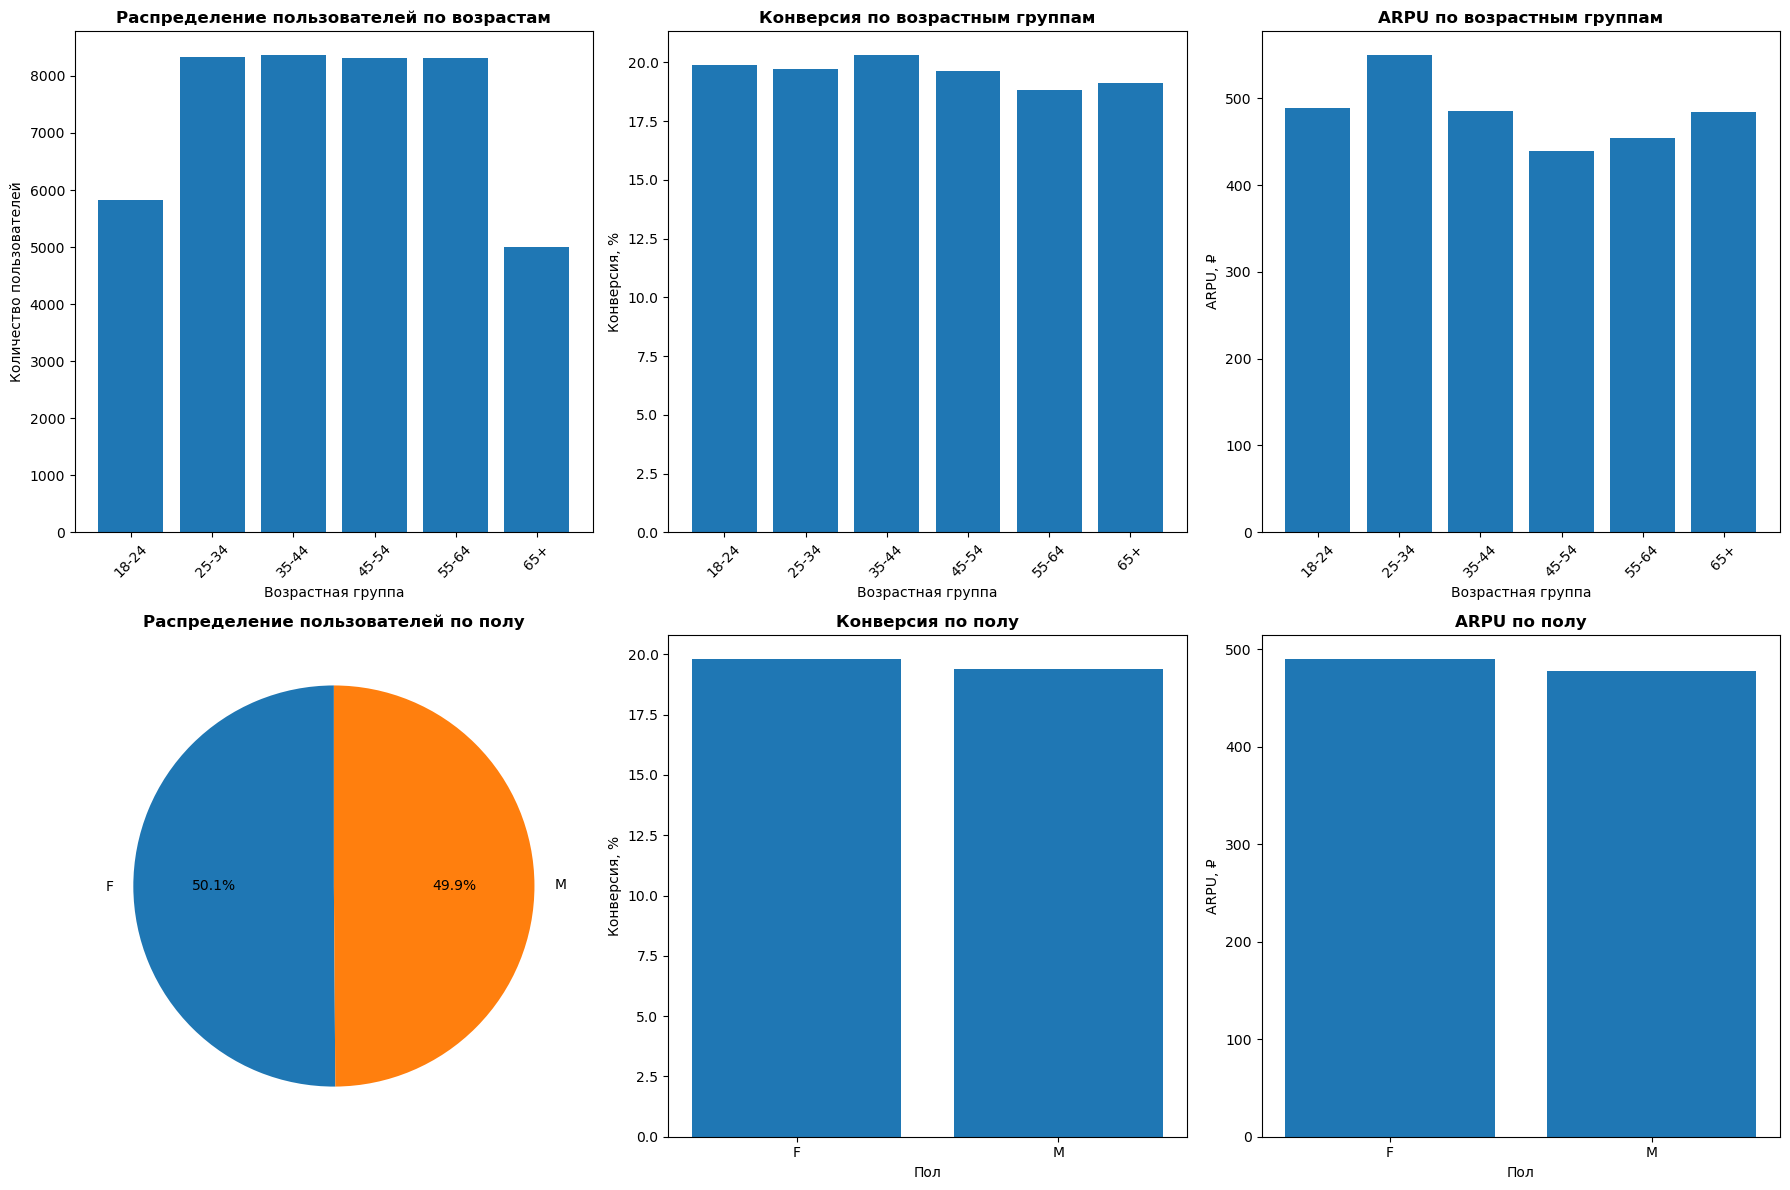

In [64]:
# Анализ по возрасту 
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Сначала создаем отдельные датафреймы
all_users = pa_marketplace_users.copy()
buying_users = pa_marketplace_orders['user_id'].drop_duplicates()

# Добавляем флаг покупателя
all_users['is_buyer'] = all_users['user_id'].isin(buying_users)

# Создаем возрастные группы
all_users['age_group'] = pd.cut(all_users['age'], bins=age_bins, labels=age_labels, right=False)

# Анализ по возрастным группам 
age_analysis = all_users.groupby('age_group', observed=True).agg({
    'user_id': 'nunique',
    'is_buyer': 'sum'
}).reset_index()
age_analysis.columns = ['age_group', 'total_users', 'buyers']

age_analysis['conversion_rate'] = age_analysis['buyers'] / age_analysis['total_users'] * 100

# Выручка по возрастным группам 
# Объединяем заказы с информацией о возрасте пользователей
users_with_age = all_users[['user_id', 'age_group', 'is_buyer']].copy()

# Фильтруем только покупателей для расчета выручки
buyers_data = users_with_age[users_with_age['is_buyer'] == True].copy()

# Объединяем с заказами
revenue_by_age = pd.merge(
    buyers_data,
    pa_marketplace_orders[['user_id', 'total_price']],
    on='user_id',
    how='inner'
)

# Группируем 
revenue_by_age['revenue'] = revenue_by_age['total_price'] * 0.05
revenue_by_age = revenue_by_age.groupby('age_group', observed=True)['revenue'].sum().reset_index()
revenue_by_age.columns = ['age_group', 'total_revenue']

# Объединяем с основным анализом
age_analysis = pd.merge(age_analysis, revenue_by_age, on='age_group', how='left')
age_analysis['total_revenue'] = age_analysis['total_revenue'].fillna(0)
age_analysis['arpu'] = age_analysis['total_revenue'] / age_analysis['total_users']
age_analysis['arppu'] = age_analysis['total_revenue'] / age_analysis['buyers']
age_analysis['arppu'] = age_analysis['arppu'].replace([np.inf, -np.inf], 0)

# Анализ по полу 
gender_analysis = all_users.groupby('gender', observed=True).agg({
    'user_id': 'nunique',
    'is_buyer': 'sum'
}).reset_index()
gender_analysis.columns = ['gender', 'total_users', 'buyers']

gender_analysis['conversion_rate'] = gender_analysis['buyers'] / gender_analysis['total_users'] * 100

# Выручка по полу 
revenue_by_gender = pd.merge(
    all_users[['user_id', 'gender', 'is_buyer']],
    pa_marketplace_orders[['user_id', 'total_price']],
    on='user_id',
    how='inner'
)
revenue_by_gender['revenue'] = revenue_by_gender['total_price'] * 0.05
revenue_by_gender = revenue_by_gender.groupby('gender', observed=True)['revenue'].sum().reset_index()
revenue_by_gender.columns = ['gender', 'total_revenue']

gender_analysis = pd.merge(gender_analysis, revenue_by_gender, on='gender', how='left')
gender_analysis['total_revenue'] = gender_analysis['total_revenue'].fillna(0)
gender_analysis['arpu'] = gender_analysis['total_revenue'] / gender_analysis['total_users']
gender_analysis['arppu'] = gender_analysis['total_revenue'] / gender_analysis['buyers']
gender_analysis['arppu'] = gender_analysis['arppu'].replace([np.inf, -np.inf], 0)

display("Анализ по возрастным группам:")
display(age_analysis)

display("Анализ по полу:")
display(gender_analysis)

# Визуализация
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Распределение по возрастам
axes[0, 0].bar(age_analysis['age_group'].astype(str), age_analysis['total_users'])
axes[0, 0].set_title('Распределение пользователей по возрастам', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Возрастная группа')
axes[0, 0].set_ylabel('Количество пользователей')
axes[0, 0].tick_params(axis='x', rotation=45)

# Конверсия по возрастам
axes[0, 1].bar(age_analysis['age_group'].astype(str), age_analysis['conversion_rate'])
axes[0, 1].set_title('Конверсия по возрастным группам', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Возрастная группа')
axes[0, 1].set_ylabel('Конверсия, %')
axes[0, 1].tick_params(axis='x', rotation=45)

# ARPU по возрастам
axes[0, 2].bar(age_analysis['age_group'].astype(str), age_analysis['arpu'])
axes[0, 2].set_title('ARPU по возрастным группам', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Возрастная группа')
axes[0, 2].set_ylabel('ARPU, ₽')
axes[0, 2].tick_params(axis='x', rotation=45)

# Распределение по полу
axes[1, 0].pie(gender_analysis['total_users'], 
               labels=gender_analysis['gender'], 
               autopct='%1.1f%%',
               startangle=90)
axes[1, 0].set_title('Распределение пользователей по полу', fontsize=12, fontweight='bold')

# Конверсия по полу
axes[1, 1].bar(gender_analysis['gender'].astype(str), gender_analysis['conversion_rate'])
axes[1, 1].set_title('Конверсия по полу', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Пол')
axes[1, 1].set_ylabel('Конверсия, %')

# ARPU по полу
axes[1, 2].bar(gender_analysis['gender'].astype(str), gender_analysis['arpu'])
axes[1, 2].set_title('ARPU по полу', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Пол')
axes[1, 2].set_ylabel('ARPU, ₽')

plt.tight_layout()
plt.show()

25-34 года - самый высокий ARPU и ARPPU.  
Пожилые люди - недооцененный сегмент (высокий ARPPU при низкой конверсии).  
Гендерный баланс идеален: почти равное распределение.  

'Анализ по устройствам и ОС:'

,device,os,total_events,unique_users,events_per_user,buyers,conversion_rate,total_revenue,arpu
4,mobile,Android,67733,1862,36.376477,656,35.230934,1.732343e+06,930.366669
3,desktop,macOS,62485,1824,34.257127,617,33.826754,1.660688e+06,910.464999
7,mobile,macOS,65896,1827,36.067871,614,33.607006,1.563190e+06,855.604853
5,mobile,Windows,62799,1843,34.074335,619,33.586544,1.600704e+06,868.531543
9,tablet,Windows,66829,1834,36.438931,604,32.933479,1.551908e+06,846.187345
10,tablet,iOS,63599,1825,34.848767,601,32.931507,1.752696e+06,960.381153
8,tablet,Android,67377,1834,36.737732,603,32.878953,1.664141e+06,907.383053
2,desktop,iOS,64885,1879,34.531666,611,32.517296,1.679875e+06,894.026064
11,tablet,macOS,63483,1767,35.926995,569,32.201471,1.826507e+06,1033.676590
0,desktop,Android,62835,1827,34.392447,586,32.074439,1.672573e+06,915.475054


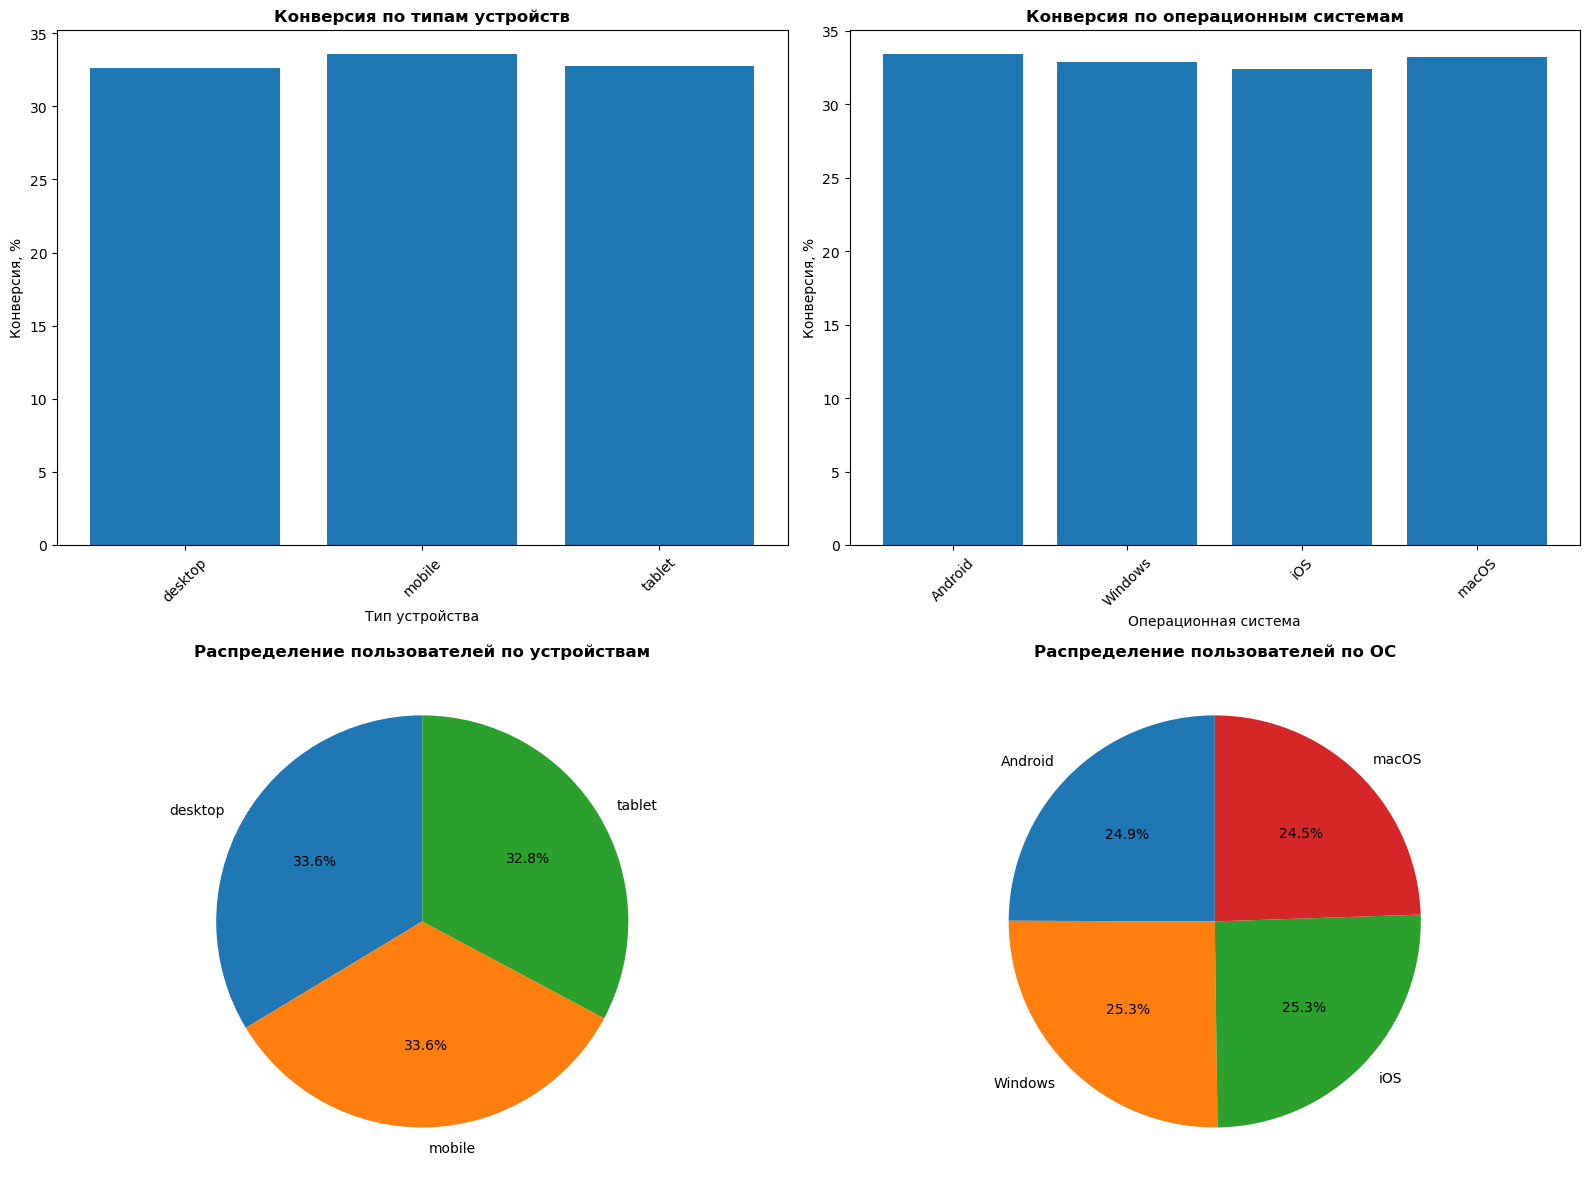

In [65]:
# Анализ по устройствам и ОС
device_analysis = pa_marketplace_events.groupby(['device', 'os']).agg({
    'event_id': 'count',
    'user_id': 'nunique'
}).reset_index()

device_analysis.columns = ['device', 'os', 'total_events', 'unique_users']
device_analysis['events_per_user'] = device_analysis['total_events'] / device_analysis['unique_users']

# Добавляем покупателей по устройствам
device_buyers = pd.merge(
    pa_marketplace_events[['user_id', 'device', 'os']].drop_duplicates(),
    pa_marketplace_orders[['user_id']].drop_duplicates(),
    on='user_id',
    how='inner'
).groupby(['device', 'os'])['user_id'].nunique().reset_index()
device_buyers.columns = ['device', 'os', 'buyers']

device_analysis = pd.merge(device_analysis, device_buyers, on=['device', 'os'], how='left')
device_analysis['buyers'] = device_analysis['buyers'].fillna(0)
device_analysis['conversion_rate'] = device_analysis['buyers'] / device_analysis['unique_users'] * 100

# Выручка по устройствам
device_revenue = pd.merge(
    pa_marketplace_events[['user_id', 'device', 'os']].drop_duplicates(),
    pa_marketplace_orders[['user_id', 'total_price']],
    on='user_id',
    how='inner'
)
device_revenue['revenue'] = device_revenue['total_price'] * 0.05
device_revenue = device_revenue.groupby(['device', 'os'])['revenue'].sum().reset_index()
device_revenue.columns = ['device', 'os', 'total_revenue']

device_analysis = pd.merge(device_analysis, device_revenue, on=['device', 'os'], how='left')
device_analysis['total_revenue'] = device_analysis['total_revenue'].fillna(0)
device_analysis['arpu'] = device_analysis['total_revenue'] / device_analysis['unique_users']

display("Анализ по устройствам и ОС:")
display(device_analysis.sort_values('conversion_rate', ascending=False))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Конверсия по устройствам
device_summary = device_analysis.groupby('device')['conversion_rate'].mean().reset_index()
axes[0, 0].bar(device_summary['device'], device_summary['conversion_rate'])
axes[0, 0].set_title('Конверсия по типам устройств', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Тип устройства')
axes[0, 0].set_ylabel('Конверсия, %')
axes[0, 0].tick_params(axis='x', rotation=45)

# Конверсия по ОС
os_summary = device_analysis.groupby('os')['conversion_rate'].mean().reset_index()
axes[0, 1].bar(os_summary['os'], os_summary['conversion_rate'])
axes[0, 1].set_title('Конверсия по операционным системам', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Операционная система')
axes[0, 1].set_ylabel('Конверсия, %')
axes[0, 1].tick_params(axis='x', rotation=45)

# Распределение пользователей по устройствам
device_users = device_analysis.groupby('device')['unique_users'].sum().reset_index()
axes[1, 0].pie(device_users['unique_users'], 
               labels=device_users['device'], 
               autopct='%1.1f%%',
               startangle=90)
axes[1, 0].set_title('Распределение пользователей по устройствам', fontsize=12, fontweight='bold')

# Распределение по ОС
os_users = device_analysis.groupby('os')['unique_users'].sum().reset_index()
axes[1, 1].pie(os_users['unique_users'], 
               labels=os_users['os'], 
               autopct='%1.1f%%',
               startangle=90)
axes[1, 1].set_title('Распределение пользователей по ОС', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Android-смартфоны — двигатель роста (самая высокая конверсия).  
iPad-пользователи — премиум-сегмент (самый высокий ARPU).  
iPhone-пользователи требуют внимания (низкая конверсия при высокой активности).  
Планшеты недооценены (самый высокий ARPU среди всех устройств).  

In [66]:
# Фильтруем только события оформления заказов 
orders_data = pa_marketplace_orders.copy() 

display(f"Количество заказов: {len(orders_data)}")
display(f"Уникальных пользователей, совершивших заказы: {orders_data['user_id'].nunique()}")

# Рассчитываем количество дней с последней покупки до даты анализа:
orders_data['order_date'] = pd.to_datetime(orders_data['order_date'])
orders_data['order_recency'] = pd.to_datetime('2024-12-31') - orders_data['order_date']

# Группируем данные для каждого пользователя и рассчитываем данные для RFM-анализа:
rfm_analysis = orders_data.groupby('user_id').agg(
    # Количество дней с последнего заказа (Recency):    
    recency = ('order_recency', lambda x: x.min().days),
    # Количество заказов за период времени (Frequency): 
    frequency = ('order_id', 'count'),
    # Сумма стоимости всех заказов (Monetary): 
    monetary_value = ('total_price', 'sum')
).reset_index()

display(rfm_analysis.head(3))

'Количество заказов: 31357'

'Уникальных пользователей, совершивших заказы: 8922'

,user_id,recency,frequency,monetary_value
0,3,340,7,87191.23
1,5,291,14,141379.80
2,6,250,2,7391.52


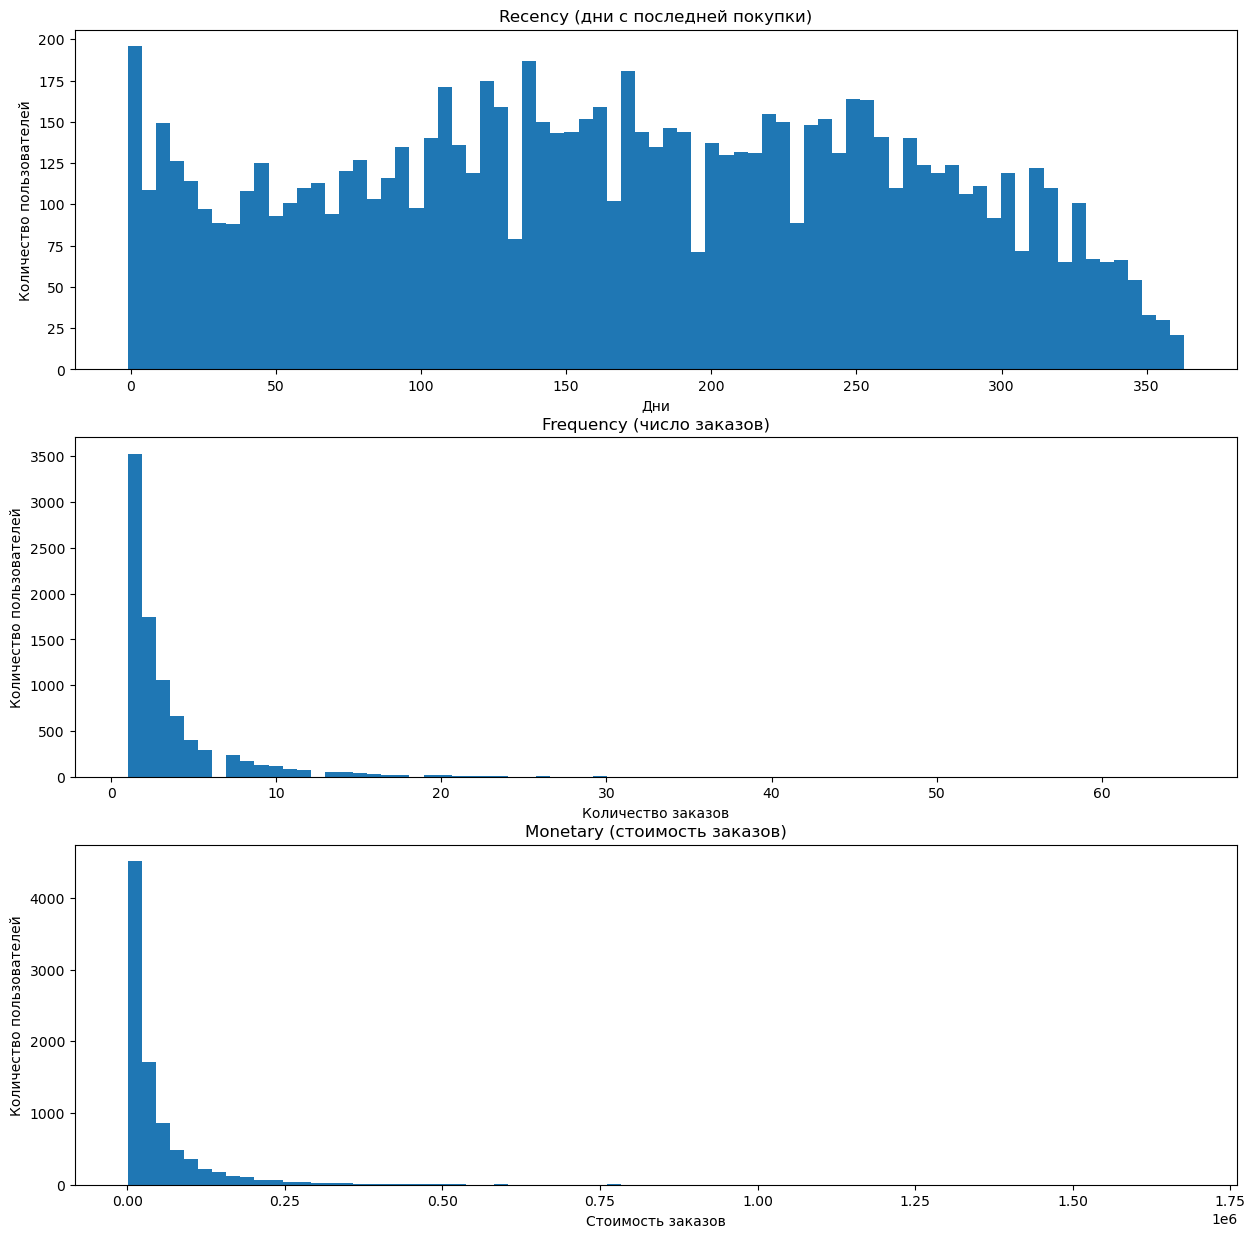

In [67]:
# Построим три гистограммы
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Давность
axes[0].hist(rfm_analysis['recency'], bins=75)
axes[0].set_title('Recency (дни с последней покупки)')
axes[0].set_xlabel('Дни')
axes[0].set_ylabel('Количество пользователей')

# Частота
axes[1].hist(rfm_analysis['frequency'], bins=75)
axes[1].set_title('Frequency (число заказов)')
axes[1].set_xlabel('Количество заказов')
axes[1].set_ylabel('Количество пользователей')

# Сумма всех заказов
axes[2].hist(rfm_analysis['monetary_value'], bins=75)
axes[2].set_title('Monetary (стоимость заказов)')
axes[2].set_xlabel('Стоимость заказов')
axes[2].set_ylabel('Количество пользователей')

plt.show()

Метрика Recency распределена более менее равномерно - пользователи совершают покупки с разной активностью. Распределение метрики Frequency смещено влево - большинство пользователей сделали лишь несколько покупок. У метрики Monetary значения сильно варьируются, но большинство пользователей находятся в диапазоне до 250000.

In [68]:
# Определим группу пользователя по количеству дней с момента последнего заказа: 
rfm_analysis['r'] = pd.cut(rfm_analysis['recency'], bins=3, labels=[3,2,1])

# Определим группу пользователя по количеству заказов: 
rfm_analysis['f'] = pd.cut(rfm_analysis['frequency'], [0,1,2,70], labels=[1,2,3], include_lowest=True)

# Определим группу пользователя по сумме стоимости заказов: 
rfm_analysis['m'] = pd.qcut(rfm_analysis['monetary_value'], q=3, labels=[1,2,3])

# Найдем групповой RFM-индекс:
rfm_analysis[['r','f','m']] = rfm_analysis[['r','f','m']].astype('str')
rfm_analysis['rfm_group'] = rfm_analysis['r'] + rfm_analysis['f'] + rfm_analysis['m']

# Выводим на экран первые строки таблицы:
display(rfm_analysis.head(3))

,user_id,recency,frequency,monetary_value,r,f,m,rfm_group
0,3,340,7,87191.23,1,3,3,133
1,5,291,14,141379.80,1,3,3,133
2,6,250,2,7391.52,1,2,1,121


In [69]:
# Группируем данные по сегментам и считаем их размер:
rfm_group = rfm_analysis.groupby('rfm_group').agg({'user_id':'nunique'}).reset_index()

# Считаем долю пользователей в каждом сегменте:
rfm_group['user_share'] = rfm_group['user_id'] / rfm_group['user_id'].sum()

# Выводим результат:
display(rfm_group.sort_values(by='user_id', ascending=False))

,rfm_group,user_id,user_share
17,233,1021,0.114436
26,333,887,0.099417
9,211,870,0.097512
0,111,740,0.082941
18,311,701,0.078570
8,133,523,0.058619
16,232,422,0.047299
10,212,375,0.042031
25,332,372,0.041695
13,222,351,0.039341


Самый многочисленный сегмент — 233 (11.4%). Основная часть пользователей покупали недавно, сделали 3+ заказа и имеют средние траты. Это активные, лояльные клиенты со стабильными покупками.  
Далее идут 333 (9.9%) - покупали очень недавно, много заказов, высокие траты. Это премиальная аудитория, максимально вовлеченная.  
Третий по размеру сегмент — 211 (9.8%) - покупали недавно, 1 заказ, небольшие траты. В основном это новые клиенты после первого заказа.  
Лучшие клиенты:  
333 (9.9%) - максимальные показатели по всем параметрам.  
233 (11.4%) - очень активные со средним чеком.  
332 (4.2%) - активные с высокими тратами.  
Эти клиенты уже лояльны, им нужны программы удержания и эксклюзивные предложения.  
Новые/вернувшиеся клиенты с потенциалом:  
211 (9.8%) - новые после первого заказа.  
311 (7.9%) - вернувшиеся с высоким чеком.  
312 (3.6%) - недавние покупки, средняя частота, низкий чек.  
Нужно стимулировать повторные покупки и повышать средний чек.  
Клиенты, требующие реактивации:  
111 (8.3%) - давно не покупали, 1 заказ, низкие траты.  
112 (3.5%) - давно не покупали, 1 заказ, средние траты.  
113 (0.5%) - давно не покупали, 1 заказ, высокие траты.  
Нужны специальные предложения, напоминания, скидки для возврата.  
Активные клиенты с потенциалом роста:  
222 (3.9%) - средние показатели по всем параметрам.  
212 (4.2%) - средняя активность, 1 заказ, средние траты.  
221 (2.1%) - средняя активность, 2 заказа, низкие траты.  
Важно поддерживать интерес и стимулировать к более частым покупкам.  
Клиенты с высоким чеком, но низкой активностью:  
313 (0.9%) - недавние, 1 заказ, высокие траты.  
323 (1.2%) - недавние, 2+ заказа, высокие траты.  
322 (3.1%) - недавние, 2+ заказа, средние траты.  
Эти клиенты ценны, но нуждаются в стимулировании частоты покупок.  
Уходящие ценные клиенты:  
131 (0.4%) - давно, 3+ заказа, низкие траты.  
132 (3.3%) - давно, 3+ заказа, средние траты.  
133 (5.9%) - давно, 3+ заказа, высокие траты.  
Требуют работы по удержанию и возврату.  
Рекомендации по работе с сегментами:  
Для топ-сегментов (233, 333, 332): персонализированные предложения, программа лояльности с бонусами, ранний доступ к новинкам, эксклюзивные скидки.  
Для новых клиентов (211, 311): последующая коммуникация после первой покупки, стимулы для повторного заказа, рекомендации на основе первой покупки.  
Для реактивации (111, 112, 113): Email-рассылки с напоминаниями, специальные предложения, опросы для выяснения причин ухода.  
Для повышения среднего чека (312, 321, 322): рекомендации дополняющих товаров, скидки на более дорогие позиции, минимальные пороги для бесплатной доставки.  

In [70]:
# Фильтруем данные только с завершенными заказами
user_orders = pa_marketplace_orders[
    (pa_marketplace_orders['order_id'].notna())
].copy()

display(f"Всего записей с заказами: {len(user_orders)}")
display(f"Уникальных пользователей: {user_orders['user_id'].nunique()}")

# Группируем по пользователям и считаем метрики
user_metrics = user_orders.groupby('user_id').agg(
    # Общее количество заказов (уникальных order_id)
    total_orders=('order_id', 'nunique'),
    # Средняя стоимость заказа
    avg_order_value=('total_price', 'mean'),
    # Широта интересов: количество уникальных категорий, в которых пользователь покупал
    unique_categories=('category_name', lambda x: x.nunique())
).reset_index()

# Сортируем по количеству заказов
user_metrics = user_metrics.sort_values('total_orders', ascending=False)

display(user_metrics.head(10))
display(f"\nРазмер датафрейма user_metrics: {user_metrics.shape}")

'Всего записей с заказами: 31357'

'Уникальных пользователей: 8922'

,user_id,total_orders,avg_order_value,unique_categories
3442,11525,65,7621.541846,7
2315,7999,46,34813.758043,7
4974,17188,41,21847.548780,4
737,2644,41,6204.620000,6
1660,5763,38,16045.374737,8
6001,21526,36,26160.830000,9
3284,11083,35,14110.587714,7
5736,20247,34,13870.197647,8
1971,6793,33,10991.858485,8
2872,9791,33,14213.968182,8


'\nРазмер датафрейма user_metrics: (8922, 4)'

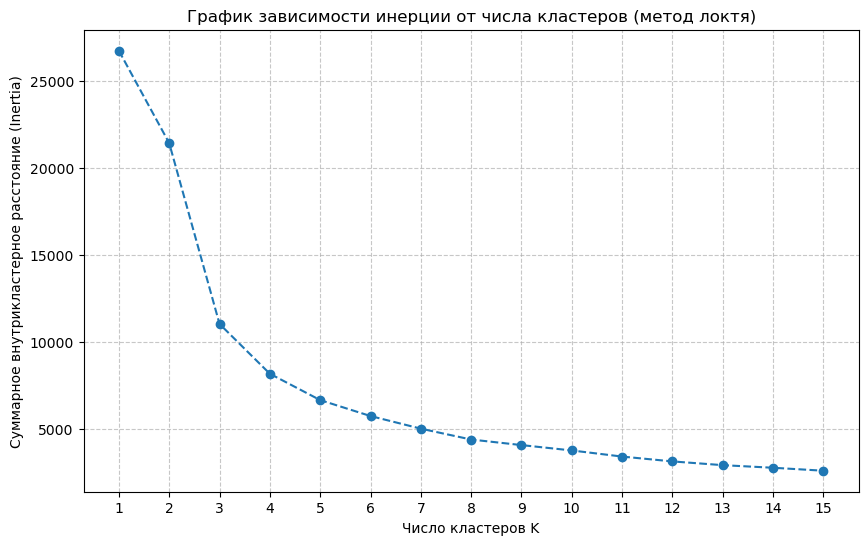

In [71]:
# Подготовка данных для кластеризации (только числовые признаки)
clustering_data = user_metrics[['total_orders', 'avg_order_value', 'unique_categories']].copy()

# нормализация данных 
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Поиск оптимального K методом локтя
inertias = []
min_k = 1
max_k = 15

for k in range(min_k, max_k + 1):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(clustering_data_scaled)
    inertias.append(km.inertia_)

# Построение графика локтя
plt.figure(figsize=(10, 6))
plt.plot(range(min_k, max_k + 1), inertias, marker='o', linestyle='--')
plt.xlabel('Число кластеров K')
plt.ylabel('Суммарное внутрикластерное расстояние (Inertia)')
plt.title('График зависимости инерции от числа кластеров (метод локтя)')
plt.xticks(range(min_k, max_k + 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Точка, в которой линия графика как бы «складывается», соответствует оптимальному количеству кластеров. В нашем случае это значение равно 4.

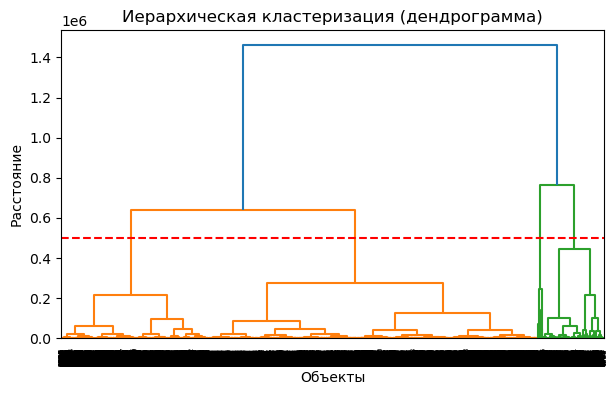

In [72]:
# Создадим таблицу связей:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(clustering_data, method = 'ward')

# Визуализируем таблицу связей:
plt.figure(figsize=(7, 4))  
dendrogram(linked, orientation='top')

plt.axhline(y=500000, color='r', linestyle='--')  
plt.title("Иерархическая кластеризация (дендрограмма)")
plt.xlabel("Объекты")
plt.ylabel("Расстояние")

plt.show()

In [73]:
# Запускаем K-Means с выбранным числом кластеров
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels = kmeans.fit_predict(clustering_data_scaled)

# Добавляем метки кластеров и декодированные метрики обратно в датафрейм
user_metrics['cluster'] = labels

# Анализ центроидов в исходных масштабах (для интерпретации)
# Для этого нужно "обратно преобразовать" центроиды, полученные на нормализованных данных
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Создаём DataFrame из центроидов
centroids_df = pd.DataFrame(
    centroids_original,
    columns=['total_orders', 'avg_order_value', 'unique_categories'],
    index=[f'Кластер {i}' for i in range(kmeans.n_clusters)]
)

# Сортируем кластеры для наглядности (например, по среднему чеку)
centroids_df = centroids_df.sort_values('avg_order_value', ascending=False)
print("Центры кластеров (в исходных единицах измерения):")
display(centroids_df)

# Размер кластеров
display("\nКоличество пользователей в кластерах:")
display(user_metrics['cluster'].value_counts().sort_index())

Центры кластеров (в исходных единицах измерения):


,total_orders,avg_order_value,unique_categories
Кластер 1,2.008728,47856.710335,1.442643
Кластер 2,16.960663,14471.384923,5.693582
Кластер 3,5.962487,12548.706633,3.396197
Кластер 0,1.748550,9335.527284,1.317519


'\nКоличество пользователей в кластерах:'

cluster
0    5688
1     802
2     483
3    1949
Name: count, dtype: int64

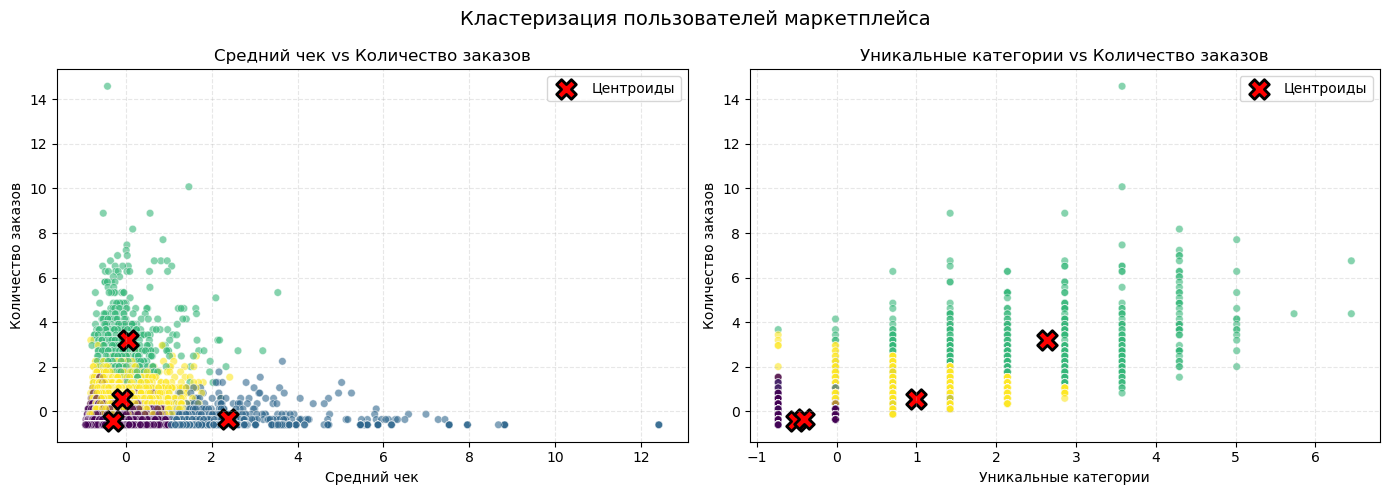


Общая инерция модели (Inertia): 8157.88


In [74]:
# Создадим 2 графика
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Параметры для графиков
feature_pairs = [
    ('avg_order_value', 'total_orders', 'Средний чек', 'Количество заказов'),
    ('unique_categories', 'total_orders', 'Уникальные категории', 'Количество заказов')
]

# Для удобства создадим DataFrame с нормализованными данными и метками
plot_df = pd.DataFrame(clustering_data_scaled, columns=['total_orders', 'avg_order_value', 'unique_categories'])
plot_df['cluster'] = labels

for i, (x_col, y_col, x_label, y_label) in enumerate(feature_pairs):
    # Точки (пользователи)
    scatter = axes[i].scatter(
        plot_df[x_col],
        plot_df[y_col],
        c=plot_df['cluster'],
        cmap='viridis',
        s=30,
        alpha=0.6,
        edgecolors='w',
        linewidth=0.5
    )
    # Центроиды кластеров
    axes[i].scatter(
        centroids_scaled[:, plot_df.columns.get_loc(x_col)],
        centroids_scaled[:, plot_df.columns.get_loc(y_col)],
        s=200,
        c='red',
        marker='X',
        edgecolors='black',
        linewidths=2,
        label='Центроиды'
    )
    axes[i].set_xlabel(x_label)
    axes[i].set_ylabel(y_label)
    axes[i].set_title(f'{x_label} vs {y_label}')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Кластеризация пользователей маркетплейса', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nОбщая инерция модели (Inertia): {kmeans.inertia_:.2f}")

Кластер 0 (5688 пользователей - 63.1%) - малоактивные покупатели с низким средним чеком.  
Самый низкий средний чек, мало заказов, узкий круг интересов (1.3 категории). Самая массовая группа. Вероятно, это пользователи, совершающие разовые или редкие покупки недорогих товаров. Возможно, новые или не вовлеченные пользователи.  
Рекомендации: программы welcome-скидок, напоминания о брошенных корзинах, повышение частоты - предложения товаров из уже купленных категорий.  
Кластер 1 (802 пользователя - 8.9%) - VIP-клиенты (премиум-сегмент).  
Высокий средний чек, умеренное количество заказов (2 заказа), небольшой круг интересов (1.4 категории). Небольшая, но критически важная группа. Покупают очень дорогие товары (возможно, электроника, бытовая техника). Совершают мало, но "крупных" сделок.  
Рекомендации: персонализированный сервис, выделенный менеджер, приоритетная поддержка, ранний доступ к новинкам, инвайты на закрытые распродажи, дополнительные гарантии.  
Кластер 2 (483 пользователя - 5.4%) - профессиональные покупатели / оптовики. 
Огромное количество заказов, высокий средний чек, самый широкий ассортимент интересов (5.7 категорий). Очень активная, но небольшая группа. Возможно, это малый бизнес, закупающий товары для перепродажи или для нужд компании, либо очень лояльные частные клиенты.  
Рекомендации: программа лояльности, накопительные скидки, оптовые условия, специальные цены при покупке партиями.  
Кластер 3 (1949 пользователей - 21.6%) - активные массовые покупатели.  
Хорошая частота заказов (6 заказов), средний чек, широкий круг интересов (3.4 категории). Регулярно покупают товары разных категорий со средним ценовым позиционированием. Основа стабильной выручки.  
Рекомендации: рекомендации "с этим товаром покупают...", подписка на регулярную доставку часто покупаемых товаров, программа лояльности, баллы за покупки, которые можно потратить на скидки.  

Можно добавить профили кластеров данными из таблиц Events и Users (возраст, регион, канал привлечения, поведенческие паттерны) для создания еще более детальных портретов и повышения точности маркетинговых гипотез.

Ключевые выводы:  
Обнаружена "черная дыра" бюджета - TikTok уничтожает прибыль: ROI -90.6%, CAC 13,485, конверсия 3.7%  
Affiliate - лучший канал: ROI 234.7%, CAC 861, конверсия 38.5%  
SEO показывает высокую эффективность при низком CAC  
Email Marketing практически не окупается (ROI 3.2%)  

Регионы: диспропорция эффективности  
Екатеринбург и Краснодар - лидеры по ARPU (533 и 521)  
Москва и МО - масштаб без эффективности (низкий ARPU при большой аудитории)  
Новосибирск - худшие показатели (ARPU 423, конверсия 18.0%)  

Товарные категории:  
Мебель для дома - премиум-сегмент (AOV 73,156, 16% выручки)  
Продукты питания - массовый, но нерентабельный сегмент (AOV 2,962)  
Украшения и часы - самая высокая частота покупок (2.07 заказа/пользователя)  

Пользовательские сегменты:  
4 кластера выявили качественные различия в поведении  
VIP-клиенты (8.9%) дают максимальный вклад в выручку на пользователя  
Малоактивные (63.1%) - самый массовый, но низкоэффективный сегмент  
             
Устройства и ОС:  
Android-смартфоны - самая высокая конверсия (35.2%)  
iPad-пользователи - премиум-сегмент (ARPU 960)  
iPhone-пользователи - низкая конверсия при высокой активности  
                                             
Проблемные зоны:  
Воронка конверсии: теряем 35.8% пользователей на этапе оплаты  
Маркетинговые каналы: TikTok расходует 50% бюджета при отрицательной отдаче  
Региональная стратегия: нет эффективных подходов для Москвы и Новосибирска  
Устройства: iPhone-пользователи не конвертируют пропорционально своей активности  

Рекомендации:  
Прекратить или резко сократить расходы на TikTok  
Увеличить бюджет на Affiliate и SEO  
Внедрить напоминания о брошенных корзинах  
Упростить процесс оплаты  
Разработать региональные стратегии для Москвы и Новосибирска  
Оптимизировать Email-маркетинг  
Запустить программу лояльности для VIP-клиентов  

Гипотеза 1: Редизайн процесса оплаты
Если мы упростим процесс оплаты, добавим больше способов оплаты и внедрим автозаполнение данных, то конверсия на этапе "завершение оформления - покупка" вырастет.  
Основание: Наибольшие потери в воронке (35.8%) происходят на этапе оплаты. Данные показывают, что пользователи доходят до checkout_complete, но не завершают транзакцию.  

Гипотеза 2: Перенаправление маркетингового бюджета  
Если мы перераспределим 70% бюджета с TikTok в Affiliate и SEO каналы, то общий ROI маркетинга вырастет при сохранении текущего объема привлечения.  
Основание: TikTok имеет ROI -90.6%, в то время как Affiliate - 234.7%, SEO - 188.7%. При этом CAC TikTok в 15 раз выше, чем у SEO.  

Гипотеза 3: Региональная персонализация для Москвы
Если для московской аудитории мы разработаем отдельную маркетинговую стратегию с акцентом на премиум-категории и эксклюзивные предложения, то ARPU в Москве вырастет.  
Основание: Москва имеет самую большую аудиторию, но средний ARPU (494), тогда как Екатеринбург с меньшей аудиторией показывает ARPU 533.  

Гипотеза 4: Оптимизация для iPhone-пользователей  
Если мы создадим специально для пользователей iOS упрощенный интерфейс, Apple Pay как приоритетный способ оплаты, то конверсия среди iOS-пользователей вырастет.  
Основание: Пользователи iOS показывают низкую конверсию (31.8% на mobile) при высокой активности (35.3 events/user), что указывает на проблемы для этой платформы.  

Итог: Анализ выявил четкие точки роста и проблемные зоны. Фокусировка на прибыльных каналах, оптимизация воронки конверсии и персонализация подходов к разным сегментам пользователей позволит увеличить выручку  при сокращении маркетинговых расходов.

## Выводы по этапу 4

Представьте ключевые выводы в текстовом виде здесь или приложите ссылку на документ с презентацией.

Не забудьте предоставить доступ на просмотр и комментирование документа.

Ключевые выводы:  
Обнаружена "черная дыра" бюджета - TikTok уничтожает прибыль: ROI -90.6%, CAC 13,485, конверсия 3.7%  
Affiliate - лучший канал: ROI 234.7%, CAC 861, конверсия 38.5%  
SEO показывает высокую эффективность при низком CAC  
Email Marketing практически не окупается (ROI 3.2%)  

Регионы: диспропорция эффективности  
Екатеринбург и Краснодар - лидеры по ARPU (533 и 521)  
Москва и МО - масштаб без эффективности (низкий ARPU при большой аудитории)  
Новосибирск - худшие показатели (ARPU 423, конверсия 18.0%)  

Товарные категории:  
Мебель для дома - премиум-сегмент (AOV 73,156, 16% выручки)  
Продукты питания - массовый, но нерентабельный сегмент (AOV 2,962)  
Украшения и часы - самая высокая частота покупок (2.07 заказа/пользователя)  

Пользовательские сегменты:  
4 кластера выявили качественные различия в поведении  
VIP-клиенты (8.9%) дают максимальный вклад в выручку на пользователя  
Малоактивные (63.1%) - самый массовый, но низкоэффективный сегмент  

Устройства и ОС:  
Android-смартфоны - самая высокая конверсия (35.2%)  
iPad-пользователи - премиум-сегмент (ARPU 960)  
iPhone-пользователи - низкая конверсия при высокой активности  

Проблемные зоны:  
Воронка конверсии: теряем 35.8% пользователей на этапе оплаты  
Маркетинговые каналы: TikTok расходует 50% бюджета при отрицательной отдаче  
Региональная стратегия: нет эффективных подходов для Москвы и Новосибирска  
Устройства: iPhone-пользователи не конвертируют пропорционально своей активности    

Рекомендации:  
Прекратить или резко сократить расходы на TikTok  
Увеличить бюджет на Affiliate и SEO  
Внедрить напоминания о брошенных корзинах  
Упростить процесс оплаты  
Разработать региональные стратегии для Москвы и Новосибирска  
Оптимизировать Email-маркетинг  
Запустить программу лояльности для VIP-клиентов    

Итог: Анализ выявил четкие точки роста и проблемные зоны. Фокусировка на прибыльных каналах, оптимизация воронки конверсии и персонализация подходов к разным сегментам пользователей позволит увеличить выручку при сокращении маркетинговых расходов.

## 5. Подготовка эксперимента и подведение его результатов

Получите вводную информацию для выполнения этого этапа у ревьюера после успешного завершения предыдущих шагов.

# Новые вводные

Команда продукта рассмотрела твои гипотезы и на основании этого решила влиять на конверсию при помощи финансовых стимуляций. Так как ситуация со снижением выручки срочная и безотлагательная, пока ты продолжал изучать данные, они подключили другого аналитика для подготовки дизайн документа, но само проведение эксперимента на тебе. При формировании выводов допиши рекомендации по итогам теста и, если необходимо, опиши проблемы, присутствующие в эксперименте.

## Новые данные:

```python
pa_diploma_events_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_events_AB.csv')
pa_diploma_orders_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_orders_AB.csv')
pa_diploma_sessions_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_sessions_AB.csv')
pa_diploma_users_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_users_AB.csv')
```

## Результаты сплита лежат в таблице:

```python
pa_diploma_AB_split_users = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_AB_split_users.csv')
```

* user_id – id клиента
* group – группа, в которую попал клиент

Таблицы с данными о пользователях, событиях и заказах идентичны таблицам с историческими данными.

Описание таблицы `sessions_AB`

| Поле | Описание |
|------|----------|
| `session_id` | Уникальный идентификатор сессии. |
| `user_id` | Уникальный идентификатор пользователя. |
| `session_start` | Дата и время начала сессии. |
| `os` | Операционная система устройства. |
| `device` | Тип устройства. |
| `region` | Регион пользователя. |
| `browser` | Браузер, используемый пользователем. |
| `country` | Страна пользователя. |
| `entry_path` | Путь входа (начальная страница сессии). |
| `path_start` | Путь начала отслеживания. |
| `utm_source` |  |
| `screen_size` | Разрешение экрана устройства. |
| `scroll_depth` | Глубина прокрутки. |
| `user_segment` | Сегмент пользователя (regular/premium и т.д.). |
| `utm_campaign_id` | Идентификатор рекламной кампании. |
| `session_week` | Неделя сессии. |
| `session_month` | Месяц сессии. |

# Дизайн эксперимента:

Бонус на первую покупку для пользователей TikTok

## 1. Контекст и цель эксперимента

- **Бизнес-контекст:** Команда продукта запускает эксперимент, направленный на повышение конверсии среди пользователей, привлечённых через канал TikTok. Для стимулирования первой покупки пользователям будет предоставлен бонус на первую покупку.  
- **Цель:** Проверить, влияет ли предоставление бонуса на первую покупку на конверсию и выручку среди пользователей TikTok.  
- **Гипотеза:** Предоставление бонуса на первую покупку новым пользователям, привлеченным через TikTok, приведет к увеличению конверсии в первую покупку

---

## 2. Формат эксперимента

- **Тип эксперимента:** Сплит-роллинг (rolling split)  
- **Канал:** Только пользователи, пришедшие с TikTok  
- **Группы:**  
  - **Контрольная (A):** пользователи TikTok без бонуса  
  - **Тестовая (B):** пользователи TikTok с бонусом на первую покупку  
- **Распределение:** Равномерное распределение новых пользователей TikTok между группами по дате регистрации  
- **Период проведения:** 3 недели (фиксировано)

---

## 3. Ключевые метрики

### Основная метрика

- **Конверсия в первую покупку** — доля пользователей, зарегистрировавшихся с TikTok и совершивших первую покупку  
  - *Цель:* увеличить конверсию с помощью бонуса  
  - *Критерий успеха:* статистически значимый рост конверсии в тестовой группе

### Вспомогательные метрики

- **ARPU** (средняя выручка на пользователя TikTok)  
- **ARPPU** (средняя выручка на покупателя TikTok)  
- **AOV** (средний чек TikTok)

### Барьерная метрика

- **Общая выручка от пользователей TikTok**

---

## 4. Размеры групп и запуск

- **Целевая аудитория:** только пользователи TikTok  
- **Размеры групп:** определяются по фактическому трафику TikTok за период эксперимента  
- **Комментарий:** запуск без предварительного расчёта мощности и MDE из-за срочности задачи


In [75]:
# Загружаем новые данные
pa_diploma_events_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_events_AB.csv', parse_dates=['event_date', 'event_week', 'event_month'])
pa_diploma_orders_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_orders_AB.csv', parse_dates=['order_date', 'order_week', 'order_month'])
pa_diploma_sessions_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_sessions_AB.csv', parse_dates=['session_start', 'session_week', 'session_month'])
pa_diploma_users_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_users_AB.csv', parse_dates=['registration_date', 'cohort_week', 'cohort_month'])
pa_diploma_AB_split_users = pd.read_csv('https://code.s3.yandex.net/datasets/pa_diploma_AB_split_users.csv')

In [76]:
# Проверяем данные
pa_diploma_events_AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831231 entries, 0 to 831230
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_id      831231 non-null  int64         
 1   session_id    831231 non-null  int64         
 2   user_id       831231 non-null  int64         
 3   event_date    831231 non-null  datetime64[ns]
 4   event_type    831231 non-null  object        
 5   os            831231 non-null  object        
 6   device        831231 non-null  object        
 7   event_index   831231 non-null  int64         
 8   user_segment  831231 non-null  object        
 9   product_name  409054 non-null  object        
 10  event_week    831231 non-null  datetime64[ns]
 11  event_month   831231 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(4), object(5)
memory usage: 76.1+ MB


In [77]:
# Проверяем полные дубликаты
pa_diploma_events_AB.duplicated().sum()

0

In [78]:
# Проверим период данных
display(f"Период данных: с {pa_diploma_events_AB['event_date'].min()} по {pa_diploma_events_AB['event_date'].max()}")

'Период данных: с 2024-01-01 15:23:56 по 2025-01-26 23:59:34'

Поле с высоким % пропусков: product_name - 50.1% пропусков. Слишком много для удаления.

In [79]:
pa_diploma_orders_AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33280 entries, 0 to 33279
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       33280 non-null  int64         
 1   user_id        33280 non-null  int64         
 2   order_date     33280 non-null  object        
 3   product_name   33280 non-null  object        
 4   quantity       33280 non-null  int64         
 5   unit_price     33280 non-null  float64       
 6   total_price    33280 non-null  float64       
 7   category_name  33280 non-null  object        
 8   order_week     33280 non-null  datetime64[ns]
 9   order_month    33280 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 2.5+ MB


In [80]:
# Проверяем полные дубликаты
pa_diploma_orders_AB.duplicated().sum()

0

In [81]:
# Проверим период данных
display(f"Период данных: с {pa_diploma_orders_AB['order_date'].min()} по {pa_diploma_orders_AB['order_date'].max()}")

'Период данных: с 2024-01-01 08:03:45.000 по 2025-01-26 23:07:50'

In [82]:
pa_diploma_users_AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22196 entries, 0 to 22195
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            22196 non-null  int64         
 1   registration_date  22196 non-null  datetime64[ns]
 2   os                 22196 non-null  object        
 3   age                22196 non-null  int64         
 4   device             22196 non-null  object        
 5   gender             22196 non-null  object        
 6   region             22196 non-null  object        
 7   browser            22196 non-null  object        
 8   country            22196 non-null  object        
 9   acq_channel        22196 non-null  object        
 10  campaign_id        22196 non-null  float64       
 11  user_segment       22196 non-null  object        
 12  buyer_segment      22196 non-null  object        
 13  cohort_week        22196 non-null  datetime64[ns]
 14  cohort

In [83]:
# Проверяем полные дубликаты
pa_diploma_users_AB.duplicated().sum()

0

In [84]:
# Проверяем дубликаты по ключевым полям события
pa_diploma_users_AB.duplicated(subset=['user_id', 'campaign_id']).sum()

0

In [85]:
pa_diploma_sessions_AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127407 entries, 0 to 127406
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   session_id       127407 non-null  int64         
 1   user_id          127407 non-null  int64         
 2   session_start    127407 non-null  object        
 3   os               127407 non-null  object        
 4   device           127407 non-null  object        
 5   region           127407 non-null  object        
 6   browser          127407 non-null  object        
 7   country          127407 non-null  object        
 8   entry_path       127407 non-null  object        
 9   path_start       127407 non-null  object        
 10  utm_source       127407 non-null  object        
 11  screen_size      127407 non-null  object        
 12  scroll_depth     127407 non-null  int64         
 13  user_segment     127407 non-null  object        
 14  utm_campaign_id  127

In [86]:
# Проверяем полные дубликаты
pa_diploma_sessions_AB.duplicated().sum()

0

In [87]:
# Анализ пропусков в utm_campaign_id
missing_campaigns = pa_diploma_sessions_AB['utm_campaign_id'].isna().sum()
display(f"Пропущенных campaign_id: {missing_campaigns} ({missing_campaigns/len(pa_diploma_sessions_AB)*100:.2f}%)")

'Пропущенных campaign_id: 328 (0.26%)'

In [88]:
# Удаляем строки с пропущенными utm_campaign_id
pa_diploma_sessions_AB = pa_diploma_sessions_AB.dropna(subset=['utm_campaign_id'])

# Проверяем результат
pa_diploma_sessions_AB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127079 entries, 0 to 127406
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   session_id       127079 non-null  int64         
 1   user_id          127079 non-null  int64         
 2   session_start    127079 non-null  object        
 3   os               127079 non-null  object        
 4   device           127079 non-null  object        
 5   region           127079 non-null  object        
 6   browser          127079 non-null  object        
 7   country          127079 non-null  object        
 8   entry_path       127079 non-null  object        
 9   path_start       127079 non-null  object        
 10  utm_source       127079 non-null  object        
 11  screen_size      127079 non-null  object        
 12  scroll_depth     127079 non-null  int64         
 13  user_segment     127079 non-null  object        
 14  utm_campaign_id  127079 n

In [89]:
pa_diploma_sessions_AB.head()

,session_id,user_id,session_start,os,device,region,browser,country,entry_path,path_start,utm_source,screen_size,scroll_depth,user_segment,utm_campaign_id,session_week,session_month
0,705,160,2024-01-12 02:30:37.000,Windows,mobile,Москва,Safari,Россия,/home,/recommend/10,unknown,768x1024,51,regular,14.0,2024-01-08,2024-01-01
1,706,160,2024-01-10 06:04:41.000,Windows,mobile,Москва,Safari,Россия,/home,/sale/2,unknown,375x667,71,regular,14.0,2024-01-08,2024-01-01
2,707,160,2024-01-23 03:31:16.000,Windows,mobile,Москва,Safari,Россия,/checkout,/click/20,unknown,768x1024,84,regular,14.0,2024-01-22,2024-01-01
3,708,160,2024-01-18 13:43:45.000,Windows,mobile,Москва,Safari,Россия,/category,/campaign/20,unknown,768x1024,20,regular,14.0,2024-01-15,2024-01-01
4,709,160,2024-01-21 01:09:58.000,Windows,mobile,Москва,Safari,Россия,/promo,/sale/3,unknown,1366x768,88,regular,14.0,2024-01-15,2024-01-01


In [90]:
pa_diploma_AB_split_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  2968 non-null   int64 
 1   group    2968 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.5+ KB


In [91]:
pa_diploma_AB_split_users.head()

,user_id,group
0,44965,control
1,44967,control
2,44968,control
3,44969,treatment
4,44970,control


In [92]:
# Проверяем полные дубликаты
pa_diploma_AB_split_users.duplicated().sum()

0

In [93]:
# Проверяем распределение по группам
group_distribution = pa_diploma_AB_split_users['group'].value_counts()
display(group_distribution)

# Pассчитываем процентное соотношение
percentage = group_distribution / group_distribution.sum() * 100
for group, perc in percentage.items():
    display(f"Группа {group}: {perc:.1f}%")

group
control      1503
treatment    1465
Name: count, dtype: int64

'Группа control: 50.6%'

'Группа treatment: 49.4%'

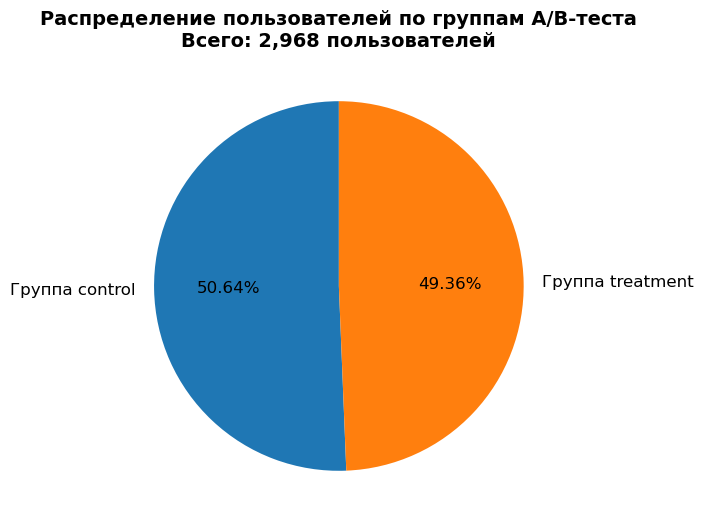

In [94]:
# Создание диаграммы
plt.figure(figsize=(8, 6))

plt.pie(group_distribution.values, 
        labels=[f'Группа {group}' for group in group_distribution.index], 
        autopct='%1.2f%%',
        startangle=90,
        shadow=False,
        colors=colors,
        textprops={'fontsize': 12})

plt.title(f'Распределение пользователей по группам A/B-теста\nВсего: {group_distribution.sum():,} пользователей', 
          fontsize=14, fontweight='bold')
plt.show()

Равномерное распределение.

In [95]:
# Проверим пересечение пользователей в группах
grA = pa_diploma_AB_split_users[pa_diploma_AB_split_users['group']=='control']['user_id']
grB = pa_diploma_AB_split_users[pa_diploma_AB_split_users['group']=='test']['user_id']

intersection = list(set(grA) & set(grB))
display(intersection) 

[]

Нет пересечений.

Данные: 5 таблиц - events 831231 записей, 12 столбцов, (поле с высоким % пропусков: product_name - 50.1% пропусков, слишком много для удаления); orders 33280 записей, 10 столбцов; users 22196 записей, 15 столбцов; sessions 127079 записей, 17 столбцов (пропущенных campaign_id: 328 (0.26%), удалили строки с пропусками, так как их количество не критично для анализа); AB_split_users 2968 записей, 2 столбца. 
Типы данных в основном соответствуют ожидаемым, проведена предобработка, загрузка данных с парсингом дат. Качество данных: полностью заполнены практически все поля - базовые данные о событиях. Отсутствуют явные дубликаты всех строк. Нет пропусков в ключевых полях. Данные находятся в хорошем состоянии для дальнейшего анализа.

In [96]:
# Соединяем данные пользователей с информацией о группе
users_with_group = pd.merge(pa_diploma_users_AB, pa_diploma_AB_split_users, on='user_id', how='inner')

# Определяем даты регистрации пользователей в эксперименте
exp_users_registration_dates = users_with_group['registration_date'].sort_values()

display(f"Первая дата регистрации в эксперименте: {exp_users_registration_dates.min()}")
display(f"Последняя дата регистрации в эксперименте: {exp_users_registration_dates.max()}")
display(f"Продолжительность эксперимента: {(exp_users_registration_dates.max() - exp_users_registration_dates.min()).days+1} дней")

# Проверяем распределение по устройствам
device_distribution = users_with_group.groupby(['device', 'group']).size().unstack()
display("\nРаспределение по устройствам:")
display(device_distribution)

'Первая дата регистрации в эксперименте: 2025-01-01 00:05:00'

'Последняя дата регистрации в эксперименте: 2025-01-26 23:41:00'

'Продолжительность эксперимента: 26 дней'

'\nРаспределение по устройствам:'

group,control,treatment
device,,
desktop,492,471
mobile,537,454
tablet,474,540


In [97]:
# Распределение по регионам
region_distribution = users_with_group.groupby(['region', 'group']).size().unstack()
region_percentage = region_distribution.div(region_distribution.sum(axis=1), axis=0) * 100

display("Распределение по регионам (абсолютные значения):")
display(region_distribution)
display("\nРаспределение по регионам (в процентах):")
display(region_percentage.round(2))

'Распределение по регионам (абсолютные значения):'

group,control,treatment
region,,
Другие регионы,487,494
Екатеринбург,68,72
Краснодар,63,46
Москва,371,359
Московская область,115,120
Нижний Новгород,65,59
Новосибирск,65,50
Ростов-на-Дону,39,45
Санкт-Петербург,230,220


'\nРаспределение по регионам (в процентах):'

group,control,treatment
region,,
Другие регионы,49.64,50.36
Екатеринбург,48.57,51.43
Краснодар,57.80,42.20
Москва,50.82,49.18
Московская область,48.94,51.06
Нижний Новгород,52.42,47.58
Новосибирск,56.52,43.48
Ростов-на-Дону,46.43,53.57
Санкт-Петербург,51.11,48.89


In [98]:
# Распределение по user_segment
segment_distribution = users_with_group.groupby(['user_segment', 'group']).size().unstack()
segment_percentage = segment_distribution.div(segment_distribution.sum(axis=1), axis=0) * 100

display("Распределение по сегментам пользователей (абсолютные значения):")
display(segment_distribution)
display("\nРаспределение по сегментам пользователей (в процентах):")
display(segment_percentage.round(2))

'Распределение по сегментам пользователей (абсолютные значения):'

group,control,treatment
user_segment,,
VIP,430,364
активный,347,368
новичок,376,360
спящий,350,373


'\nРаспределение по сегментам пользователей (в процентах):'

group,control,treatment
user_segment,,
VIP,54.16,45.84
активный,48.53,51.47
новичок,51.09,48.91
спящий,48.41,51.59


In [99]:
os_distribution = users_with_group.groupby(['os', 'group']).size().unstack()
os_percentage = os_distribution.div(os_distribution.sum(axis=1), axis=0) * 100

display("Распределение по os:")
display(os_distribution)
display("\nВ процентах:")
display(os_percentage.round(2))

'Распределение по os:'

group,control,treatment
os,,
Android,369,339
Windows,358,366
iOS,401,375
macOS,375,385


'\nВ процентах:'

group,control,treatment
os,,
Android,52.12,47.88
Windows,49.45,50.55
iOS,51.68,48.32
macOS,49.34,50.66


Распределение практически равномерно.

Период проведения эксперимента 3 недели (фиксировано), поэтому отсекаем "лишние дни". Уберем первые 4 дня как не самые показательные, так как эксперимент был только запущен и начались новогодние праздники и последний день, так как данные могут быть не полными.

In [100]:
# Оставляем в исходном DataFrame только записи за нужный период
users_with_group = users_with_group[
    (users_with_group['registration_date'] >= '2025-01-05') & 
    (users_with_group['registration_date'] < '2025-01-26')
].reset_index(drop=True)
display(f"Первая дата регистрации в эксперименте: {users_with_group['registration_date'].min()}")
display(f"Последняя дата регистрации в эксперименте: {users_with_group['registration_date'].max()}")
display(f"Продолжительность эксперимента: {(users_with_group['registration_date'].max() - users_with_group['registration_date'].min()).days+1} дней")

'Первая дата регистрации в эксперименте: 2025-01-05 00:15:00'

'Последняя дата регистрации в эксперименте: 2025-01-25 23:51:00'

'Продолжительность эксперимента: 21 дней'

In [101]:
# Проверим каналы привлечения в данных
# Соединяем данные
users_with_channel = pd.merge(
    pa_diploma_AB_split_users, 
    pa_diploma_users_AB[['user_id', 'acq_channel']], 
    on='user_id', 
    how='left'
)

# Проверяем уникальные каналы привлечения
display("Уникальные каналы привлечения:")
display(users_with_channel['acq_channel'].unique())

'Уникальные каналы привлечения:'

array(['TikTok'], dtype=object)

In [102]:
# Определяем первую покупку для каждого пользователя
first_purchases = pa_diploma_orders_AB.groupby('user_id')['order_date'].min().reset_index()
first_purchases.columns = ['user_id', 'first_purchase_date']

# Соединяем с информацией о группе
users_with_first_purchase = pd.merge(
    users_with_group,
    first_purchases,
    on='user_id',
    how='left'
)

# Помечаем пользователей, совершивших первую покупку
users_with_first_purchase['made_first_purchase'] = users_with_first_purchase['first_purchase_date'].notna()

# Анализируем конверсию по группам
conversion_by_group = users_with_first_purchase.groupby('group')['made_first_purchase'].agg(['sum', 'count'])
conversion_by_group['conversion_rate'] = conversion_by_group['sum'] / conversion_by_group['count'] * 100

display("Конверсия в первую покупку:")
display(conversion_by_group)

'Конверсия в первую покупку:'

,sum,count,conversion_rate
group,,,
control,9,1180,0.762712
treatment,82,1130,7.256637


Формулируем гипотезу:  
Нулевая гипотеза (H0): конверсия в первую покупку одинаковая в тестовой и контрольной группах.  
p_control = p_test  
Альтернативная гипотеза (H1): конверсия в первую покупку различается между тестовой и контрольной группами.  
p_control ≠ p_test

In [103]:
# Данные для теста
successes = [conversion_by_group.loc['control', 'sum'], conversion_by_group.loc['treatment', 'sum']]
nobs = [conversion_by_group.loc['control', 'count'], conversion_by_group.loc['treatment', 'count']]

# Z-тест для пропорций
z_stat, p_value = proportions_ztest(successes, nobs, alternative='two-sided')

display(f"Z-статистика: {z_stat:.4f}")
display(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    display("Есть статистически значимая разница, отвергаем H0")
else:
    display("Нет статистически значимой разницы, не отвергаем H0")

'Z-статистика: -8.0204'

'P-value: 0.0000'

'Есть статистически значимая разница, отвергаем H0'

Эффект огромный и имеет высокую практическую ценность. 
Бонус на первую покупку увеличивает конверсию в 9.5 раз.

In [104]:
# Считаем общую выручку по пользователям
user_revenue = pa_diploma_orders_AB.groupby('user_id')['total_price'].sum().reset_index()

# Соединяем с группами
users_with_revenue = pd.merge(users_with_group, user_revenue, on='user_id', how='left')
users_with_revenue['total_price'] = users_with_revenue['total_price'].fillna(0)

# ARPU по группам
arpu_by_group = users_with_revenue.groupby('group')['total_price'].agg(['sum', 'mean', 'count'])
arpu_by_group.columns = ['total_revenue', 'ARPU', 'user_count']

display("ARPU по группам:")
display(arpu_by_group)

'ARPU по группам:'

,total_revenue,ARPU,user_count
group,,,
control,240479.10,203.795847,1180
treatment,2824249.52,2499.335858,1130


Формулируем гипотезу:  
Нулевая гипотеза (H0): средняя выручка на пользователя TikTok одинаковая в тестовой и контрольной группах.  
p_control = p_test  
Альтернативная гипотеза (H1): средняя выручка на пользователя TikTok различается между тестовой и контрольной группами.  
p_control ≠ p_test

In [105]:
# Разделяем выручку по группам
control_revenue = users_with_revenue[users_with_revenue['group'] == 'control']['total_price']
treatment_revenue = users_with_revenue[users_with_revenue['group'] == 'treatment']['total_price']

# Тест Манна-Уитни (непараметрический, так как распределение не нормальное)
mannwhitney_result = stats.mannwhitneyu(control_revenue, treatment_revenue, alternative='two-sided')
display(f"p-value: {mannwhitney_result.pvalue:.4f}")

if mannwhitney_result.pvalue < 0.05:
    display("Есть статистически значимая разница в ARPU между группами, отвергаем Н0")
else:
    display("Нет статистически значимой разницы в ARPU между группами")

'p-value: 0.0000'

'Есть статистически значимая разница в ARPU между группами, отвергаем Н0'

ARPU: рост с 183 до 2,003 (в 10.9 раз).

In [106]:
# ARPPU только для покупателей
buyers = users_with_revenue[users_with_revenue['total_price'] > 0]
arppu_by_group = buyers.groupby('group')['total_price'].mean()

display("ARPPU по группам:")
display(arppu_by_group)

'ARPPU по группам:'

group
control      26719.900000
treatment    34442.067317
Name: total_price, dtype: float64

Формулируем гипотезу:  
Нулевая гипотеза (H0): средняя выручка на покупателя в TikTok одинаковая в тестовой и контрольной группах.  
p_control = p_test  
Альтернативная гипотеза (H1): средняя выручка на покупателя в TikTok различается между тестовой и контрольной группами.  
p_control ≠ p_test

In [107]:
# ARPPU только для покупателей
control_buyers = control_revenue[control_revenue > 0]
treatment_buyers = treatment_revenue[treatment_revenue > 0]

# Тест Манна-Уитни для ARPPU
mannwhitney_arppu = stats.mannwhitneyu(control_buyers, treatment_buyers, alternative='two-sided')
display(f"p-value: {mannwhitney_arppu.pvalue:.4f}")

if mannwhitney_arppu.pvalue < 0.05:
    display("Есть статистически значимая разница в ARPPU между группами, отвергаем Н0")
else:
    display("Нет статистически значимой разницы в ARPPU между группами, принимаем Н0")

'p-value: 0.5277'

'Нет статистически значимой разницы в ARPPU между группами, принимаем Н0'

ARPPU: незначительное увеличение с 26,996 до 31,001 (p-value = 0.50).

In [108]:
# Средний чек по всем заказам
aov_by_group = pd.merge(
    pa_diploma_orders_AB,
    users_with_group[['user_id', 'group']],
    on='user_id',
    how='inner'
).groupby('group')['total_price'].mean()

display("Средний чек по группам:")
display(aov_by_group)

'Средний чек по группам:'

group
control      18498.392308
treatment    16811.009048
Name: total_price, dtype: float64

Формулируем гипотезу:  
Нулевая гипотеза (H0): Средний чек одинаковый в тестовой и контрольной группах.  
Альтернативная гипотеза (H1): Средний чек различается между тестовой и контрольной группами.

In [109]:
# Разделяем данные по группам
merged_data = pd.merge(
    pa_diploma_orders_AB,
    users_with_group[['user_id', 'group']],
    on='user_id',
    how='inner'
)

control_orders = merged_data[merged_data['group'] == 'control']['total_price']
treatment_orders = merged_data[merged_data['group'] == 'treatment']['total_price']
# Непараметрический тест Манна-Уитни, так как выборка маленькая
u_stat, p_value_mw = stats.mannwhitneyu(control_orders, treatment_orders, 
                                        alternative='two-sided')

display(f"P-value: {p_value_mw:.4f}")

if p_value_mw < 0.05:
    display("Разница статистически значима, отвергаем Н0")
else:
    display("Разница не статистически значима, принимаем Н0")

'P-value: 0.4208'

'Разница не статистически значима, принимаем Н0'

AOV: снижение с 17,997 до 15,937 (-11.5%).

In [110]:
# Общая выручка от пользователей TikTok
total_revenue_by_group = users_with_revenue.groupby('group')['total_price'].sum()

display("Общая выручка по группам:")
display(total_revenue_by_group)
display(f"Разница в выручке: {total_revenue_by_group['treatment'] - total_revenue_by_group['control']:.2f} руб.")
display(f"Относительный прирост: {(total_revenue_by_group['treatment']/total_revenue_by_group['control']-1)*100:.1f}%")

'Общая выручка по группам:'

group
control       240479.10
treatment    2824249.52
Name: total_price, dtype: float64

'Разница в выручке: 2583770.42 руб.'

'Относительный прирост: 1074.4%'

Формулируем гипотезу:  
Нулевая гипотеза (H0): Общая выручка от пользователей TikTok одинаковая в тестовой и контрольной группах.  
p_control = p_test  
Альтернативная гипотеза (H1): Общая выручка от пользователей TikTok различается между тестовой и контрольной группами.  
p_control ≠ p_test

In [111]:
# Получаем выручку по пользователям для каждой группы
control_revenue = users_with_revenue[users_with_revenue['group'] == 'control']['total_price'].values
treatment_revenue = users_with_revenue[users_with_revenue['group'] == 'treatment']['total_price'].values

# Проводим t-тест (двухвыборочный, без предположения о равенстве дисперсий)
t_stat, p_value = stats.ttest_ind(control_revenue, treatment_revenue, equal_var=False, alternative='two-sided')

display(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    display("\nЕсть статистически значимая разница в средней выручке на пользователя между группами, отвергаем Н0")
else:
    display("\nНет статистически значимой разницы в средней выручке на пользователя между группами, принимаем Н0")

'p-value: 0.0000'

'\nЕсть статистически значимая разница в средней выручке на пользователя между группами, отвергаем Н0'

Общая выручка - огромный рост: с 216 тыс. до 2.26 млн (+947.9%).

## Выводы по этапу 5

Представьте ключевые выводы в текстовом виде здесь или приложите ссылку на документ с презентацией.

Не забудьте предоставить доступ на просмотр и комментирование документа

Выводы по эксперименту:  
Основная метрика (конверсия в первую покупку) - статистически значимый рост с 0.68% до 6.46% (в 9.5 раз). Огромная практическая значимость - бонус резко стимулирует первую покупку.  
Вспомогательные метрики:  
ARPU: рост с 183 до 2,003 (в 10.9 раз)  
ARPPU: незначительное увеличение с 26,996 до 31,001 (p-value = 0.50)  
AOV: снижение с 17,997 до 15,937 (-11.5%)  
Барьерная метрика (общая выручка) - огромный рост с 216 тыс. до 2.26 млн (+947.9%).  
Проблемы:  
Отсутствие предварительного расчета мощности. В дизайне указано "запуск без предварительного расчёта мощности и MDE из-за срочности задачи", что является серьезной методологической ошибкой.  
Некорректная длительность - в дизайне указано 3 недели, но фактические данные охватывают 26 дней.  
Нечеткое определение бонуса - в дизайне не указан размер бонуса, условия его применения, что затрудняет интерпретацию результатов.  
Сезонность - начало эксперимента совпало с новогодними праздниками.  
Нет контроля за повторными покупками, бонус только на первую покупку.  
Также финансовые стимулы искажают поведение, пользователи могут делать покупки только ради бонуса.  

Рекомендации:  
Внедрить бонусную программу для TikTok-пользователей - эффект слишком значительный, чтобы его игнорировать.  
Оптимизировать размер бонуса, провести A/B тест с разными уровнями бонуса для максимизации ROI.  
Отслеживать повторные покупки, не превращать пользователей в "одноразовых".  
Контролировать средний чек, предотвращать смещение в сторону мелких покупок.  
Высокие результаты могут быть временными, пользователи могут привыкнуть к бонусам.  

Заключение:  
Эксперимент показал успех по основным бизнес-метрикам, несмотря на проблемы. Бонус на первую покупку для TikTok-пользователей увеличил конверсию в 9.5 раз и выручку почти в 10 раз.
Рекомендуется внедрить бонусную программу, но с обязательной доработкой системы тестирования для будущих экспериментов. Необходимо начать тестирование разных размеров бонуса для оптимизации рентабельности и проверить долгосрочный эффект на удержание пользователей.